In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from typing import List, Optional, Union
from typing import Tuple
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import copy

def set_seed(seed=42):
    # Python built-in random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

In [2]:
# Call this at the beginning of your script
set_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 2048
EPOCHS = 500 # Set the total number of epochs you want to train for
print(f"✅ Using device: {device}")

✅ Using device: cpu


In [4]:
df_train = pd.read_csv("./UNSWNB15/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("./UNSWNB15/UNSW_NB15_testing-set.csv")

In [5]:
encode_cols = ['proto', 'service', 'state']
#df_train = df_train.drop(columns=encode_cols)
#df_test  = df_test.drop(columns=encode_cols)

label_encoders = {}
for col in encode_cols:
    le = LabelEncoder()
    # Fit on combined train + test to ensure consistency
    combined_data = pd.concat([df_train[col], df_test[col]], axis=0)
    le.fit(combined_data)

    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

    label_encoders[col] = le  # Save encoder for later use

In [6]:
df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,113,0,4,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,113,0,4,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,113,0,4,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,113,3,4,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,113,0,4,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [7]:
df_test.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,119,0,5,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,119,0,5,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,119,0,5,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,119,0,5,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,119,0,5,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [8]:
X_train = df_train.drop(['label','attack_cat'], axis=1)
y_train = df_train['label']

X_test = df_test.drop(['label','attack_cat'], axis=1)
y_test = df_test['label']

X_train = X_train.loc[:, (X_train >= 0).all()]
X_train = np.log1p(X_train)

X_test = X_test.loc[:, (X_test >= 0).all()]
X_test = np.log1p(X_test)

# power = 1/2
# X_train = np.power(X_train, power)
# X_test = np.power(X_test, power)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("x_train shape:",X_train_scaled.shape,"| y_train shape:",y_train.shape,"| x_test shape:",X_test_scaled.shape,"| y_test shape:",y_test.shape)

x_train shape: (175341, 43) | y_train shape: (175341,) | x_test shape: (82332, 43) | y_test shape: (82332,)


In [9]:
x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [10]:
class IndexedDataset(Dataset):
    def __init__(self, X_tensor, y_tensor):
        self.X = X_tensor
        self.y = y_tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], idx

train_dataset = IndexedDataset(x_train_tensor,y_train_tensor)
test_dataset = IndexedDataset(x_test_tensor,y_test_tensor)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size)

# Initialize per-sample weights (1.0 for all)
sample_weights = torch.ones(len(x_train_tensor), dtype=torch.float32)
sample_weights = sample_weights.to(device)

In [11]:
class ActivationNet(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.layer = nn.Linear(num_features, 8)
        self.drop = nn.Dropout(0.8)
        self.bn = nn.BatchNorm1d(8)
        
        self.y0_head = nn.Linear(8, num_features)
        self.m_head  = nn.Linear(8, num_features)
        self.x0_head = nn.Linear(8, num_features)
        self.combine = nn.Linear(3 * num_features, 3 * num_features)

    def forward(self, x):
        h = self.layer(x)
        h = torch.tanh(h)
        h = self.bn(h)
        h = self.drop(h)
        
        y0 = self.y0_head(h)
        m  = self.m_head(h)
        x0 = self.x0_head(h)
        
        params = torch.cat([y0, m, x0], dim=-1)
        params = self.combine(params)
        
        y0, m, x0 = torch.split(params, self.num_features, dim=1)
        
        y = y0 + m * (x - x0)
        
        return [x, y], [x0, y0, m]

In [12]:
class KDD_Model(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        # Block 1
        self.layer1 = nn.Linear(input_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.activation1 = ActivationNet(512)
        self.drop1 = nn.Dropout(0.8)

        # Block 2
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.activation2 = ActivationNet(256)
        self.drop2 = nn.Dropout(0.8)

        # Block 3
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.activation3 = ActivationNet(128)
        self.drop3 = nn.Dropout(0.8)

        # Residual Block 4
        self.layer4 = nn.Linear(128, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.activation4 = ActivationNet(128)
        self.drop4 = nn.Dropout(0.8)

        # Down to latent
        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.activation5 = ActivationNet(64)

        # Bottleneck
        self.layer6 = nn.Linear(64, 32)
        self.bn6 = nn.BatchNorm1d(32)
        self.activation6 = ActivationNet(32)

        # Output
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        # Block 1
        out1, internal_out1 = self.activation1(self.bn1(self.layer1(x)))
        x = self.drop1(out1[1])

        # Block 2
        out2, internal_out2 = self.activation2(self.bn2(self.layer2(x)))
        x = self.drop2(out2[1])

        # Block 3
        out3, internal_out3 = self.activation3(self.bn3(self.layer3(x)))
        x = self.drop3(out3[1])

        # Residual Block 4
        res = x
        out = self.layer4(x)
        out = self.bn4(out)
        out4, internal_out4 = self.activation4(out)
        out = self.drop4(out4[1])
        x = out + res  # residual skip

        # Block 5
        out5, internal_out5 = self.activation5(self.bn5(self.layer5(x)))

        # Block 6
        out6, internal_out6 = self.activation6(self.bn6(self.layer6(out5[1])))

        # Output
        x = self.output_layer(out6[1])

        return x, [out1, out2, out3, out4, out5, out6], [internal_out1, internal_out2, internal_out3, internal_out4, internal_out5, internal_out6]

In [13]:
# --- File Paths ---
BEST_MODEL_PATH = "./UNSWNB15/results_mv_2d/best_model_f1.pth"
CHECKPOINT_PATH = "./UNSWNB15/results_mv_2d/training_checkpoint.pth"
LOGS_PATH = "./UNSWNB15/results_mv_2d/training_logs.csv"

In [14]:
input_features = X_train_scaled.shape[1]
        
model = KDD_Model(input_features)
model = model.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss(reduction='none')

optimizer = optim.SGD(
    model.parameters(),
    lr=0.05,          # start higher than Adam
    momentum=0.9,
    nesterov=True,
    weight_decay=5e-4
)

In [15]:
# Checkpoint Loading (Resume Logic)

THRESH = 0.5  # <- your decision threshold
start_epoch = 0
best_f1_score = 0.0
history = []

# Check if a checkpoint file exists
if os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint found! Resuming training from {CHECKPOINT_PATH}")
    # Load the checkpoint
    checkpoint = torch.load(CHECKPOINT_PATH, weights_only=False)
    
    # Restore the state
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    
    # Find the best F1 score from the loaded history to continue tracking
    if history:
        # This gets the 'test_f1' value from each dictionary in the history list
        best_f1_score = max([epoch_data.get('test_f1', 0) for epoch_data in history])
    
    print(f"Resuming from epoch {start_epoch}. Best Test F1 so far: {best_f1_score:.4f}")
else:
    print("No checkpoint found. Starting training from scratch.")

Checkpoint found! Resuming training from ./UNSWNB15/results_mv_2d/training_checkpoint.pth
Resuming from epoch 500. Best Test F1 so far: 0.8613


In [34]:
def update_sample_weights(
    model: nn.Module,
    data_loader: DataLoader,
    current_weights: torch.Tensor,
    device: torch.device,
    threshold: float = 0.5,
    increase_factor: float = 1.2,
    decrease_factor: float = 0.9,
    min_weight: float = 0.1,
    max_weight: float = 5.0
) -> torch.Tensor:

    model.eval()  # Set model to evaluation mode for consistent predictions
    
    all_preds = []
    all_labels = []
    all_indices = []
    
    with torch.no_grad():
        # Loop through the entire dataset to get predictions
        for inputs, labels, indices in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs, _, _ = model(inputs)
            preds = (torch.sigmoid(outputs) > threshold).float()
            
            all_preds.append(preds.view(-1))
            all_labels.append(labels.view(-1))
            all_indices.append(indices.to(device)) # Keep indices on the same device
            
    # Concatenate all batch results into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_indices = torch.cat(all_indices)

    # Identify incorrect and correct predictions using a boolean mask
    incorrect_mask = (all_preds != all_labels)
    correct_mask = ~incorrect_mask

    # Use the boolean masks to get the global indices of the samples
    incorrect_indices = all_indices[incorrect_mask]
    correct_indices = all_indices[correct_mask]

    # Update weights for the identified samples
    # Note: We update the original 'current_weights' tensor
    current_weights[incorrect_indices] *= increase_factor
    current_weights[correct_indices] *= decrease_factor
    
    # Clamp the weights to a reasonable range and return
    return current_weights.clamp(min=min_weight, max=max_weight)

In [35]:
# Evaluation Function

@torch.no_grad()
def evaluate_model_threshold(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_count = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc=f"Testing", leave=True)

    for inputs, labels, _ in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device).view(-1).long()
        outputs, _, _ = model(inputs)

        # logits -> probs
        probs = torch.sigmoid(outputs.view(-1))
        preds = (probs >= THRESH).long()

        # per-sample loss (no weights on test unless you have a test weight vector)
        losses = loss_fn(outputs.view(-1), labels.float()).mean()

        batch_size = labels.size(0)
        total_loss += losses.item() * batch_size
        total_count += batch_size

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(loss=total_loss / total_count)

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Accuracy via thresholded preds
    acc = (all_preds == all_labels).mean()

    # Macro P/R/F1 (over classes 0 and 1)
    p, r, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    avg_loss = total_loss / total_count
    return avg_loss, acc, p, r, f1

In [36]:
# ---------------- Main Training Loop ----------------
for epoch in range(start_epoch, EPOCHS):
    model.train()

    # running stats for TRAIN (weighted loss averaged by total weight)
    total_weighted_loss = 0.0
    total_count = 0.0

    train_all_preds = []
    train_all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)

    for inputs, labels, indices in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1).long()
        indices = indices.to(device)

        # ---- Forward ----
        outputs, _, _ = model(inputs)  # shape [B, 1] or [B]
        logits = outputs.view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs >= THRESH).long()

        # per-sample loss (assumes BCEWithLogitsLoss(reduction='none'))
        losses = loss_fn(logits, labels.float()).view(-1)

        # weights
        batch_weights = sample_weights[indices]  # shape [B]
        weighted_loss = (losses * batch_weights).mean()

        # ---- Backward ----
        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()

        # ---- Accumulate epoch stats ----
        batch_size = labels.size(0)
        total_weighted_loss += weighted_loss.item() * batch_size
        total_count += batch_size

        train_all_preds.append(preds.detach().cpu())
        train_all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(weighted_loss=total_weighted_loss / total_count)
    
    # Update weights: increase for misclassified
    sample_weights = update_sample_weights(
        model=model,
        data_loader=train_loader,
        current_weights=sample_weights,
        device=device,
        threshold=THRESH
    )

    # ---- TRAIN epoch metrics (threshold-based) ----
    train_all_preds = torch.cat(train_all_preds).numpy()
    train_all_labels = torch.cat(train_all_labels).numpy()

    train_weighted_loss = total_weighted_loss / total_count
    train_acc = (train_all_preds == train_all_labels).mean()
    train_p, train_r, train_f1, _ = precision_recall_fscore_support(
        train_all_labels, train_all_preds, average='macro', zero_division=0
    )

    # ---- TEST evaluation (single pass, threshold-based) ----
    test_loss, test_acc, test_p, test_r, test_f1 = evaluate_model_threshold(
        model, test_loader, loss_fn, device
    )
    
    #scheduler.step(test_f1)

    # ---- Logging ----
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_weighted_loss:.4f}, Acc(th={THRESH}): {train_acc:.4f}, "
        f"P: {train_p:.4f}, R: {train_r:.4f}, F1: {train_f1:.4f} | "
        f"Test Loss: {test_loss:.4f}, Acc(th={THRESH}): {test_acc:.4f}, "
        f"P: {test_p:.4f}, R: {test_r:.4f}, F1: {test_f1:.4f}"
    )

    epoch_data = {
        'epoch': epoch + 1,
        'train_loss': train_weighted_loss,
        'train_accuracy_threshold': train_acc,
        'train_precision': train_p,
        'train_recall': train_r,
        'train_f1': train_f1,
        'test_loss': test_loss,
        'test_accuracy_threshold': test_acc,
        'test_precision': test_p,
        'test_recall': test_r,
        'test_f1': test_f1,
        'threshold': THRESH,
    }
    history.append(epoch_data)
    pd.DataFrame(history).to_csv(LOGS_PATH, index=False)

    # ---- Save the Best Model by Test F1 ----
    if test_f1 > best_f1_score:
        best_f1_score = test_f1
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"🎉 New best model saved with Test F1 Score: {best_f1_score:.4f}")

    # ---- Checkpoint every epoch ----
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, CHECKPOINT_PATH)

print("="*60)
print("Training finished!")
print(f"Best model saved to: {BEST_MODEL_PATH} (Test F1: {best_f1_score:.4f})")
print(f"Full training logs saved to: {LOGS_PATH}")
print(f"Final checkpoint for resumption saved to: {CHECKPOINT_PATH}")

Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.32it/s, loss=0.72]


Epoch 1/500 | Train Loss: 0.6489, Acc(th=0.5): 0.6707, P: 0.5001, R: 0.5000, F1: 0.4257 | Test Loss: 0.7204, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551
🎉 New best model saved with Test F1 Score: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.17it/s, loss=0.694]


Epoch 2/500 | Train Loss: 0.6651, Acc(th=0.5): 0.6793, P: 0.4938, R: 0.4999, F1: 0.4077 | Test Loss: 0.6939, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.95it/s, loss=0.688]


Epoch 3/500 | Train Loss: 0.6981, Acc(th=0.5): 0.6764, P: 0.4993, R: 0.5000, F1: 0.4142 | Test Loss: 0.6880, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.77it/s, loss=0.698]


Epoch 4/500 | Train Loss: 0.7266, Acc(th=0.5): 0.3491, P: 0.5019, R: 0.5007, F1: 0.3098 | Test Loss: 0.6981, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.14it/s, loss=0.688]


Epoch 5/500 | Train Loss: 0.7533, Acc(th=0.5): 0.6659, P: 0.4991, R: 0.4998, F1: 0.4338 | Test Loss: 0.6884, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.42it/s, loss=0.7]


Epoch 6/500 | Train Loss: 0.7838, Acc(th=0.5): 0.3466, P: 0.5047, R: 0.5014, F1: 0.3039 | Test Loss: 0.7004, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 50.02it/s, loss=0.688]


Epoch 7/500 | Train Loss: 0.8136, Acc(th=0.5): 0.6632, P: 0.4977, R: 0.4995, F1: 0.4375 | Test Loss: 0.6880, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.01it/s, loss=0.702]


Epoch 8/500 | Train Loss: 0.8469, Acc(th=0.5): 0.3461, P: 0.4971, R: 0.4990, F1: 0.3049 | Test Loss: 0.7024, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.39it/s, loss=0.688]


Epoch 9/500 | Train Loss: 0.8788, Acc(th=0.5): 0.6589, P: 0.4989, R: 0.4997, F1: 0.4445 | Test Loss: 0.6885, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.36it/s, loss=0.702]


Epoch 10/500 | Train Loss: 0.9141, Acc(th=0.5): 0.3459, P: 0.4991, R: 0.4997, F1: 0.3041 | Test Loss: 0.7019, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.06it/s, loss=0.688]


Epoch 11/500 | Train Loss: 0.9490, Acc(th=0.5): 0.6607, P: 0.5000, R: 0.5000, F1: 0.4427 | Test Loss: 0.6882, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 75.84it/s, loss=0.698]


Epoch 12/500 | Train Loss: 0.9872, Acc(th=0.5): 0.3530, P: 0.5034, R: 0.5013, F1: 0.3170 | Test Loss: 0.6984, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.20it/s, loss=0.688]


Epoch 13/500 | Train Loss: 1.0249, Acc(th=0.5): 0.6631, P: 0.4988, R: 0.4997, F1: 0.4382 | Test Loss: 0.6884, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.76it/s, loss=0.702]


Epoch 14/500 | Train Loss: 1.0662, Acc(th=0.5): 0.3468, P: 0.5008, R: 0.5003, F1: 0.3054 | Test Loss: 0.7020, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.59it/s, loss=0.688]


Epoch 15/500 | Train Loss: 1.1072, Acc(th=0.5): 0.6583, P: 0.4957, R: 0.4989, F1: 0.4433 | Test Loss: 0.6881, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.08it/s, loss=0.699]


Epoch 16/500 | Train Loss: 1.1515, Acc(th=0.5): 0.3556, P: 0.5016, R: 0.5007, F1: 0.3225 | Test Loss: 0.6986, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.61it/s, loss=0.688]


Epoch 17/500 | Train Loss: 1.1951, Acc(th=0.5): 0.6594, P: 0.5010, R: 0.5002, F1: 0.4452 | Test Loss: 0.6882, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.50it/s, loss=0.698]


Epoch 18/500 | Train Loss: 1.2435, Acc(th=0.5): 0.3547, P: 0.5024, R: 0.5010, F1: 0.3207 | Test Loss: 0.6985, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.18it/s, loss=0.688]


Epoch 19/500 | Train Loss: 1.2907, Acc(th=0.5): 0.6637, P: 0.4994, R: 0.4999, F1: 0.4375 | Test Loss: 0.6881, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.08it/s, loss=0.699]


Epoch 20/500 | Train Loss: 1.3434, Acc(th=0.5): 0.3535, P: 0.4992, R: 0.4997, F1: 0.3194 | Test Loss: 0.6991, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.44it/s, loss=0.688]


Epoch 21/500 | Train Loss: 1.3942, Acc(th=0.5): 0.6593, P: 0.4997, R: 0.4999, F1: 0.4446 | Test Loss: 0.6883, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.23it/s, loss=0.7]


Epoch 22/500 | Train Loss: 1.4504, Acc(th=0.5): 0.3506, P: 0.5010, R: 0.5004, F1: 0.3131 | Test Loss: 0.6996, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.96it/s, loss=0.688]


Epoch 23/500 | Train Loss: 1.5054, Acc(th=0.5): 0.6627, P: 0.5006, R: 0.5001, F1: 0.4399 | Test Loss: 0.6881, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.97it/s, loss=0.701]


Epoch 24/500 | Train Loss: 1.5670, Acc(th=0.5): 0.3467, P: 0.4982, R: 0.4994, F1: 0.3059 | Test Loss: 0.7012, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.16it/s, loss=0.688]


Epoch 25/500 | Train Loss: 1.6266, Acc(th=0.5): 0.6590, P: 0.4975, R: 0.4994, F1: 0.4435 | Test Loss: 0.6880, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.41it/s, loss=0.7]


Epoch 26/500 | Train Loss: 1.6923, Acc(th=0.5): 0.3494, P: 0.4996, R: 0.4999, F1: 0.3111 | Test Loss: 0.7000, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.49it/s, loss=0.688]


Epoch 27/500 | Train Loss: 1.7563, Acc(th=0.5): 0.6635, P: 0.4981, R: 0.4996, F1: 0.4372 | Test Loss: 0.6881, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.64it/s, loss=0.7]


Epoch 28/500 | Train Loss: 1.8272, Acc(th=0.5): 0.3470, P: 0.4999, R: 0.5000, F1: 0.3060 | Test Loss: 0.7003, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.28it/s, loss=0.688]


Epoch 29/500 | Train Loss: 1.8955, Acc(th=0.5): 0.6636, P: 0.5007, R: 0.5002, F1: 0.4385 | Test Loss: 0.6884, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.34it/s, loss=0.701]


Epoch 30/500 | Train Loss: 1.9674, Acc(th=0.5): 0.3548, P: 0.5201, R: 0.5069, F1: 0.3161 | Test Loss: 0.7010, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.54it/s, loss=0.688]


Epoch 31/500 | Train Loss: 2.0380, Acc(th=0.5): 0.6661, P: 0.5000, R: 0.5000, F1: 0.4340 | Test Loss: 0.6882, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.43it/s, loss=0.701]


Epoch 32/500 | Train Loss: 2.0880, Acc(th=0.5): 0.3786, P: 0.5647, R: 0.5267, F1: 0.3471 | Test Loss: 0.7011, Acc(th=0.5): 0.4494, P: 0.2247, R: 0.5000, F1: 0.3101


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.76it/s, loss=0.688]


Epoch 33/500 | Train Loss: 2.1376, Acc(th=0.5): 0.6489, P: 0.5177, R: 0.5077, F1: 0.4762 | Test Loss: 0.6882, Acc(th=0.5): 0.5506, P: 0.2753, R: 0.5000, F1: 0.3551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.55it/s, loss=0.606]


Epoch 34/500 | Train Loss: 2.0379, Acc(th=0.5): 0.5058, P: 0.6383, R: 0.6154, F1: 0.5025 | Test Loss: 0.6062, Acc(th=0.5): 0.7073, P: 0.7043, R: 0.7045, F1: 0.7044
🎉 New best model saved with Test F1 Score: 0.7044


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.33it/s, loss=1.24]


Epoch 35/500 | Train Loss: 1.1604, Acc(th=0.5): 0.8286, P: 0.8061, R: 0.8408, F1: 0.8151 | Test Loss: 1.2387, Acc(th=0.5): 0.5847, P: 0.6010, R: 0.5970, F1: 0.5832


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.20it/s, loss=1.51]


Epoch 36/500 | Train Loss: 0.5785, Acc(th=0.5): 0.9363, P: 0.9239, R: 0.9310, F1: 0.9273 | Test Loss: 1.5078, Acc(th=0.5): 0.5817, P: 0.6155, R: 0.6012, F1: 0.5743


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.31it/s, loss=1.44]


Epoch 37/500 | Train Loss: 0.5094, Acc(th=0.5): 0.9421, P: 0.9334, R: 0.9334, F1: 0.9334 | Test Loss: 1.4374, Acc(th=0.5): 0.6066, P: 0.6311, R: 0.6220, F1: 0.6034


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.55it/s, loss=1.33]


Epoch 38/500 | Train Loss: 0.4889, Acc(th=0.5): 0.9450, P: 0.9394, R: 0.9333, F1: 0.9363 | Test Loss: 1.3325, Acc(th=0.5): 0.6158, P: 0.6178, R: 0.6189, F1: 0.6154


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.57it/s, loss=1.2]


Epoch 39/500 | Train Loss: 0.4739, Acc(th=0.5): 0.9437, P: 0.9371, R: 0.9328, F1: 0.9349 | Test Loss: 1.2009, Acc(th=0.5): 0.6226, P: 0.6292, R: 0.6291, F1: 0.6226


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.57it/s, loss=1.22]


Epoch 40/500 | Train Loss: 0.4549, Acc(th=0.5): 0.9434, P: 0.9366, R: 0.9326, F1: 0.9346 | Test Loss: 1.2214, Acc(th=0.5): 0.6622, P: 0.6923, R: 0.6785, F1: 0.6593


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.58it/s, loss=1.15]


Epoch 41/500 | Train Loss: 0.4380, Acc(th=0.5): 0.9450, P: 0.9408, R: 0.9319, F1: 0.9362 | Test Loss: 1.1517, Acc(th=0.5): 0.6272, P: 0.6311, R: 0.6319, F1: 0.6271


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.45it/s, loss=1.07]


Epoch 42/500 | Train Loss: 0.4239, Acc(th=0.5): 0.9445, P: 0.9395, R: 0.9319, F1: 0.9356 | Test Loss: 1.0713, Acc(th=0.5): 0.6354, P: 0.6481, R: 0.6454, F1: 0.6350


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.59it/s, loss=1.02]


Epoch 43/500 | Train Loss: 0.4106, Acc(th=0.5): 0.9441, P: 0.9403, R: 0.9302, F1: 0.9350 | Test Loss: 1.0230, Acc(th=0.5): 0.6305, P: 0.6338, R: 0.6348, F1: 0.6304


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.52it/s, loss=0.924]


Epoch 44/500 | Train Loss: 0.3936, Acc(th=0.5): 0.9439, P: 0.9390, R: 0.9310, F1: 0.9349 | Test Loss: 0.9245, Acc(th=0.5): 0.6498, P: 0.6482, R: 0.6495, F1: 0.6482


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.58it/s, loss=0.951]


Epoch 45/500 | Train Loss: 0.3811, Acc(th=0.5): 0.9406, P: 0.9328, R: 0.9302, F1: 0.9315 | Test Loss: 0.9513, Acc(th=0.5): 0.6594, P: 0.6828, R: 0.6736, F1: 0.6576


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 75.92it/s, loss=0.83]


Epoch 46/500 | Train Loss: 0.3716, Acc(th=0.5): 0.9413, P: 0.9363, R: 0.9276, F1: 0.9318 | Test Loss: 0.8303, Acc(th=0.5): 0.6515, P: 0.6525, R: 0.6541, F1: 0.6509


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.97it/s, loss=0.774]


Epoch 47/500 | Train Loss: 0.3620, Acc(th=0.5): 0.9399, P: 0.9337, R: 0.9273, F1: 0.9304 | Test Loss: 0.7738, Acc(th=0.5): 0.6539, P: 0.6523, R: 0.6537, F1: 0.6523


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.05it/s, loss=0.76]


Epoch 48/500 | Train Loss: 0.3461, Acc(th=0.5): 0.9369, P: 0.9274, R: 0.9274, F1: 0.9274 | Test Loss: 0.7602, Acc(th=0.5): 0.6567, P: 0.6550, R: 0.6564, F1: 0.6550


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.98it/s, loss=0.753]


Epoch 49/500 | Train Loss: 0.3345, Acc(th=0.5): 0.9326, P: 0.9202, R: 0.9259, F1: 0.9230 | Test Loss: 0.7527, Acc(th=0.5): 0.6400, P: 0.6436, R: 0.6445, F1: 0.6399


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.94it/s, loss=0.71]


Epoch 50/500 | Train Loss: 0.3258, Acc(th=0.5): 0.9311, P: 0.9187, R: 0.9238, F1: 0.9212 | Test Loss: 0.7104, Acc(th=0.5): 0.6954, P: 0.7218, R: 0.7101, F1: 0.6937


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.99it/s, loss=0.708]


Epoch 51/500 | Train Loss: 0.3205, Acc(th=0.5): 0.9312, P: 0.9217, R: 0.9196, F1: 0.9206 | Test Loss: 0.7076, Acc(th=0.5): 0.6478, P: 0.6594, R: 0.6572, F1: 0.6475


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.49it/s, loss=0.645]


Epoch 52/500 | Train Loss: 0.3138, Acc(th=0.5): 0.9334, P: 0.9268, R: 0.9189, F1: 0.9227 | Test Loss: 0.6446, Acc(th=0.5): 0.6814, P: 0.7011, R: 0.6941, F1: 0.6804


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.39it/s, loss=0.603]


Epoch 53/500 | Train Loss: 0.3062, Acc(th=0.5): 0.9313, P: 0.9273, R: 0.9131, F1: 0.9197 | Test Loss: 0.6030, Acc(th=0.5): 0.6687, P: 0.6656, R: 0.6660, F1: 0.6657


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.00it/s, loss=0.587]


Epoch 54/500 | Train Loss: 0.2989, Acc(th=0.5): 0.9250, P: 0.9137, R: 0.9140, F1: 0.9138 | Test Loss: 0.5871, Acc(th=0.5): 0.6695, P: 0.6680, R: 0.6695, F1: 0.6680


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.08it/s, loss=0.568]


Epoch 55/500 | Train Loss: 0.2945, Acc(th=0.5): 0.9191, P: 0.9042, R: 0.9119, F1: 0.9079 | Test Loss: 0.5683, Acc(th=0.5): 0.6912, P: 0.7074, R: 0.7025, F1: 0.6907


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.83it/s, loss=0.549]


Epoch 56/500 | Train Loss: 0.2891, Acc(th=0.5): 0.9164, P: 0.9028, R: 0.9056, F1: 0.9042 | Test Loss: 0.5493, Acc(th=0.5): 0.6730, P: 0.6692, R: 0.6674, F1: 0.6680


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.47it/s, loss=0.552]


Epoch 57/500 | Train Loss: 0.2830, Acc(th=0.5): 0.9051, P: 0.8855, R: 0.9040, F1: 0.8935 | Test Loss: 0.5522, Acc(th=0.5): 0.6916, P: 0.7043, R: 0.7015, F1: 0.6913


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.89it/s, loss=0.55]


Epoch 58/500 | Train Loss: 0.2814, Acc(th=0.5): 0.9110, P: 0.8957, R: 0.9012, F1: 0.8984 | Test Loss: 0.5495, Acc(th=0.5): 0.6863, P: 0.7011, R: 0.6971, F1: 0.6859


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.94it/s, loss=0.516]


Epoch 59/500 | Train Loss: 0.2747, Acc(th=0.5): 0.9127, P: 0.8998, R: 0.8993, F1: 0.8995 | Test Loss: 0.5163, Acc(th=0.5): 0.6955, P: 0.6929, R: 0.6939, F1: 0.6932


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.14it/s, loss=0.512]


Epoch 60/500 | Train Loss: 0.2679, Acc(th=0.5): 0.8981, P: 0.8784, R: 0.8938, F1: 0.8852 | Test Loss: 0.5124, Acc(th=0.5): 0.6997, P: 0.6995, R: 0.7015, F1: 0.6988


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.41it/s, loss=0.509]


Epoch 61/500 | Train Loss: 0.2636, Acc(th=0.5): 0.8920, P: 0.8711, R: 0.8889, F1: 0.8788 | Test Loss: 0.5093, Acc(th=0.5): 0.7207, P: 0.7310, R: 0.7296, F1: 0.7207
🎉 New best model saved with Test F1 Score: 0.7207


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.72it/s, loss=0.501]


Epoch 62/500 | Train Loss: 0.2607, Acc(th=0.5): 0.8957, P: 0.8768, R: 0.8878, F1: 0.8818 | Test Loss: 0.5010, Acc(th=0.5): 0.6993, P: 0.6960, R: 0.6939, F1: 0.6947


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.04it/s, loss=0.493]


Epoch 63/500 | Train Loss: 0.2559, Acc(th=0.5): 0.8799, P: 0.8571, R: 0.8826, F1: 0.8670 | Test Loss: 0.4933, Acc(th=0.5): 0.7245, P: 0.7237, R: 0.7162, F1: 0.7178


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 54.96it/s, loss=0.526]


Epoch 64/500 | Train Loss: 0.2487, Acc(th=0.5): 0.8502, P: 0.8293, R: 0.8684, F1: 0.8391 | Test Loss: 0.5255, Acc(th=0.5): 0.6825, P: 0.7775, R: 0.7100, F1: 0.6693


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.20it/s, loss=0.482]


Epoch 65/500 | Train Loss: 0.2520, Acc(th=0.5): 0.8914, P: 0.8721, R: 0.8823, F1: 0.8768 | Test Loss: 0.4816, Acc(th=0.5): 0.7395, P: 0.7431, R: 0.7284, F1: 0.7305
🎉 New best model saved with Test F1 Score: 0.7305


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.57it/s, loss=0.498]


Epoch 66/500 | Train Loss: 0.2537, Acc(th=0.5): 0.8553, P: 0.8328, R: 0.8682, F1: 0.8432 | Test Loss: 0.4978, Acc(th=0.5): 0.7605, P: 0.7928, R: 0.7763, F1: 0.7591
🎉 New best model saved with Test F1 Score: 0.7591


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.39it/s, loss=0.496]


Epoch 67/500 | Train Loss: 0.2563, Acc(th=0.5): 0.8929, P: 0.8744, R: 0.8824, F1: 0.8782 | Test Loss: 0.4957, Acc(th=0.5): 0.7357, P: 0.7386, R: 0.7248, F1: 0.7268


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.08it/s, loss=0.485]


Epoch 68/500 | Train Loss: 0.2573, Acc(th=0.5): 0.8595, P: 0.8360, R: 0.8675, F1: 0.8465 | Test Loss: 0.4851, Acc(th=0.5): 0.8557, P: 0.8545, R: 0.8578, F1: 0.8551
🎉 New best model saved with Test F1 Score: 0.8551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.48it/s, loss=0.515]


Epoch 69/500 | Train Loss: 0.2584, Acc(th=0.5): 0.8790, P: 0.8567, R: 0.8753, F1: 0.8646 | Test Loss: 0.5146, Acc(th=0.5): 0.6668, P: 0.6675, R: 0.6692, F1: 0.6661


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.19it/s, loss=0.49]


Epoch 70/500 | Train Loss: 0.2598, Acc(th=0.5): 0.8667, P: 0.8432, R: 0.8720, F1: 0.8535 | Test Loss: 0.4904, Acc(th=0.5): 0.8625, P: 0.8609, R: 0.8618, F1: 0.8613
🎉 New best model saved with Test F1 Score: 0.8613


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.56it/s, loss=0.517]


Epoch 71/500 | Train Loss: 0.2617, Acc(th=0.5): 0.8748, P: 0.8517, R: 0.8740, F1: 0.8607 | Test Loss: 0.5169, Acc(th=0.5): 0.7376, P: 0.7349, R: 0.7335, F1: 0.7341


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.78it/s, loss=0.524]


Epoch 72/500 | Train Loss: 0.2614, Acc(th=0.5): 0.8666, P: 0.8431, R: 0.8730, F1: 0.8536 | Test Loss: 0.5236, Acc(th=0.5): 0.7382, P: 0.7838, R: 0.7571, F1: 0.7349


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.45it/s, loss=0.512]


Epoch 73/500 | Train Loss: 0.2618, Acc(th=0.5): 0.8936, P: 0.8766, R: 0.8800, F1: 0.8782 | Test Loss: 0.5116, Acc(th=0.5): 0.7297, P: 0.7386, R: 0.7153, F1: 0.7167


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.22it/s, loss=0.557]


Epoch 74/500 | Train Loss: 0.2677, Acc(th=0.5): 0.8584, P: 0.8355, R: 0.8695, F1: 0.8461 | Test Loss: 0.5572, Acc(th=0.5): 0.6404, P: 0.7654, R: 0.6724, F1: 0.6168


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.32it/s, loss=0.536]


Epoch 75/500 | Train Loss: 0.2719, Acc(th=0.5): 0.8960, P: 0.8800, R: 0.8813, F1: 0.8807 | Test Loss: 0.5359, Acc(th=0.5): 0.6786, P: 0.6783, R: 0.6661, F1: 0.6665


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.56it/s, loss=0.556]


Epoch 76/500 | Train Loss: 0.2774, Acc(th=0.5): 0.8611, P: 0.8384, R: 0.8730, F1: 0.8491 | Test Loss: 0.5564, Acc(th=0.5): 0.6969, P: 0.7538, R: 0.7186, F1: 0.6907


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.40it/s, loss=0.55]


Epoch 77/500 | Train Loss: 0.2783, Acc(th=0.5): 0.8906, P: 0.8712, R: 0.8815, F1: 0.8760 | Test Loss: 0.5498, Acc(th=0.5): 0.6467, P: 0.6422, R: 0.6394, F1: 0.6400


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.82it/s, loss=0.574]


Epoch 78/500 | Train Loss: 0.2819, Acc(th=0.5): 0.8521, P: 0.8304, R: 0.8679, F1: 0.8405 | Test Loss: 0.5742, Acc(th=0.5): 0.6367, P: 0.7519, R: 0.6679, F1: 0.6142


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.12it/s, loss=0.549]


Epoch 79/500 | Train Loss: 0.2845, Acc(th=0.5): 0.8907, P: 0.8718, R: 0.8803, F1: 0.8758 | Test Loss: 0.5492, Acc(th=0.5): 0.6600, P: 0.6587, R: 0.6602, F1: 0.6586


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.96it/s, loss=0.571]


Epoch 80/500 | Train Loss: 0.2865, Acc(th=0.5): 0.8779, P: 0.8549, R: 0.8833, F1: 0.8655 | Test Loss: 0.5709, Acc(th=0.5): 0.6640, P: 0.7287, R: 0.6878, F1: 0.6546


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 54.66it/s, loss=0.578]


Epoch 81/500 | Train Loss: 0.2888, Acc(th=0.5): 0.8976, P: 0.8818, R: 0.8829, F1: 0.8824 | Test Loss: 0.5785, Acc(th=0.5): 0.6223, P: 0.6294, R: 0.6292, F1: 0.6223


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.05it/s, loss=0.553]


Epoch 82/500 | Train Loss: 0.2881, Acc(th=0.5): 0.8859, P: 0.8647, R: 0.8805, F1: 0.8717 | Test Loss: 0.5530, Acc(th=0.5): 0.7101, P: 0.7241, R: 0.7205, F1: 0.7098


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.82it/s, loss=0.583]


Epoch 83/500 | Train Loss: 0.2880, Acc(th=0.5): 0.8890, P: 0.8694, R: 0.8796, F1: 0.8741 | Test Loss: 0.5828, Acc(th=0.5): 0.5946, P: 0.5911, R: 0.5915, F1: 0.5912


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.00it/s, loss=0.586]


Epoch 84/500 | Train Loss: 0.2896, Acc(th=0.5): 0.8605, P: 0.8378, R: 0.8727, F1: 0.8485 | Test Loss: 0.5856, Acc(th=0.5): 0.6566, P: 0.6899, R: 0.6739, F1: 0.6529


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.05it/s, loss=0.597]


Epoch 85/500 | Train Loss: 0.2915, Acc(th=0.5): 0.8814, P: 0.8594, R: 0.8777, F1: 0.8672 | Test Loss: 0.5970, Acc(th=0.5): 0.6401, P: 0.7261, R: 0.6678, F1: 0.6240


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.04it/s, loss=0.57]


Epoch 86/500 | Train Loss: 0.2866, Acc(th=0.5): 0.8999, P: 0.8866, R: 0.8820, F1: 0.8842 | Test Loss: 0.5696, Acc(th=0.5): 0.6438, P: 0.6402, R: 0.6403, F1: 0.6402


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.73it/s, loss=0.593]


Epoch 87/500 | Train Loss: 0.2909, Acc(th=0.5): 0.8675, P: 0.8441, R: 0.8739, F1: 0.8546 | Test Loss: 0.5926, Acc(th=0.5): 0.6356, P: 0.7572, R: 0.6674, F1: 0.6118


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.54it/s, loss=0.558]


Epoch 88/500 | Train Loss: 0.2941, Acc(th=0.5): 0.9041, P: 0.8930, R: 0.8845, F1: 0.8885 | Test Loss: 0.5583, Acc(th=0.5): 0.6403, P: 0.6356, R: 0.6311, F1: 0.6315


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 54.99it/s, loss=0.59]


Epoch 89/500 | Train Loss: 0.3009, Acc(th=0.5): 0.8690, P: 0.8456, R: 0.8761, F1: 0.8563 | Test Loss: 0.5902, Acc(th=0.5): 0.6280, P: 0.7291, R: 0.6581, F1: 0.6071


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.26it/s, loss=0.565]


Epoch 90/500 | Train Loss: 0.3039, Acc(th=0.5): 0.9043, P: 0.8927, R: 0.8855, F1: 0.8889 | Test Loss: 0.5651, Acc(th=0.5): 0.6294, P: 0.6246, R: 0.6231, F1: 0.6235


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.45it/s, loss=0.571]


Epoch 91/500 | Train Loss: 0.3076, Acc(th=0.5): 0.8698, P: 0.8465, R: 0.8765, F1: 0.8571 | Test Loss: 0.5713, Acc(th=0.5): 0.6375, P: 0.6361, R: 0.6373, F1: 0.6359


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.99it/s, loss=0.608]


Epoch 92/500 | Train Loss: 0.2991, Acc(th=0.5): 0.8567, P: 0.8353, R: 0.8737, F1: 0.8456 | Test Loss: 0.6081, Acc(th=0.5): 0.5966, P: 0.7517, R: 0.6329, F1: 0.5582


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.19it/s, loss=0.571]


Epoch 93/500 | Train Loss: 0.3066, Acc(th=0.5): 0.9004, P: 0.8852, R: 0.8860, F1: 0.8856 | Test Loss: 0.5708, Acc(th=0.5): 0.6449, P: 0.6405, R: 0.6388, F1: 0.6393


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.13it/s, loss=0.593]


Epoch 94/500 | Train Loss: 0.3097, Acc(th=0.5): 0.8603, P: 0.8382, R: 0.8751, F1: 0.8489 | Test Loss: 0.5934, Acc(th=0.5): 0.6503, P: 0.6842, R: 0.6679, F1: 0.6464


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.64it/s, loss=0.603]


Epoch 95/500 | Train Loss: 0.3100, Acc(th=0.5): 0.8862, P: 0.8649, R: 0.8813, F1: 0.8721 | Test Loss: 0.6034, Acc(th=0.5): 0.6301, P: 0.6744, R: 0.6508, F1: 0.6228


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.91it/s, loss=0.582]


Epoch 96/500 | Train Loss: 0.3046, Acc(th=0.5): 0.8965, P: 0.8806, R: 0.8818, F1: 0.8812 | Test Loss: 0.5816, Acc(th=0.5): 0.6388, P: 0.6349, R: 0.6349, F1: 0.6349


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.64it/s, loss=0.601]


Epoch 97/500 | Train Loss: 0.3085, Acc(th=0.5): 0.8588, P: 0.8358, R: 0.8699, F1: 0.8464 | Test Loss: 0.6015, Acc(th=0.5): 0.6604, P: 0.7271, R: 0.6847, F1: 0.6503


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 54.73it/s, loss=0.588]


Epoch 98/500 | Train Loss: 0.3110, Acc(th=0.5): 0.9005, P: 0.8857, R: 0.8855, F1: 0.8856 | Test Loss: 0.5884, Acc(th=0.5): 0.6232, P: 0.6195, R: 0.6196, F1: 0.6195


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.71it/s, loss=0.604]


Epoch 99/500 | Train Loss: 0.3135, Acc(th=0.5): 0.8643, P: 0.8416, R: 0.8765, F1: 0.8525 | Test Loss: 0.6043, Acc(th=0.5): 0.6457, P: 0.6902, R: 0.6660, F1: 0.6392


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.72it/s, loss=0.588]


Epoch 100/500 | Train Loss: 0.3165, Acc(th=0.5): 0.8893, P: 0.8695, R: 0.8804, F1: 0.8745 | Test Loss: 0.5877, Acc(th=0.5): 0.5943, P: 0.5887, R: 0.5876, F1: 0.5878


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.55it/s, loss=0.623]


Epoch 101/500 | Train Loss: 0.3151, Acc(th=0.5): 0.8565, P: 0.8349, R: 0.8727, F1: 0.8452 | Test Loss: 0.6229, Acc(th=0.5): 0.6044, P: 0.7474, R: 0.6395, F1: 0.5703


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.32it/s, loss=0.593]


Epoch 102/500 | Train Loss: 0.3188, Acc(th=0.5): 0.8939, P: 0.8763, R: 0.8815, F1: 0.8788 | Test Loss: 0.5933, Acc(th=0.5): 0.6188, P: 0.6153, R: 0.6156, F1: 0.6154


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.40it/s, loss=0.623]


Epoch 103/500 | Train Loss: 0.3216, Acc(th=0.5): 0.8594, P: 0.8371, R: 0.8731, F1: 0.8477 | Test Loss: 0.6233, Acc(th=0.5): 0.6153, P: 0.7054, R: 0.6446, F1: 0.5948


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.60it/s, loss=0.598]


Epoch 104/500 | Train Loss: 0.3229, Acc(th=0.5): 0.8949, P: 0.8766, R: 0.8845, F1: 0.8804 | Test Loss: 0.5976, Acc(th=0.5): 0.6099, P: 0.6048, R: 0.6036, F1: 0.6038


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.74it/s, loss=0.601]


Epoch 105/500 | Train Loss: 0.3258, Acc(th=0.5): 0.8613, P: 0.8391, R: 0.8755, F1: 0.8498 | Test Loss: 0.6006, Acc(th=0.5): 0.6926, P: 0.7283, R: 0.7099, F1: 0.6895


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.14it/s, loss=0.625]


Epoch 106/500 | Train Loss: 0.3251, Acc(th=0.5): 0.8860, P: 0.8644, R: 0.8823, F1: 0.8721 | Test Loss: 0.6251, Acc(th=0.5): 0.5731, P: 0.5756, R: 0.5762, F1: 0.5728


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.18it/s, loss=0.618]


Epoch 107/500 | Train Loss: 0.3264, Acc(th=0.5): 0.8679, P: 0.8450, R: 0.8781, F1: 0.8559 | Test Loss: 0.6183, Acc(th=0.5): 0.6685, P: 0.7359, R: 0.6927, F1: 0.6589


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.38it/s, loss=0.617]


Epoch 108/500 | Train Loss: 0.3272, Acc(th=0.5): 0.9019, P: 0.8868, R: 0.8880, F1: 0.8874 | Test Loss: 0.6168, Acc(th=0.5): 0.6133, P: 0.6152, R: 0.6163, F1: 0.6129


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.95it/s, loss=0.617]


Epoch 109/500 | Train Loss: 0.3234, Acc(th=0.5): 0.8746, P: 0.8514, R: 0.8798, F1: 0.8618 | Test Loss: 0.6168, Acc(th=0.5): 0.5899, P: 0.5933, R: 0.5939, F1: 0.5897


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.54it/s, loss=0.621]


Epoch 110/500 | Train Loss: 0.3128, Acc(th=0.5): 0.8668, P: 0.8438, R: 0.8772, F1: 0.8547 | Test Loss: 0.6207, Acc(th=0.5): 0.6459, P: 0.7188, R: 0.6716, F1: 0.6333


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.27it/s, loss=0.591]


Epoch 111/500 | Train Loss: 0.3182, Acc(th=0.5): 0.8989, P: 0.8845, R: 0.8823, F1: 0.8834 | Test Loss: 0.5905, Acc(th=0.5): 0.6322, P: 0.6281, R: 0.6277, F1: 0.6278


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.31it/s, loss=0.615]


Epoch 112/500 | Train Loss: 0.3191, Acc(th=0.5): 0.8644, P: 0.8413, R: 0.8743, F1: 0.8521 | Test Loss: 0.6152, Acc(th=0.5): 0.6299, P: 0.6594, R: 0.6466, F1: 0.6262


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.02it/s, loss=0.595]


Epoch 113/500 | Train Loss: 0.3201, Acc(th=0.5): 0.8858, P: 0.8653, R: 0.8778, F1: 0.8710 | Test Loss: 0.5951, Acc(th=0.5): 0.6072, P: 0.6019, R: 0.6007, F1: 0.6010


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.39it/s, loss=0.625]


Epoch 114/500 | Train Loss: 0.3185, Acc(th=0.5): 0.8514, P: 0.8295, R: 0.8666, F1: 0.8396 | Test Loss: 0.6252, Acc(th=0.5): 0.6106, P: 0.7438, R: 0.6446, F1: 0.5798


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.27it/s, loss=0.589]


Epoch 115/500 | Train Loss: 0.3201, Acc(th=0.5): 0.8966, P: 0.8808, R: 0.8815, F1: 0.8812 | Test Loss: 0.5893, Acc(th=0.5): 0.6019, P: 0.5956, R: 0.5925, F1: 0.5924


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.92it/s, loss=0.622]


Epoch 116/500 | Train Loss: 0.3243, Acc(th=0.5): 0.8596, P: 0.8373, R: 0.8735, F1: 0.8479 | Test Loss: 0.6219, Acc(th=0.5): 0.6354, P: 0.7120, R: 0.6621, F1: 0.6208


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.21it/s, loss=0.591]


Epoch 117/500 | Train Loss: 0.3276, Acc(th=0.5): 0.8952, P: 0.8785, R: 0.8813, F1: 0.8799 | Test Loss: 0.5911, Acc(th=0.5): 0.6000, P: 0.5936, R: 0.5909, F1: 0.5909


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 47.03it/s, loss=0.627]


Epoch 118/500 | Train Loss: 0.3291, Acc(th=0.5): 0.8615, P: 0.8389, R: 0.8742, F1: 0.8496 | Test Loss: 0.6267, Acc(th=0.5): 0.6492, P: 0.7364, R: 0.6768, F1: 0.6340


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.19it/s, loss=0.6]


Epoch 119/500 | Train Loss: 0.3326, Acc(th=0.5): 0.8957, P: 0.8790, R: 0.8822, F1: 0.8806 | Test Loss: 0.5999, Acc(th=0.5): 0.6084, P: 0.6021, R: 0.5974, F1: 0.5969


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.69it/s, loss=0.64]


Epoch 120/500 | Train Loss: 0.3350, Acc(th=0.5): 0.8664, P: 0.8436, R: 0.8778, F1: 0.8545 | Test Loss: 0.6397, Acc(th=0.5): 0.6287, P: 0.6688, R: 0.6484, F1: 0.6223


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.66it/s, loss=0.617]


Epoch 121/500 | Train Loss: 0.3368, Acc(th=0.5): 0.8892, P: 0.8690, R: 0.8818, F1: 0.8748 | Test Loss: 0.6167, Acc(th=0.5): 0.5795, P: 0.5801, R: 0.5809, F1: 0.5786


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 68.18it/s, loss=0.634]


Epoch 122/500 | Train Loss: 0.3276, Acc(th=0.5): 0.8766, P: 0.8536, R: 0.8785, F1: 0.8633 | Test Loss: 0.6338, Acc(th=0.5): 0.6339, P: 0.6970, R: 0.6584, F1: 0.6222


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.27it/s, loss=0.602]


Epoch 123/500 | Train Loss: 0.3265, Acc(th=0.5): 0.8939, P: 0.8777, R: 0.8787, F1: 0.8782 | Test Loss: 0.6022, Acc(th=0.5): 0.5832, P: 0.5767, R: 0.5751, F1: 0.5751


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.72it/s, loss=0.613]


Epoch 124/500 | Train Loss: 0.3278, Acc(th=0.5): 0.8684, P: 0.8451, R: 0.8760, F1: 0.8558 | Test Loss: 0.6130, Acc(th=0.5): 0.6434, P: 0.6511, R: 0.6507, F1: 0.6434


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.38it/s, loss=0.604]


Epoch 125/500 | Train Loss: 0.3228, Acc(th=0.5): 0.8658, P: 0.8422, R: 0.8703, F1: 0.8524 | Test Loss: 0.6036, Acc(th=0.5): 0.6181, P: 0.6251, R: 0.6249, F1: 0.6181


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.33it/s, loss=0.6]


Epoch 126/500 | Train Loss: 0.3130, Acc(th=0.5): 0.8695, P: 0.8459, R: 0.8721, F1: 0.8558 | Test Loss: 0.5996, Acc(th=0.5): 0.6113, P: 0.6117, R: 0.6129, F1: 0.6105


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.52it/s, loss=0.597]


Epoch 127/500 | Train Loss: 0.3036, Acc(th=0.5): 0.8548, P: 0.8322, R: 0.8674, F1: 0.8426 | Test Loss: 0.5971, Acc(th=0.5): 0.6872, P: 0.7611, R: 0.7118, F1: 0.6778


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.39it/s, loss=0.588]


Epoch 128/500 | Train Loss: 0.3064, Acc(th=0.5): 0.8899, P: 0.8724, R: 0.8756, F1: 0.8740 | Test Loss: 0.5876, Acc(th=0.5): 0.6055, P: 0.5991, R: 0.5953, F1: 0.5950


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.96it/s, loss=0.601]


Epoch 129/500 | Train Loss: 0.3110, Acc(th=0.5): 0.8480, P: 0.8260, R: 0.8626, F1: 0.8359 | Test Loss: 0.6006, Acc(th=0.5): 0.6738, P: 0.7366, R: 0.6970, F1: 0.6653


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.11it/s, loss=0.578]


Epoch 130/500 | Train Loss: 0.3144, Acc(th=0.5): 0.8894, P: 0.8714, R: 0.8759, F1: 0.8736 | Test Loss: 0.5782, Acc(th=0.5): 0.6183, P: 0.6127, R: 0.6063, F1: 0.6055


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.82it/s, loss=0.612]


Epoch 131/500 | Train Loss: 0.3187, Acc(th=0.5): 0.8507, P: 0.8285, R: 0.8647, F1: 0.8386 | Test Loss: 0.6124, Acc(th=0.5): 0.6560, P: 0.7514, R: 0.6844, F1: 0.6399


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.13it/s, loss=0.58]


Epoch 132/500 | Train Loss: 0.3225, Acc(th=0.5): 0.8949, P: 0.8799, R: 0.8777, F1: 0.8788 | Test Loss: 0.5796, Acc(th=0.5): 0.6092, P: 0.6030, R: 0.5983, F1: 0.5978


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.45it/s, loss=0.597]


Epoch 133/500 | Train Loss: 0.3255, Acc(th=0.5): 0.8530, P: 0.8306, R: 0.8665, F1: 0.8409 | Test Loss: 0.5968, Acc(th=0.5): 0.6191, P: 0.6257, R: 0.6256, F1: 0.6191


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.70it/s, loss=0.58]


Epoch 134/500 | Train Loss: 0.3236, Acc(th=0.5): 0.8647, P: 0.8412, R: 0.8711, F1: 0.8516 | Test Loss: 0.5797, Acc(th=0.5): 0.6023, P: 0.5961, R: 0.5934, F1: 0.5933


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.31it/s, loss=0.617]


Epoch 135/500 | Train Loss: 0.3177, Acc(th=0.5): 0.8391, P: 0.8217, R: 0.8644, F1: 0.8290 | Test Loss: 0.6170, Acc(th=0.5): 0.6582, P: 0.7669, R: 0.6880, F1: 0.6400


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.34it/s, loss=0.597]


Epoch 136/500 | Train Loss: 0.3234, Acc(th=0.5): 0.8850, P: 0.8637, R: 0.8797, F1: 0.8707 | Test Loss: 0.5972, Acc(th=0.5): 0.6278, P: 0.6278, R: 0.6291, F1: 0.6268


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.11it/s, loss=0.577]


Epoch 137/500 | Train Loss: 0.3225, Acc(th=0.5): 0.8711, P: 0.8477, R: 0.8738, F1: 0.8576 | Test Loss: 0.5772, Acc(th=0.5): 0.6356, P: 0.6314, R: 0.6308, F1: 0.6310


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.33it/s, loss=0.6]


Epoch 138/500 | Train Loss: 0.3145, Acc(th=0.5): 0.8399, P: 0.8203, R: 0.8606, F1: 0.8289 | Test Loss: 0.5998, Acc(th=0.5): 0.6816, P: 0.7289, R: 0.7018, F1: 0.6763


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.73it/s, loss=0.578]


Epoch 139/500 | Train Loss: 0.3200, Acc(th=0.5): 0.8797, P: 0.8578, R: 0.8740, F1: 0.8649 | Test Loss: 0.5784, Acc(th=0.5): 0.6087, P: 0.6025, R: 0.5987, F1: 0.5985


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 48.58it/s, loss=0.605]


Epoch 140/500 | Train Loss: 0.3203, Acc(th=0.5): 0.8407, P: 0.8211, R: 0.8614, F1: 0.8297 | Test Loss: 0.6050, Acc(th=0.5): 0.6593, P: 0.7569, R: 0.6879, F1: 0.6433


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.26it/s, loss=0.58]


Epoch 141/500 | Train Loss: 0.3271, Acc(th=0.5): 0.8878, P: 0.8689, R: 0.8756, F1: 0.8721 | Test Loss: 0.5796, Acc(th=0.5): 0.6198, P: 0.6144, R: 0.6077, F1: 0.6069


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.12it/s, loss=0.605]


Epoch 142/500 | Train Loss: 0.3295, Acc(th=0.5): 0.8404, P: 0.8204, R: 0.8601, F1: 0.8292 | Test Loss: 0.6051, Acc(th=0.5): 0.6741, P: 0.7468, R: 0.6989, F1: 0.6639


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.26it/s, loss=0.574]


Epoch 143/500 | Train Loss: 0.3331, Acc(th=0.5): 0.8941, P: 0.8770, R: 0.8808, F1: 0.8789 | Test Loss: 0.5745, Acc(th=0.5): 0.6148, P: 0.6124, R: 0.6132, F1: 0.6124


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.04it/s, loss=0.581]


Epoch 144/500 | Train Loss: 0.3277, Acc(th=0.5): 0.8769, P: 0.8540, R: 0.8758, F1: 0.8629 | Test Loss: 0.5812, Acc(th=0.5): 0.6157, P: 0.6098, R: 0.6049, F1: 0.6045


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.52it/s, loss=0.588]


Epoch 145/500 | Train Loss: 0.3214, Acc(th=0.5): 0.8393, P: 0.8205, R: 0.8616, F1: 0.8286 | Test Loss: 0.5878, Acc(th=0.5): 0.6932, P: 0.7274, R: 0.7101, F1: 0.6904


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 54.99it/s, loss=0.602]


Epoch 146/500 | Train Loss: 0.3271, Acc(th=0.5): 0.8775, P: 0.8549, R: 0.8741, F1: 0.8630 | Test Loss: 0.6021, Acc(th=0.5): 0.5809, P: 0.5752, R: 0.5745, F1: 0.5746


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.38it/s, loss=0.598]


Epoch 147/500 | Train Loss: 0.3289, Acc(th=0.5): 0.8477, P: 0.8265, R: 0.8647, F1: 0.8361 | Test Loss: 0.5979, Acc(th=0.5): 0.6764, P: 0.7259, R: 0.6971, F1: 0.6705


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 74.80it/s, loss=0.575]


Epoch 148/500 | Train Loss: 0.3314, Acc(th=0.5): 0.8847, P: 0.8642, R: 0.8762, F1: 0.8696 | Test Loss: 0.5750, Acc(th=0.5): 0.6220, P: 0.6166, R: 0.6138, F1: 0.6141


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.49it/s, loss=0.614]


Epoch 149/500 | Train Loss: 0.3288, Acc(th=0.5): 0.8543, P: 0.8322, R: 0.8689, F1: 0.8426 | Test Loss: 0.6141, Acc(th=0.5): 0.6738, P: 0.7616, R: 0.7007, F1: 0.6609


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.12it/s, loss=0.567]


Epoch 150/500 | Train Loss: 0.3314, Acc(th=0.5): 0.8913, P: 0.8732, R: 0.8789, F1: 0.8759 | Test Loss: 0.5671, Acc(th=0.5): 0.6200, P: 0.6145, R: 0.6082, F1: 0.6075


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.96it/s, loss=0.593]


Epoch 151/500 | Train Loss: 0.3344, Acc(th=0.5): 0.8461, P: 0.8250, R: 0.8633, F1: 0.8345 | Test Loss: 0.5930, Acc(th=0.5): 0.6559, P: 0.6728, R: 0.6677, F1: 0.6551


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.38it/s, loss=0.604]


Epoch 152/500 | Train Loss: 0.3332, Acc(th=0.5): 0.8680, P: 0.8443, R: 0.8699, F1: 0.8541 | Test Loss: 0.6035, Acc(th=0.5): 0.6069, P: 0.6008, R: 0.5975, F1: 0.5975


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.93it/s, loss=0.607]


Epoch 153/500 | Train Loss: 0.3290, Acc(th=0.5): 0.8355, P: 0.8173, R: 0.8588, F1: 0.8249 | Test Loss: 0.6069, Acc(th=0.5): 0.6801, P: 0.7717, R: 0.7072, F1: 0.6672


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.48it/s, loss=0.579]


Epoch 154/500 | Train Loss: 0.3320, Acc(th=0.5): 0.8801, P: 0.8582, R: 0.8744, F1: 0.8653 | Test Loss: 0.5791, Acc(th=0.5): 0.6542, P: 0.6545, R: 0.6561, F1: 0.6534


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.39it/s, loss=0.606]


Epoch 155/500 | Train Loss: 0.3275, Acc(th=0.5): 0.8673, P: 0.8437, R: 0.8719, F1: 0.8540 | Test Loss: 0.6062, Acc(th=0.5): 0.6762, P: 0.7279, R: 0.6973, F1: 0.6698


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.93it/s, loss=0.562]


Epoch 156/500 | Train Loss: 0.3261, Acc(th=0.5): 0.8901, P: 0.8731, R: 0.8748, F1: 0.8739 | Test Loss: 0.5620, Acc(th=0.5): 0.6326, P: 0.6287, R: 0.6193, F1: 0.6182


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.10it/s, loss=0.615]


Epoch 157/500 | Train Loss: 0.3277, Acc(th=0.5): 0.8516, P: 0.8291, R: 0.8645, F1: 0.8393 | Test Loss: 0.6153, Acc(th=0.5): 0.6738, P: 0.7739, R: 0.7021, F1: 0.6589


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.17it/s, loss=0.582]


Epoch 158/500 | Train Loss: 0.3313, Acc(th=0.5): 0.8989, P: 0.8856, R: 0.8806, F1: 0.8830 | Test Loss: 0.5825, Acc(th=0.5): 0.6153, P: 0.6095, R: 0.6036, F1: 0.6029


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.44it/s, loss=0.583]


Epoch 159/500 | Train Loss: 0.3362, Acc(th=0.5): 0.8476, P: 0.8262, R: 0.8641, F1: 0.8360 | Test Loss: 0.5832, Acc(th=0.5): 0.6573, P: 0.6568, R: 0.6584, F1: 0.6563


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.04it/s, loss=0.62]


Epoch 160/500 | Train Loss: 0.3260, Acc(th=0.5): 0.8507, P: 0.8285, R: 0.8648, F1: 0.8386 | Test Loss: 0.6200, Acc(th=0.5): 0.6668, P: 0.7556, R: 0.6940, F1: 0.6531


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.34it/s, loss=0.556]


Epoch 161/500 | Train Loss: 0.3278, Acc(th=0.5): 0.8916, P: 0.8739, R: 0.8782, F1: 0.8760 | Test Loss: 0.5560, Acc(th=0.5): 0.6324, P: 0.6285, R: 0.6191, F1: 0.6180


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.82it/s, loss=0.575]


Epoch 162/500 | Train Loss: 0.3317, Acc(th=0.5): 0.8506, P: 0.8290, R: 0.8666, F1: 0.8390 | Test Loss: 0.5749, Acc(th=0.5): 0.6524, P: 0.6482, R: 0.6434, F1: 0.6439


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.67it/s, loss=0.615]


Epoch 163/500 | Train Loss: 0.3224, Acc(th=0.5): 0.8173, P: 0.8070, R: 0.8516, F1: 0.8086 | Test Loss: 0.6151, Acc(th=0.5): 0.6779, P: 0.7692, R: 0.7051, F1: 0.6648


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.24it/s, loss=0.597]


Epoch 164/500 | Train Loss: 0.3352, Acc(th=0.5): 0.8818, P: 0.8597, R: 0.8789, F1: 0.8678 | Test Loss: 0.5971, Acc(th=0.5): 0.6348, P: 0.6386, R: 0.6395, F1: 0.6347


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.64it/s, loss=0.595]


Epoch 165/500 | Train Loss: 0.3289, Acc(th=0.5): 0.8721, P: 0.8488, R: 0.8757, F1: 0.8589 | Test Loss: 0.5955, Acc(th=0.5): 0.6460, P: 0.6419, R: 0.6413, F1: 0.6415


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 48.01it/s, loss=0.586]


Epoch 166/500 | Train Loss: 0.3241, Acc(th=0.5): 0.8287, P: 0.8129, R: 0.8558, F1: 0.8187 | Test Loss: 0.5859, Acc(th=0.5): 0.6928, P: 0.7531, R: 0.7152, F1: 0.6859


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.00it/s, loss=0.609]


Epoch 167/500 | Train Loss: 0.3289, Acc(th=0.5): 0.8840, P: 0.8623, R: 0.8799, F1: 0.8699 | Test Loss: 0.6094, Acc(th=0.5): 0.6140, P: 0.6081, R: 0.6024, F1: 0.6018


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.28it/s, loss=0.641]


Epoch 168/500 | Train Loss: 0.3315, Acc(th=0.5): 0.8374, P: 0.8194, R: 0.8611, F1: 0.8270 | Test Loss: 0.6413, Acc(th=0.5): 0.6684, P: 0.7375, R: 0.6928, F1: 0.6584


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.87it/s, loss=0.598]


Epoch 169/500 | Train Loss: 0.3380, Acc(th=0.5): 0.8878, P: 0.8670, R: 0.8819, F1: 0.8737 | Test Loss: 0.5981, Acc(th=0.5): 0.6232, P: 0.6178, R: 0.6124, F1: 0.6122


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.11it/s, loss=0.628]


Epoch 170/500 | Train Loss: 0.3382, Acc(th=0.5): 0.8423, P: 0.8230, R: 0.8639, F1: 0.8316 | Test Loss: 0.6280, Acc(th=0.5): 0.6777, P: 0.7421, R: 0.7011, F1: 0.6693


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.29it/s, loss=0.604]


Epoch 171/500 | Train Loss: 0.3416, Acc(th=0.5): 0.8893, P: 0.8690, R: 0.8824, F1: 0.8750 | Test Loss: 0.6039, Acc(th=0.5): 0.6196, P: 0.6140, R: 0.6090, F1: 0.6088


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.76it/s, loss=0.633]


Epoch 172/500 | Train Loss: 0.3422, Acc(th=0.5): 0.8423, P: 0.8229, R: 0.8635, F1: 0.8315 | Test Loss: 0.6326, Acc(th=0.5): 0.6723, P: 0.7519, R: 0.6981, F1: 0.6607


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.94it/s, loss=0.629]


Epoch 173/500 | Train Loss: 0.3438, Acc(th=0.5): 0.8959, P: 0.8771, R: 0.8875, F1: 0.8819 | Test Loss: 0.6285, Acc(th=0.5): 0.6015, P: 0.5950, R: 0.5913, F1: 0.5910


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.38it/s, loss=0.647]


Epoch 174/500 | Train Loss: 0.3458, Acc(th=0.5): 0.8494, P: 0.8294, R: 0.8697, F1: 0.8387 | Test Loss: 0.6466, Acc(th=0.5): 0.6478, P: 0.6824, R: 0.6656, F1: 0.6436


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.93it/s, loss=0.638]


Epoch 175/500 | Train Loss: 0.3478, Acc(th=0.5): 0.8823, P: 0.8599, R: 0.8816, F1: 0.8688 | Test Loss: 0.6383, Acc(th=0.5): 0.6313, P: 0.6322, R: 0.6335, F1: 0.6307


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.14it/s, loss=0.618]


Epoch 176/500 | Train Loss: 0.3341, Acc(th=0.5): 0.8743, P: 0.8511, R: 0.8795, F1: 0.8616 | Test Loss: 0.6180, Acc(th=0.5): 0.6497, P: 0.6462, R: 0.6463, F1: 0.6463


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.90it/s, loss=0.652]


Epoch 177/500 | Train Loss: 0.3228, Acc(th=0.5): 0.8558, P: 0.8342, R: 0.8720, F1: 0.8445 | Test Loss: 0.6516, Acc(th=0.5): 0.6447, P: 0.6570, R: 0.6545, F1: 0.6444


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.47it/s, loss=0.663]


Epoch 178/500 | Train Loss: 0.3181, Acc(th=0.5): 0.8643, P: 0.8412, R: 0.8738, F1: 0.8519 | Test Loss: 0.6632, Acc(th=0.5): 0.6195, P: 0.6596, R: 0.6395, F1: 0.6126


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.00it/s, loss=0.587]


Epoch 179/500 | Train Loss: 0.3153, Acc(th=0.5): 0.8861, P: 0.8651, R: 0.8798, F1: 0.8716 | Test Loss: 0.5868, Acc(th=0.5): 0.6275, P: 0.6227, R: 0.6156, F1: 0.6150


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.09it/s, loss=0.642]


Epoch 180/500 | Train Loss: 0.3157, Acc(th=0.5): 0.8348, P: 0.8168, R: 0.8584, F1: 0.8243 | Test Loss: 0.6417, Acc(th=0.5): 0.6590, P: 0.7612, R: 0.6880, F1: 0.6420


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.25it/s, loss=0.602]


Epoch 181/500 | Train Loss: 0.3208, Acc(th=0.5): 0.8904, P: 0.8710, R: 0.8813, F1: 0.8758 | Test Loss: 0.6019, Acc(th=0.5): 0.6381, P: 0.6372, R: 0.6386, F1: 0.6368


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.69it/s, loss=0.576]


Epoch 182/500 | Train Loss: 0.3160, Acc(th=0.5): 0.8732, P: 0.8499, R: 0.8760, F1: 0.8599 | Test Loss: 0.5765, Acc(th=0.5): 0.6543, P: 0.6623, R: 0.6618, F1: 0.6543


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.64it/s, loss=0.601]


Epoch 183/500 | Train Loss: 0.3111, Acc(th=0.5): 0.8786, P: 0.8561, R: 0.8763, F1: 0.8645 | Test Loss: 0.6006, Acc(th=0.5): 0.6404, P: 0.6357, R: 0.6312, F1: 0.6316


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.28it/s, loss=0.623]


Epoch 184/500 | Train Loss: 0.3078, Acc(th=0.5): 0.8377, P: 0.8182, R: 0.8582, F1: 0.8266 | Test Loss: 0.6228, Acc(th=0.5): 0.6842, P: 0.7440, R: 0.7067, F1: 0.6769


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 54.20it/s, loss=0.592]


Epoch 185/500 | Train Loss: 0.3121, Acc(th=0.5): 0.8892, P: 0.8692, R: 0.8812, F1: 0.8747 | Test Loss: 0.5921, Acc(th=0.5): 0.6279, P: 0.6229, R: 0.6164, F1: 0.6160


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.75it/s, loss=0.608]


Epoch 186/500 | Train Loss: 0.3151, Acc(th=0.5): 0.8462, P: 0.8258, R: 0.8655, F1: 0.8351 | Test Loss: 0.6084, Acc(th=0.5): 0.7008, P: 0.7441, R: 0.7197, F1: 0.6968


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.59it/s, loss=0.608]


Epoch 187/500 | Train Loss: 0.3191, Acc(th=0.5): 0.8885, P: 0.8685, R: 0.8801, F1: 0.8738 | Test Loss: 0.6082, Acc(th=0.5): 0.6107, P: 0.6048, R: 0.6018, F1: 0.6018


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.94it/s, loss=0.595]


Epoch 188/500 | Train Loss: 0.3204, Acc(th=0.5): 0.8505, P: 0.8292, R: 0.8676, F1: 0.8391 | Test Loss: 0.5951, Acc(th=0.5): 0.7086, P: 0.7540, R: 0.7278, F1: 0.7045


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 54.72it/s, loss=0.584]


Epoch 189/500 | Train Loss: 0.3238, Acc(th=0.5): 0.8928, P: 0.8740, R: 0.8831, F1: 0.8782 | Test Loss: 0.5837, Acc(th=0.5): 0.6308, P: 0.6258, R: 0.6202, F1: 0.6202


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.38it/s, loss=0.598]


Epoch 190/500 | Train Loss: 0.3252, Acc(th=0.5): 0.8538, P: 0.8324, R: 0.8705, F1: 0.8425 | Test Loss: 0.5979, Acc(th=0.5): 0.6982, P: 0.7764, R: 0.7232, F1: 0.6889


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.83it/s, loss=0.584]


Epoch 191/500 | Train Loss: 0.3278, Acc(th=0.5): 0.8940, P: 0.8756, R: 0.8836, F1: 0.8794 | Test Loss: 0.5836, Acc(th=0.5): 0.6471, P: 0.6427, R: 0.6385, F1: 0.6391


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.71it/s, loss=0.599]


Epoch 192/500 | Train Loss: 0.3288, Acc(th=0.5): 0.8534, P: 0.8316, R: 0.8689, F1: 0.8418 | Test Loss: 0.5990, Acc(th=0.5): 0.6926, P: 0.7143, R: 0.7059, F1: 0.6915


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.58it/s, loss=0.58]


Epoch 193/500 | Train Loss: 0.3272, Acc(th=0.5): 0.8859, P: 0.8643, R: 0.8829, F1: 0.8722 | Test Loss: 0.5802, Acc(th=0.5): 0.6510, P: 0.6470, R: 0.6463, F1: 0.6466


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.74it/s, loss=0.588]


Epoch 194/500 | Train Loss: 0.3223, Acc(th=0.5): 0.8485, P: 0.8276, R: 0.8664, F1: 0.8372 | Test Loss: 0.5876, Acc(th=0.5): 0.7025, P: 0.7431, R: 0.7208, F1: 0.6990


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.40it/s, loss=0.588]


Epoch 195/500 | Train Loss: 0.3238, Acc(th=0.5): 0.8917, P: 0.8721, R: 0.8834, F1: 0.8773 | Test Loss: 0.5882, Acc(th=0.5): 0.6263, P: 0.6214, R: 0.6142, F1: 0.6135


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.67it/s, loss=0.607]


Epoch 196/500 | Train Loss: 0.3248, Acc(th=0.5): 0.8417, P: 0.8228, R: 0.8641, F1: 0.8311 | Test Loss: 0.6070, Acc(th=0.5): 0.6994, P: 0.7329, R: 0.7160, F1: 0.6968


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 75.73it/s, loss=0.572]


Epoch 197/500 | Train Loss: 0.3275, Acc(th=0.5): 0.8850, P: 0.8634, R: 0.8813, F1: 0.8711 | Test Loss: 0.5716, Acc(th=0.5): 0.6518, P: 0.6476, R: 0.6434, F1: 0.6440


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.78it/s, loss=0.596]


Epoch 198/500 | Train Loss: 0.3259, Acc(th=0.5): 0.8460, P: 0.8260, R: 0.8661, F1: 0.8351 | Test Loss: 0.5955, Acc(th=0.5): 0.7135, P: 0.7754, R: 0.7357, F1: 0.7073


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.58it/s, loss=0.583]


Epoch 199/500 | Train Loss: 0.3278, Acc(th=0.5): 0.8911, P: 0.8711, R: 0.8840, F1: 0.8770 | Test Loss: 0.5830, Acc(th=0.5): 0.6414, P: 0.6367, R: 0.6323, F1: 0.6328


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.69it/s, loss=0.587]


Epoch 200/500 | Train Loss: 0.3276, Acc(th=0.5): 0.8631, P: 0.8410, R: 0.8778, F1: 0.8518 | Test Loss: 0.5868, Acc(th=0.5): 0.7099, P: 0.7488, R: 0.7277, F1: 0.7068


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.64it/s, loss=0.58]


Epoch 201/500 | Train Loss: 0.3281, Acc(th=0.5): 0.8924, P: 0.8724, R: 0.8861, F1: 0.8786 | Test Loss: 0.5797, Acc(th=0.5): 0.6488, P: 0.6451, R: 0.6451, F1: 0.6451


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.87it/s, loss=0.574]


Epoch 202/500 | Train Loss: 0.3247, Acc(th=0.5): 0.8693, P: 0.8460, R: 0.8766, F1: 0.8567 | Test Loss: 0.5738, Acc(th=0.5): 0.7105, P: 0.7161, R: 0.7169, F1: 0.7104


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.65it/s, loss=0.588]


Epoch 203/500 | Train Loss: 0.3196, Acc(th=0.5): 0.8737, P: 0.8505, R: 0.8744, F1: 0.8599 | Test Loss: 0.5881, Acc(th=0.5): 0.6541, P: 0.6539, R: 0.6555, F1: 0.6531


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.47it/s, loss=0.575]


Epoch 204/500 | Train Loss: 0.3098, Acc(th=0.5): 0.8663, P: 0.8426, R: 0.8707, F1: 0.8528 | Test Loss: 0.5754, Acc(th=0.5): 0.6582, P: 0.6546, R: 0.6545, F1: 0.6545


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.18it/s, loss=0.619]


Epoch 205/500 | Train Loss: 0.3013, Acc(th=0.5): 0.8546, P: 0.8323, R: 0.8683, F1: 0.8427 | Test Loss: 0.6186, Acc(th=0.5): 0.7004, P: 0.7680, R: 0.7238, F1: 0.6928


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 75.73it/s, loss=0.572]


Epoch 206/500 | Train Loss: 0.3027, Acc(th=0.5): 0.8909, P: 0.8724, R: 0.8792, F1: 0.8756 | Test Loss: 0.5719, Acc(th=0.5): 0.6292, P: 0.6249, R: 0.6163, F1: 0.6153


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.51it/s, loss=0.616]


Epoch 207/500 | Train Loss: 0.3075, Acc(th=0.5): 0.8522, P: 0.8302, R: 0.8672, F1: 0.8404 | Test Loss: 0.6161, Acc(th=0.5): 0.7037, P: 0.7845, R: 0.7288, F1: 0.6943


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.11it/s, loss=0.576]


Epoch 208/500 | Train Loss: 0.3112, Acc(th=0.5): 0.8982, P: 0.8825, R: 0.8838, F1: 0.8831 | Test Loss: 0.5756, Acc(th=0.5): 0.6274, P: 0.6228, R: 0.6146, F1: 0.6136


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.08it/s, loss=0.593]


Epoch 209/500 | Train Loss: 0.3150, Acc(th=0.5): 0.8501, P: 0.8284, R: 0.8658, F1: 0.8383 | Test Loss: 0.5931, Acc(th=0.5): 0.6810, P: 0.6840, R: 0.6855, F1: 0.6808


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.24it/s, loss=0.592]


Epoch 210/500 | Train Loss: 0.3112, Acc(th=0.5): 0.8544, P: 0.8313, R: 0.8652, F1: 0.8417 | Test Loss: 0.5915, Acc(th=0.5): 0.6392, P: 0.6383, R: 0.6396, F1: 0.6379


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.49it/s, loss=0.59]


Epoch 211/500 | Train Loss: 0.3023, Acc(th=0.5): 0.8480, P: 0.8263, R: 0.8637, F1: 0.8362 | Test Loss: 0.5898, Acc(th=0.5): 0.7050, P: 0.7588, R: 0.7260, F1: 0.6997


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.31it/s, loss=0.571]


Epoch 212/500 | Train Loss: 0.3015, Acc(th=0.5): 0.8911, P: 0.8720, R: 0.8812, F1: 0.8763 | Test Loss: 0.5708, Acc(th=0.5): 0.6286, P: 0.6237, R: 0.6173, F1: 0.6170


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.24it/s, loss=0.569]


Epoch 213/500 | Train Loss: 0.3060, Acc(th=0.5): 0.8509, P: 0.8293, R: 0.8670, F1: 0.8393 | Test Loss: 0.5685, Acc(th=0.5): 0.7229, P: 0.7639, R: 0.7410, F1: 0.7198


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.72it/s, loss=0.565]


Epoch 214/500 | Train Loss: 0.3098, Acc(th=0.5): 0.8938, P: 0.8756, R: 0.8829, F1: 0.8791 | Test Loss: 0.5654, Acc(th=0.5): 0.6261, P: 0.6212, R: 0.6138, F1: 0.6131


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.71it/s, loss=0.554]


Epoch 215/500 | Train Loss: 0.3118, Acc(th=0.5): 0.8438, P: 0.8229, R: 0.8614, F1: 0.8322 | Test Loss: 0.5541, Acc(th=0.5): 0.7049, P: 0.7075, R: 0.7093, F1: 0.7046


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.00it/s, loss=0.586]


Epoch 216/500 | Train Loss: 0.3086, Acc(th=0.5): 0.8615, P: 0.8380, R: 0.8696, F1: 0.8486 | Test Loss: 0.5859, Acc(th=0.5): 0.6192, P: 0.6143, R: 0.6131, F1: 0.6134


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.30it/s, loss=0.58]


Epoch 217/500 | Train Loss: 0.3021, Acc(th=0.5): 0.8373, P: 0.8179, R: 0.8580, F1: 0.8262 | Test Loss: 0.5803, Acc(th=0.5): 0.6916, P: 0.7010, R: 0.6999, F1: 0.6916


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.53it/s, loss=0.557]


Epoch 218/500 | Train Loss: 0.2986, Acc(th=0.5): 0.8650, P: 0.8416, R: 0.8724, F1: 0.8522 | Test Loss: 0.5571, Acc(th=0.5): 0.7201, P: 0.7423, R: 0.7334, F1: 0.7192


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 76.24it/s, loss=0.584]


Epoch 219/500 | Train Loss: 0.2980, Acc(th=0.5): 0.8740, P: 0.8512, R: 0.8695, F1: 0.8590 | Test Loss: 0.5842, Acc(th=0.5): 0.6117, P: 0.6056, R: 0.6008, F1: 0.6004


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.04it/s, loss=0.595]


Epoch 220/500 | Train Loss: 0.2995, Acc(th=0.5): 0.8269, P: 0.8093, R: 0.8503, F1: 0.8161 | Test Loss: 0.5949, Acc(th=0.5): 0.6931, P: 0.7316, R: 0.7111, F1: 0.6897


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.33it/s, loss=0.567]


Epoch 221/500 | Train Loss: 0.3035, Acc(th=0.5): 0.8837, P: 0.8625, R: 0.8773, F1: 0.8690 | Test Loss: 0.5666, Acc(th=0.5): 0.6291, P: 0.6242, R: 0.6175, F1: 0.6170


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.45it/s, loss=0.56]


Epoch 222/500 | Train Loss: 0.3039, Acc(th=0.5): 0.8314, P: 0.8128, R: 0.8534, F1: 0.8204 | Test Loss: 0.5595, Acc(th=0.5): 0.7282, P: 0.7648, R: 0.7453, F1: 0.7259


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.66it/s, loss=0.598]


Epoch 223/500 | Train Loss: 0.3066, Acc(th=0.5): 0.8809, P: 0.8590, R: 0.8763, F1: 0.8664 | Test Loss: 0.5977, Acc(th=0.5): 0.6247, P: 0.6202, R: 0.6193, F1: 0.6196


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.15it/s, loss=0.582]


Epoch 224/500 | Train Loss: 0.3081, Acc(th=0.5): 0.8410, P: 0.8205, R: 0.8594, F1: 0.8295 | Test Loss: 0.5815, Acc(th=0.5): 0.7083, P: 0.7702, R: 0.7306, F1: 0.7019


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.57it/s, loss=0.551]


Epoch 225/500 | Train Loss: 0.3106, Acc(th=0.5): 0.8907, P: 0.8716, R: 0.8809, F1: 0.8759 | Test Loss: 0.5515, Acc(th=0.5): 0.6341, P: 0.6295, R: 0.6226, F1: 0.6223


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 75.78it/s, loss=0.581]


Epoch 226/500 | Train Loss: 0.3128, Acc(th=0.5): 0.8445, P: 0.8235, R: 0.8620, F1: 0.8330 | Test Loss: 0.5810, Acc(th=0.5): 0.6974, P: 0.7286, R: 0.7135, F1: 0.6951


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.57it/s, loss=0.564]


Epoch 227/500 | Train Loss: 0.3154, Acc(th=0.5): 0.8846, P: 0.8632, R: 0.8791, F1: 0.8702 | Test Loss: 0.5639, Acc(th=0.5): 0.6660, P: 0.6624, R: 0.6621, F1: 0.6622


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.35it/s, loss=0.579]


Epoch 228/500 | Train Loss: 0.3112, Acc(th=0.5): 0.8512, P: 0.8287, R: 0.8641, F1: 0.8389 | Test Loss: 0.5792, Acc(th=0.5): 0.6670, P: 0.6716, R: 0.6724, F1: 0.6669


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.37it/s, loss=0.566]


Epoch 229/500 | Train Loss: 0.3053, Acc(th=0.5): 0.8662, P: 0.8425, R: 0.8695, F1: 0.8525 | Test Loss: 0.5662, Acc(th=0.5): 0.6858, P: 0.7093, R: 0.6997, F1: 0.6844


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.81it/s, loss=0.606]


Epoch 230/500 | Train Loss: 0.3036, Acc(th=0.5): 0.8824, P: 0.8614, R: 0.8739, F1: 0.8671 | Test Loss: 0.6063, Acc(th=0.5): 0.5721, P: 0.5679, R: 0.5680, F1: 0.5679


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.14it/s, loss=0.576]


Epoch 231/500 | Train Loss: 0.3037, Acc(th=0.5): 0.8528, P: 0.8297, R: 0.8635, F1: 0.8401 | Test Loss: 0.5761, Acc(th=0.5): 0.6084, P: 0.6083, R: 0.6094, F1: 0.6074


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.18it/s, loss=0.545]


Epoch 232/500 | Train Loss: 0.2985, Acc(th=0.5): 0.8563, P: 0.8332, R: 0.8667, F1: 0.8437 | Test Loss: 0.5445, Acc(th=0.5): 0.6546, P: 0.6505, R: 0.6465, F1: 0.6471


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.89it/s, loss=0.578]


Epoch 233/500 | Train Loss: 0.2948, Acc(th=0.5): 0.8155, P: 0.8027, R: 0.8458, F1: 0.8060 | Test Loss: 0.5781, Acc(th=0.5): 0.6948, P: 0.7870, R: 0.7216, F1: 0.6831


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.67it/s, loss=0.531]


Epoch 234/500 | Train Loss: 0.2992, Acc(th=0.5): 0.8884, P: 0.8683, R: 0.8805, F1: 0.8739 | Test Loss: 0.5308, Acc(th=0.5): 0.6590, P: 0.6550, R: 0.6507, F1: 0.6513


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.47it/s, loss=0.546]


Epoch 235/500 | Train Loss: 0.3020, Acc(th=0.5): 0.8336, P: 0.8155, R: 0.8568, F1: 0.8230 | Test Loss: 0.5465, Acc(th=0.5): 0.7400, P: 0.7634, R: 0.7536, F1: 0.7391


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.27it/s, loss=0.554]


Epoch 236/500 | Train Loss: 0.3053, Acc(th=0.5): 0.8778, P: 0.8553, R: 0.8744, F1: 0.8633 | Test Loss: 0.5536, Acc(th=0.5): 0.6375, P: 0.6329, R: 0.6275, F1: 0.6276


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.61it/s, loss=0.578]


Epoch 237/500 | Train Loss: 0.3064, Acc(th=0.5): 0.8238, P: 0.8082, R: 0.8506, F1: 0.8137 | Test Loss: 0.5780, Acc(th=0.5): 0.6986, P: 0.7683, R: 0.7224, F1: 0.6906


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 60.13it/s, loss=0.566]


Epoch 238/500 | Train Loss: 0.3096, Acc(th=0.5): 0.8833, P: 0.8621, R: 0.8766, F1: 0.8685 | Test Loss: 0.5663, Acc(th=0.5): 0.6461, P: 0.6465, R: 0.6480, F1: 0.6453


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.15it/s, loss=0.565]


Epoch 239/500 | Train Loss: 0.3081, Acc(th=0.5): 0.8684, P: 0.8447, R: 0.8704, F1: 0.8545 | Test Loss: 0.5648, Acc(th=0.5): 0.6341, P: 0.6294, R: 0.6236, F1: 0.6237


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.35it/s, loss=0.565]


Epoch 240/500 | Train Loss: 0.3011, Acc(th=0.5): 0.8287, P: 0.8122, R: 0.8544, F1: 0.8185 | Test Loss: 0.5654, Acc(th=0.5): 0.7276, P: 0.7627, R: 0.7444, F1: 0.7254


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.45it/s, loss=0.578]


Epoch 241/500 | Train Loss: 0.3084, Acc(th=0.5): 0.8844, P: 0.8630, R: 0.8791, F1: 0.8700 | Test Loss: 0.5778, Acc(th=0.5): 0.6324, P: 0.6375, R: 0.6380, F1: 0.6324


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.05it/s, loss=0.559]


Epoch 242/500 | Train Loss: 0.3031, Acc(th=0.5): 0.8693, P: 0.8457, R: 0.8711, F1: 0.8554 | Test Loss: 0.5588, Acc(th=0.5): 0.6240, P: 0.6186, R: 0.6138, F1: 0.6138


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.70it/s, loss=0.576]


Epoch 243/500 | Train Loss: 0.2991, Acc(th=0.5): 0.8292, P: 0.8125, R: 0.8547, F1: 0.8189 | Test Loss: 0.5760, Acc(th=0.5): 0.7039, P: 0.7748, R: 0.7277, F1: 0.6960


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.20it/s, loss=0.563]


Epoch 244/500 | Train Loss: 0.3043, Acc(th=0.5): 0.8913, P: 0.8721, R: 0.8818, F1: 0.8766 | Test Loss: 0.5631, Acc(th=0.5): 0.6257, P: 0.6206, R: 0.6140, F1: 0.6135


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.21it/s, loss=0.572]


Epoch 245/500 | Train Loss: 0.3081, Acc(th=0.5): 0.8365, P: 0.8176, R: 0.8582, F1: 0.8256 | Test Loss: 0.5723, Acc(th=0.5): 0.7002, P: 0.7834, R: 0.7258, F1: 0.6902


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.13it/s, loss=0.543]


Epoch 246/500 | Train Loss: 0.3129, Acc(th=0.5): 0.8898, P: 0.8704, R: 0.8801, F1: 0.8749 | Test Loss: 0.5427, Acc(th=0.5): 0.6321, P: 0.6281, R: 0.6188, F1: 0.6177


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.51it/s, loss=0.572]


Epoch 247/500 | Train Loss: 0.3156, Acc(th=0.5): 0.8385, P: 0.8182, R: 0.8572, F1: 0.8270 | Test Loss: 0.5722, Acc(th=0.5): 0.6636, P: 0.6616, R: 0.6630, F1: 0.6618


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.02it/s, loss=0.586]


Epoch 248/500 | Train Loss: 0.3054, Acc(th=0.5): 0.8305, P: 0.8137, R: 0.8558, F1: 0.8203 | Test Loss: 0.5861, Acc(th=0.5): 0.6902, P: 0.7769, R: 0.7165, F1: 0.6790


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.02it/s, loss=0.57]


Epoch 249/500 | Train Loss: 0.3122, Acc(th=0.5): 0.8868, P: 0.8668, R: 0.8778, F1: 0.8718 | Test Loss: 0.5697, Acc(th=0.5): 0.6466, P: 0.6423, R: 0.6407, F1: 0.6412


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.28it/s, loss=0.582]


Epoch 250/500 | Train Loss: 0.3106, Acc(th=0.5): 0.8454, P: 0.8237, R: 0.8608, F1: 0.8334 | Test Loss: 0.5821, Acc(th=0.5): 0.6991, P: 0.7526, R: 0.7201, F1: 0.6935


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.93it/s, loss=0.575]


Epoch 251/500 | Train Loss: 0.3140, Acc(th=0.5): 0.8938, P: 0.8769, R: 0.8800, F1: 0.8784 | Test Loss: 0.5748, Acc(th=0.5): 0.6225, P: 0.6173, R: 0.6103, F1: 0.6096


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.82it/s, loss=0.586]


Epoch 252/500 | Train Loss: 0.3159, Acc(th=0.5): 0.8499, P: 0.8279, R: 0.8648, F1: 0.8380 | Test Loss: 0.5856, Acc(th=0.5): 0.7040, P: 0.7449, R: 0.7224, F1: 0.7004


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.13it/s, loss=0.558]


Epoch 253/500 | Train Loss: 0.3196, Acc(th=0.5): 0.8848, P: 0.8642, R: 0.8766, F1: 0.8698 | Test Loss: 0.5576, Acc(th=0.5): 0.6131, P: 0.6071, R: 0.6021, F1: 0.6016


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.49it/s, loss=0.556]


Epoch 254/500 | Train Loss: 0.3195, Acc(th=0.5): 0.8466, P: 0.8251, R: 0.8626, F1: 0.8348 | Test Loss: 0.5556, Acc(th=0.5): 0.7087, P: 0.7562, R: 0.7284, F1: 0.7044


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.65it/s, loss=0.547]


Epoch 255/500 | Train Loss: 0.3220, Acc(th=0.5): 0.8921, P: 0.8735, R: 0.8814, F1: 0.8772 | Test Loss: 0.5465, Acc(th=0.5): 0.6364, P: 0.6323, R: 0.6245, F1: 0.6241


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.88it/s, loss=0.554]


Epoch 256/500 | Train Loss: 0.3235, Acc(th=0.5): 0.8413, P: 0.8205, R: 0.8591, F1: 0.8297 | Test Loss: 0.5542, Acc(th=0.5): 0.7204, P: 0.7721, R: 0.7407, F1: 0.7159


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.81it/s, loss=0.55]


Epoch 257/500 | Train Loss: 0.3259, Acc(th=0.5): 0.8940, P: 0.8762, R: 0.8823, F1: 0.8791 | Test Loss: 0.5500, Acc(th=0.5): 0.6278, P: 0.6234, R: 0.6148, F1: 0.6138


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.90it/s, loss=0.566]


Epoch 258/500 | Train Loss: 0.3273, Acc(th=0.5): 0.8497, P: 0.8280, R: 0.8652, F1: 0.8379 | Test Loss: 0.5664, Acc(th=0.5): 0.7056, P: 0.7270, R: 0.7187, F1: 0.7046


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.07it/s, loss=0.532]


Epoch 259/500 | Train Loss: 0.3318, Acc(th=0.5): 0.8776, P: 0.8556, R: 0.8713, F1: 0.8624 | Test Loss: 0.5324, Acc(th=0.5): 0.6648, P: 0.6609, R: 0.6572, F1: 0.6580


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.09it/s, loss=0.558]


Epoch 260/500 | Train Loss: 0.3266, Acc(th=0.5): 0.8381, P: 0.8182, R: 0.8578, F1: 0.8269 | Test Loss: 0.5583, Acc(th=0.5): 0.6430, P: 0.6451, R: 0.6464, F1: 0.6426


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.63it/s, loss=0.549]


Epoch 261/500 | Train Loss: 0.3178, Acc(th=0.5): 0.8453, P: 0.8238, R: 0.8613, F1: 0.8335 | Test Loss: 0.5488, Acc(th=0.5): 0.6692, P: 0.6661, R: 0.6666, F1: 0.6663


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.53it/s, loss=0.553]


Epoch 262/500 | Train Loss: 0.3076, Acc(th=0.5): 0.8212, P: 0.8074, R: 0.8506, F1: 0.8116 | Test Loss: 0.5530, Acc(th=0.5): 0.7174, P: 0.7863, R: 0.7407, F1: 0.7105


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.35it/s, loss=0.547]


Epoch 263/500 | Train Loss: 0.3118, Acc(th=0.5): 0.8863, P: 0.8652, R: 0.8807, F1: 0.8721 | Test Loss: 0.5466, Acc(th=0.5): 0.6622, P: 0.6582, R: 0.6564, F1: 0.6569


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.72it/s, loss=0.573]


Epoch 264/500 | Train Loss: 0.3119, Acc(th=0.5): 0.8266, P: 0.8107, R: 0.8531, F1: 0.8165 | Test Loss: 0.5729, Acc(th=0.5): 0.6669, P: 0.6825, R: 0.6781, F1: 0.6664


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.69it/s, loss=0.558]


Epoch 265/500 | Train Loss: 0.3140, Acc(th=0.5): 0.8689, P: 0.8453, R: 0.8717, F1: 0.8552 | Test Loss: 0.5579, Acc(th=0.5): 0.7051, P: 0.7519, R: 0.7247, F1: 0.7007


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.86it/s, loss=0.536]


Epoch 266/500 | Train Loss: 0.3100, Acc(th=0.5): 0.8946, P: 0.8784, R: 0.8795, F1: 0.8790 | Test Loss: 0.5365, Acc(th=0.5): 0.6640, P: 0.6605, R: 0.6551, F1: 0.6558


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.09it/s, loss=0.566]


Epoch 267/500 | Train Loss: 0.3165, Acc(th=0.5): 0.8406, P: 0.8197, R: 0.8579, F1: 0.8288 | Test Loss: 0.5656, Acc(th=0.5): 0.6947, P: 0.7647, R: 0.7186, F1: 0.6864


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.68it/s, loss=0.536]


Epoch 268/500 | Train Loss: 0.3194, Acc(th=0.5): 0.8922, P: 0.8747, R: 0.8791, F1: 0.8768 | Test Loss: 0.5359, Acc(th=0.5): 0.6691, P: 0.6667, R: 0.6583, F1: 0.6589


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.05it/s, loss=0.57]


Epoch 269/500 | Train Loss: 0.3220, Acc(th=0.5): 0.8535, P: 0.8314, R: 0.8681, F1: 0.8417 | Test Loss: 0.5696, Acc(th=0.5): 0.7057, P: 0.7509, R: 0.7250, F1: 0.7016


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.77it/s, loss=0.564]


Epoch 270/500 | Train Loss: 0.3254, Acc(th=0.5): 0.8918, P: 0.8731, R: 0.8812, F1: 0.8769 | Test Loss: 0.5643, Acc(th=0.5): 0.6567, P: 0.6525, R: 0.6495, F1: 0.6502


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.89it/s, loss=0.587]


Epoch 271/500 | Train Loss: 0.3248, Acc(th=0.5): 0.8462, P: 0.8247, R: 0.8622, F1: 0.8344 | Test Loss: 0.5873, Acc(th=0.5): 0.6869, P: 0.7370, R: 0.7075, F1: 0.6814


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.99it/s, loss=0.57]


Epoch 272/500 | Train Loss: 0.3286, Acc(th=0.5): 0.8920, P: 0.8732, R: 0.8817, F1: 0.8772 | Test Loss: 0.5702, Acc(th=0.5): 0.6623, P: 0.6597, R: 0.6607, F1: 0.6600


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.48it/s, loss=0.592]


Epoch 273/500 | Train Loss: 0.3204, Acc(th=0.5): 0.8654, P: 0.8417, R: 0.8701, F1: 0.8519 | Test Loss: 0.5916, Acc(th=0.5): 0.6153, P: 0.6159, R: 0.6171, F1: 0.6146


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.41it/s, loss=0.562]


Epoch 274/500 | Train Loss: 0.3092, Acc(th=0.5): 0.8548, P: 0.8314, R: 0.8644, F1: 0.8419 | Test Loss: 0.5617, Acc(th=0.5): 0.6369, P: 0.6346, R: 0.6355, F1: 0.6347


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.65it/s, loss=0.547]


Epoch 275/500 | Train Loss: 0.2988, Acc(th=0.5): 0.8441, P: 0.8229, R: 0.8608, F1: 0.8324 | Test Loss: 0.5475, Acc(th=0.5): 0.7071, P: 0.7363, R: 0.7226, F1: 0.7053


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.66it/s, loss=0.538]


Epoch 276/500 | Train Loss: 0.3029, Acc(th=0.5): 0.8883, P: 0.8686, R: 0.8790, F1: 0.8734 | Test Loss: 0.5383, Acc(th=0.5): 0.6569, P: 0.6560, R: 0.6576, F1: 0.6556


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.03it/s, loss=0.549]


Epoch 277/500 | Train Loss: 0.2981, Acc(th=0.5): 0.8671, P: 0.8434, R: 0.8701, F1: 0.8534 | Test Loss: 0.5491, Acc(th=0.5): 0.6686, P: 0.6657, R: 0.6665, F1: 0.6660


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.74it/s, loss=0.567]


Epoch 278/500 | Train Loss: 0.2893, Acc(th=0.5): 0.8396, P: 0.8187, R: 0.8570, F1: 0.8278 | Test Loss: 0.5670, Acc(th=0.5): 0.7059, P: 0.7620, R: 0.7273, F1: 0.7003


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.15it/s, loss=0.547]


Epoch 279/500 | Train Loss: 0.2938, Acc(th=0.5): 0.8934, P: 0.8766, R: 0.8791, F1: 0.8778 | Test Loss: 0.5470, Acc(th=0.5): 0.6437, P: 0.6395, R: 0.6336, F1: 0.6338


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.64it/s, loss=0.574]


Epoch 280/500 | Train Loss: 0.2984, Acc(th=0.5): 0.8438, P: 0.8214, R: 0.8572, F1: 0.8312 | Test Loss: 0.5742, Acc(th=0.5): 0.6330, P: 0.6281, R: 0.6252, F1: 0.6256


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.78it/s, loss=0.547]


Epoch 281/500 | Train Loss: 0.2903, Acc(th=0.5): 0.8105, P: 0.8002, R: 0.8439, F1: 0.8016 | Test Loss: 0.5468, Acc(th=0.5): 0.6999, P: 0.7648, R: 0.7229, F1: 0.6926


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.04it/s, loss=0.547]


Epoch 282/500 | Train Loss: 0.2991, Acc(th=0.5): 0.8852, P: 0.8645, R: 0.8777, F1: 0.8704 | Test Loss: 0.5472, Acc(th=0.5): 0.6554, P: 0.6513, R: 0.6500, F1: 0.6504


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.75it/s, loss=0.55]


Epoch 283/500 | Train Loss: 0.3005, Acc(th=0.5): 0.8402, P: 0.8202, R: 0.8599, F1: 0.8290 | Test Loss: 0.5496, Acc(th=0.5): 0.7059, P: 0.7351, R: 0.7213, F1: 0.7040


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.08it/s, loss=0.517]


Epoch 284/500 | Train Loss: 0.3051, Acc(th=0.5): 0.8825, P: 0.8614, R: 0.8750, F1: 0.8675 | Test Loss: 0.5165, Acc(th=0.5): 0.6877, P: 0.6842, R: 0.6829, F1: 0.6834


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.08it/s, loss=0.557]


Epoch 285/500 | Train Loss: 0.3043, Acc(th=0.5): 0.8476, P: 0.8254, R: 0.8617, F1: 0.8354 | Test Loss: 0.5565, Acc(th=0.5): 0.7022, P: 0.7270, R: 0.7164, F1: 0.7008


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.07it/s, loss=0.543]


Epoch 286/500 | Train Loss: 0.3095, Acc(th=0.5): 0.8778, P: 0.8561, R: 0.8696, F1: 0.8621 | Test Loss: 0.5434, Acc(th=0.5): 0.6507, P: 0.6473, R: 0.6475, F1: 0.6474


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 47.41it/s, loss=0.538]


Epoch 287/500 | Train Loss: 0.3094, Acc(th=0.5): 0.8441, P: 0.8211, R: 0.8554, F1: 0.8311 | Test Loss: 0.5380, Acc(th=0.5): 0.6563, P: 0.6682, R: 0.6658, F1: 0.6560


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.69it/s, loss=0.54]


Epoch 288/500 | Train Loss: 0.3104, Acc(th=0.5): 0.8707, P: 0.8474, R: 0.8687, F1: 0.8560 | Test Loss: 0.5400, Acc(th=0.5): 0.6430, P: 0.6385, R: 0.6341, F1: 0.6345


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.00it/s, loss=0.557]


Epoch 289/500 | Train Loss: 0.3084, Acc(th=0.5): 0.8370, P: 0.8169, R: 0.8561, F1: 0.8255 | Test Loss: 0.5572, Acc(th=0.5): 0.7068, P: 0.7730, R: 0.7298, F1: 0.6997


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.84it/s, loss=0.539]


Epoch 290/500 | Train Loss: 0.3112, Acc(th=0.5): 0.8879, P: 0.8691, R: 0.8760, F1: 0.8723 | Test Loss: 0.5394, Acc(th=0.5): 0.6430, P: 0.6385, R: 0.6342, F1: 0.6346


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.89it/s, loss=0.537]


Epoch 291/500 | Train Loss: 0.3139, Acc(th=0.5): 0.8393, P: 0.8183, R: 0.8563, F1: 0.8274 | Test Loss: 0.5373, Acc(th=0.5): 0.7071, P: 0.7400, R: 0.7235, F1: 0.7047


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.32it/s, loss=0.534]


Epoch 292/500 | Train Loss: 0.3148, Acc(th=0.5): 0.8783, P: 0.8562, R: 0.8725, F1: 0.8633 | Test Loss: 0.5337, Acc(th=0.5): 0.6654, P: 0.6632, R: 0.6539, F1: 0.6543


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.64it/s, loss=0.586]


Epoch 293/500 | Train Loss: 0.3162, Acc(th=0.5): 0.8378, P: 0.8176, R: 0.8566, F1: 0.8263 | Test Loss: 0.5858, Acc(th=0.5): 0.6861, P: 0.7886, R: 0.7144, F1: 0.6721


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.81it/s, loss=0.571]


Epoch 294/500 | Train Loss: 0.3192, Acc(th=0.5): 0.8930, P: 0.8764, R: 0.8780, F1: 0.8772 | Test Loss: 0.5713, Acc(th=0.5): 0.6352, P: 0.6303, R: 0.6274, F1: 0.6278


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.41it/s, loss=0.56]


Epoch 295/500 | Train Loss: 0.3212, Acc(th=0.5): 0.8455, P: 0.8236, R: 0.8605, F1: 0.8334 | Test Loss: 0.5603, Acc(th=0.5): 0.6588, P: 0.6617, R: 0.6630, F1: 0.6586


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.46it/s, loss=0.564]


Epoch 296/500 | Train Loss: 0.3151, Acc(th=0.5): 0.8584, P: 0.8348, R: 0.8660, F1: 0.8452 | Test Loss: 0.5642, Acc(th=0.5): 0.6947, P: 0.7415, R: 0.7145, F1: 0.6899


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.91it/s, loss=0.544]


Epoch 297/500 | Train Loss: 0.3137, Acc(th=0.5): 0.8925, P: 0.8751, R: 0.8791, F1: 0.8770 | Test Loss: 0.5442, Acc(th=0.5): 0.6376, P: 0.6329, R: 0.6276, F1: 0.6278


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.51it/s, loss=0.549]


Epoch 298/500 | Train Loss: 0.3172, Acc(th=0.5): 0.8345, P: 0.8136, R: 0.8515, F1: 0.8224 | Test Loss: 0.5489, Acc(th=0.5): 0.6895, P: 0.7102, R: 0.7025, F1: 0.6885


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.74it/s, loss=0.523]


Epoch 299/500 | Train Loss: 0.3184, Acc(th=0.5): 0.8836, P: 0.8626, R: 0.8758, F1: 0.8686 | Test Loss: 0.5235, Acc(th=0.5): 0.6536, P: 0.6513, R: 0.6410, F1: 0.6407


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.84it/s, loss=0.553]


Epoch 300/500 | Train Loss: 0.3175, Acc(th=0.5): 0.8409, P: 0.8203, R: 0.8592, F1: 0.8294 | Test Loss: 0.5530, Acc(th=0.5): 0.7133, P: 0.7635, R: 0.7334, F1: 0.7088


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.98it/s, loss=0.549]


Epoch 301/500 | Train Loss: 0.3199, Acc(th=0.5): 0.8845, P: 0.8642, R: 0.8748, F1: 0.8691 | Test Loss: 0.5493, Acc(th=0.5): 0.6546, P: 0.6504, R: 0.6465, F1: 0.6471


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.28it/s, loss=0.528]


Epoch 302/500 | Train Loss: 0.3214, Acc(th=0.5): 0.8456, P: 0.8243, R: 0.8623, F1: 0.8339 | Test Loss: 0.5282, Acc(th=0.5): 0.7162, P: 0.7458, R: 0.7317, F1: 0.7144


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.59it/s, loss=0.562]


Epoch 303/500 | Train Loss: 0.3224, Acc(th=0.5): 0.8768, P: 0.8541, R: 0.8742, F1: 0.8624 | Test Loss: 0.5615, Acc(th=0.5): 0.6420, P: 0.6385, R: 0.6386, F1: 0.6385


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.81it/s, loss=0.551]


Epoch 304/500 | Train Loss: 0.3252, Acc(th=0.5): 0.8530, P: 0.8306, R: 0.8664, F1: 0.8409 | Test Loss: 0.5514, Acc(th=0.5): 0.6966, P: 0.7537, R: 0.7183, F1: 0.6904


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.65it/s, loss=0.523]


Epoch 305/500 | Train Loss: 0.3261, Acc(th=0.5): 0.8952, P: 0.8786, R: 0.8812, F1: 0.8799 | Test Loss: 0.5233, Acc(th=0.5): 0.6586, P: 0.6551, R: 0.6485, F1: 0.6491


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.49it/s, loss=0.555]


Epoch 306/500 | Train Loss: 0.3280, Acc(th=0.5): 0.8498, P: 0.8277, R: 0.8641, F1: 0.8377 | Test Loss: 0.5547, Acc(th=0.5): 0.6856, P: 0.6977, R: 0.6952, F1: 0.6854


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.88it/s, loss=0.552]


Epoch 307/500 | Train Loss: 0.3256, Acc(th=0.5): 0.8721, P: 0.8487, R: 0.8736, F1: 0.8583 | Test Loss: 0.5522, Acc(th=0.5): 0.6840, P: 0.6870, R: 0.6885, F1: 0.6838


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.91it/s, loss=0.542]


Epoch 308/500 | Train Loss: 0.3167, Acc(th=0.5): 0.8644, P: 0.8405, R: 0.8666, F1: 0.8503 | Test Loss: 0.5417, Acc(th=0.5): 0.6697, P: 0.6660, R: 0.6649, F1: 0.6653


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.89it/s, loss=0.545]


Epoch 309/500 | Train Loss: 0.3133, Acc(th=0.5): 0.8294, P: 0.8114, R: 0.8522, F1: 0.8186 | Test Loss: 0.5454, Acc(th=0.5): 0.7090, P: 0.7510, R: 0.7276, F1: 0.7055


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.38it/s, loss=0.544]


Epoch 310/500 | Train Loss: 0.3180, Acc(th=0.5): 0.8798, P: 0.8579, R: 0.8743, F1: 0.8650 | Test Loss: 0.5441, Acc(th=0.5): 0.6639, P: 0.6599, R: 0.6581, F1: 0.6586


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.54it/s, loss=0.539]


Epoch 311/500 | Train Loss: 0.3185, Acc(th=0.5): 0.8379, P: 0.8178, R: 0.8571, F1: 0.8265 | Test Loss: 0.5389, Acc(th=0.5): 0.7174, P: 0.7549, R: 0.7348, F1: 0.7147


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.86it/s, loss=0.533]


Epoch 312/500 | Train Loss: 0.3213, Acc(th=0.5): 0.8869, P: 0.8669, R: 0.8776, F1: 0.8719 | Test Loss: 0.5327, Acc(th=0.5): 0.6500, P: 0.6459, R: 0.6405, F1: 0.6410


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.50it/s, loss=0.572]


Epoch 313/500 | Train Loss: 0.3228, Acc(th=0.5): 0.8427, P: 0.8217, R: 0.8602, F1: 0.8310 | Test Loss: 0.5716, Acc(th=0.5): 0.6904, P: 0.7698, R: 0.7157, F1: 0.6803


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.34it/s, loss=0.536]


Epoch 314/500 | Train Loss: 0.3238, Acc(th=0.5): 0.8909, P: 0.8727, R: 0.8786, F1: 0.8756 | Test Loss: 0.5364, Acc(th=0.5): 0.6510, P: 0.6476, R: 0.6398, F1: 0.6398


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.87it/s, loss=0.552]


Epoch 315/500 | Train Loss: 0.3254, Acc(th=0.5): 0.8421, P: 0.8218, R: 0.8611, F1: 0.8308 | Test Loss: 0.5518, Acc(th=0.5): 0.7036, P: 0.7426, R: 0.7215, F1: 0.7003


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.58it/s, loss=0.562]


Epoch 316/500 | Train Loss: 0.3281, Acc(th=0.5): 0.8814, P: 0.8600, R: 0.8746, F1: 0.8665 | Test Loss: 0.5625, Acc(th=0.5): 0.6253, P: 0.6200, R: 0.6168, F1: 0.6171


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.42it/s, loss=0.588]


Epoch 317/500 | Train Loss: 0.3279, Acc(th=0.5): 0.8435, P: 0.8222, R: 0.8601, F1: 0.8317 | Test Loss: 0.5884, Acc(th=0.5): 0.6774, P: 0.7115, R: 0.6945, F1: 0.6742


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.31it/s, loss=0.547]


Epoch 318/500 | Train Loss: 0.3297, Acc(th=0.5): 0.8855, P: 0.8645, R: 0.8790, F1: 0.8710 | Test Loss: 0.5473, Acc(th=0.5): 0.6414, P: 0.6369, R: 0.6319, F1: 0.6322


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.39it/s, loss=0.543]


Epoch 319/500 | Train Loss: 0.3277, Acc(th=0.5): 0.8378, P: 0.8185, R: 0.8588, F1: 0.8268 | Test Loss: 0.5431, Acc(th=0.5): 0.7215, P: 0.7731, R: 0.7418, F1: 0.7171


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.12it/s, loss=0.548]


Epoch 320/500 | Train Loss: 0.3303, Acc(th=0.5): 0.8906, P: 0.8715, R: 0.8804, F1: 0.8757 | Test Loss: 0.5476, Acc(th=0.5): 0.6234, P: 0.6183, R: 0.6112, F1: 0.6105


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.85it/s, loss=0.559]


Epoch 321/500 | Train Loss: 0.3314, Acc(th=0.5): 0.8436, P: 0.8231, R: 0.8623, F1: 0.8323 | Test Loss: 0.5591, Acc(th=0.5): 0.6440, P: 0.6421, R: 0.6433, F1: 0.6422


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.19it/s, loss=0.594]


Epoch 322/500 | Train Loss: 0.3218, Acc(th=0.5): 0.8465, P: 0.8254, R: 0.8639, F1: 0.8350 | Test Loss: 0.5943, Acc(th=0.5): 0.6441, P: 0.6620, R: 0.6564, F1: 0.6430


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.34it/s, loss=0.547]


Epoch 323/500 | Train Loss: 0.3211, Acc(th=0.5): 0.8693, P: 0.8457, R: 0.8696, F1: 0.8551 | Test Loss: 0.5470, Acc(th=0.5): 0.6684, P: 0.6650, R: 0.6649, F1: 0.6650


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.99it/s, loss=0.573]


Epoch 324/500 | Train Loss: 0.3161, Acc(th=0.5): 0.8308, P: 0.8131, R: 0.8545, F1: 0.8202 | Test Loss: 0.5726, Acc(th=0.5): 0.7043, P: 0.7722, R: 0.7277, F1: 0.6969


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.17it/s, loss=0.557]


Epoch 325/500 | Train Loss: 0.3185, Acc(th=0.5): 0.8895, P: 0.8703, R: 0.8791, F1: 0.8744 | Test Loss: 0.5569, Acc(th=0.5): 0.6660, P: 0.6621, R: 0.6606, F1: 0.6611


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.87it/s, loss=0.568]


Epoch 326/500 | Train Loss: 0.3193, Acc(th=0.5): 0.8385, P: 0.8188, R: 0.8587, F1: 0.8274 | Test Loss: 0.5681, Acc(th=0.5): 0.7223, P: 0.7578, R: 0.7392, F1: 0.7200


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.14it/s, loss=0.578]


Epoch 327/500 | Train Loss: 0.3218, Acc(th=0.5): 0.8805, P: 0.8589, R: 0.8733, F1: 0.8653 | Test Loss: 0.5783, Acc(th=0.5): 0.6111, P: 0.6231, R: 0.6208, F1: 0.6107


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.56it/s, loss=0.521]


Epoch 328/500 | Train Loss: 0.3177, Acc(th=0.5): 0.8849, P: 0.8644, R: 0.8763, F1: 0.8698 | Test Loss: 0.5212, Acc(th=0.5): 0.6697, P: 0.6662, R: 0.6614, F1: 0.6622


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.10it/s, loss=0.565]


Epoch 329/500 | Train Loss: 0.3164, Acc(th=0.5): 0.8403, P: 0.8203, R: 0.8598, F1: 0.8291 | Test Loss: 0.5653, Acc(th=0.5): 0.6977, P: 0.7682, R: 0.7216, F1: 0.6895


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.88it/s, loss=0.558]


Epoch 330/500 | Train Loss: 0.3202, Acc(th=0.5): 0.8915, P: 0.8739, R: 0.8780, F1: 0.8759 | Test Loss: 0.5576, Acc(th=0.5): 0.6367, P: 0.6320, R: 0.6297, F1: 0.6302


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.35it/s, loss=0.554]


Epoch 331/500 | Train Loss: 0.3229, Acc(th=0.5): 0.8477, P: 0.8262, R: 0.8639, F1: 0.8360 | Test Loss: 0.5542, Acc(th=0.5): 0.7133, P: 0.7692, R: 0.7345, F1: 0.7080


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 47.74it/s, loss=0.563]


Epoch 332/500 | Train Loss: 0.3256, Acc(th=0.5): 0.8971, P: 0.8815, R: 0.8818, F1: 0.8817 | Test Loss: 0.5627, Acc(th=0.5): 0.6743, P: 0.6714, R: 0.6722, F1: 0.6717


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.62it/s, loss=0.554]


Epoch 333/500 | Train Loss: 0.3199, Acc(th=0.5): 0.8722, P: 0.8488, R: 0.8741, F1: 0.8585 | Test Loss: 0.5545, Acc(th=0.5): 0.6831, P: 0.6939, R: 0.6921, F1: 0.6830


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.63it/s, loss=0.546]


Epoch 334/500 | Train Loss: 0.3166, Acc(th=0.5): 0.8861, P: 0.8660, R: 0.8767, F1: 0.8709 | Test Loss: 0.5458, Acc(th=0.5): 0.6652, P: 0.6613, R: 0.6574, F1: 0.6581


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.49it/s, loss=0.553]


Epoch 335/500 | Train Loss: 0.3145, Acc(th=0.5): 0.8410, P: 0.8195, R: 0.8569, F1: 0.8289 | Test Loss: 0.5528, Acc(th=0.5): 0.7120, P: 0.7687, R: 0.7333, F1: 0.7065


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.51it/s, loss=0.552]


Epoch 336/500 | Train Loss: 0.3172, Acc(th=0.5): 0.8865, P: 0.8675, R: 0.8739, F1: 0.8706 | Test Loss: 0.5519, Acc(th=0.5): 0.6452, P: 0.6407, R: 0.6363, F1: 0.6367


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 54.79it/s, loss=0.581]


Epoch 337/500 | Train Loss: 0.3202, Acc(th=0.5): 0.8363, P: 0.8160, R: 0.8549, F1: 0.8247 | Test Loss: 0.5806, Acc(th=0.5): 0.6713, P: 0.6944, R: 0.6853, F1: 0.6698


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 68.81it/s, loss=0.547]


Epoch 338/500 | Train Loss: 0.3206, Acc(th=0.5): 0.8818, P: 0.8606, R: 0.8742, F1: 0.8667 | Test Loss: 0.5472, Acc(th=0.5): 0.6520, P: 0.6486, R: 0.6488, F1: 0.6487


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.20it/s, loss=0.55]


Epoch 339/500 | Train Loss: 0.3131, Acc(th=0.5): 0.8510, P: 0.8278, R: 0.8611, F1: 0.8380 | Test Loss: 0.5504, Acc(th=0.5): 0.7053, P: 0.7693, R: 0.7280, F1: 0.6984


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.82it/s, loss=0.541]


Epoch 340/500 | Train Loss: 0.3139, Acc(th=0.5): 0.8950, P: 0.8808, R: 0.8765, F1: 0.8786 | Test Loss: 0.5405, Acc(th=0.5): 0.6563, P: 0.6535, R: 0.6446, F1: 0.6447


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.71it/s, loss=0.531]


Epoch 341/500 | Train Loss: 0.3161, Acc(th=0.5): 0.8505, P: 0.8277, R: 0.8623, F1: 0.8379 | Test Loss: 0.5314, Acc(th=0.5): 0.7115, P: 0.7507, R: 0.7294, F1: 0.7084


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.26it/s, loss=0.536]


Epoch 342/500 | Train Loss: 0.3201, Acc(th=0.5): 0.8843, P: 0.8652, R: 0.8710, F1: 0.8680 | Test Loss: 0.5364, Acc(th=0.5): 0.6400, P: 0.6366, R: 0.6271, F1: 0.6264


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.05it/s, loss=0.541]


Epoch 343/500 | Train Loss: 0.3212, Acc(th=0.5): 0.8455, P: 0.8233, R: 0.8594, F1: 0.8331 | Test Loss: 0.5412, Acc(th=0.5): 0.7142, P: 0.7533, R: 0.7321, F1: 0.7112


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.20it/s, loss=0.545]


Epoch 344/500 | Train Loss: 0.3246, Acc(th=0.5): 0.8888, P: 0.8705, R: 0.8755, F1: 0.8729 | Test Loss: 0.5455, Acc(th=0.5): 0.6597, P: 0.6567, R: 0.6575, F1: 0.6570


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.90it/s, loss=0.544]


Epoch 345/500 | Train Loss: 0.3262, Acc(th=0.5): 0.8564, P: 0.8326, R: 0.8633, F1: 0.8429 | Test Loss: 0.5440, Acc(th=0.5): 0.6837, P: 0.6835, R: 0.6854, F1: 0.6828


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.63it/s, loss=0.565]


Epoch 346/500 | Train Loss: 0.3158, Acc(th=0.5): 0.8568, P: 0.8330, R: 0.8638, F1: 0.8434 | Test Loss: 0.5653, Acc(th=0.5): 0.7018, P: 0.7710, R: 0.7254, F1: 0.6941


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.46it/s, loss=0.54]


Epoch 347/500 | Train Loss: 0.3157, Acc(th=0.5): 0.8951, P: 0.8810, R: 0.8765, F1: 0.8787 | Test Loss: 0.5396, Acc(th=0.5): 0.6552, P: 0.6516, R: 0.6452, F1: 0.6456


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.31it/s, loss=0.554]


Epoch 348/500 | Train Loss: 0.3215, Acc(th=0.5): 0.8469, P: 0.8242, R: 0.8594, F1: 0.8343 | Test Loss: 0.5545, Acc(th=0.5): 0.7194, P: 0.7628, R: 0.7381, F1: 0.7160


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.94it/s, loss=0.539]


Epoch 349/500 | Train Loss: 0.3249, Acc(th=0.5): 0.8914, P: 0.8747, R: 0.8760, F1: 0.8753 | Test Loss: 0.5386, Acc(th=0.5): 0.6556, P: 0.6516, R: 0.6468, F1: 0.6474


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.64it/s, loss=0.555]


Epoch 350/500 | Train Loss: 0.3268, Acc(th=0.5): 0.8449, P: 0.8224, R: 0.8579, F1: 0.8323 | Test Loss: 0.5550, Acc(th=0.5): 0.7055, P: 0.7575, R: 0.7261, F1: 0.7004


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.22it/s, loss=0.524]


Epoch 351/500 | Train Loss: 0.3292, Acc(th=0.5): 0.8905, P: 0.8733, R: 0.8754, F1: 0.8744 | Test Loss: 0.5237, Acc(th=0.5): 0.6680, P: 0.6647, R: 0.6589, F1: 0.6596


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.15it/s, loss=0.561]


Epoch 352/500 | Train Loss: 0.3307, Acc(th=0.5): 0.8425, P: 0.8209, R: 0.8581, F1: 0.8305 | Test Loss: 0.5610, Acc(th=0.5): 0.6402, P: 0.6396, R: 0.6410, F1: 0.6391


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.78it/s, loss=0.587]


Epoch 353/500 | Train Loss: 0.3217, Acc(th=0.5): 0.8529, P: 0.8299, R: 0.8643, F1: 0.8403 | Test Loss: 0.5875, Acc(th=0.5): 0.6832, P: 0.7545, R: 0.7076, F1: 0.6739


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 62.08it/s, loss=0.533]


Epoch 354/500 | Train Loss: 0.3231, Acc(th=0.5): 0.8903, P: 0.8728, R: 0.8760, F1: 0.8744 | Test Loss: 0.5328, Acc(th=0.5): 0.6592, P: 0.6557, R: 0.6495, F1: 0.6500


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.42it/s, loss=0.528]


Epoch 355/500 | Train Loss: 0.3278, Acc(th=0.5): 0.8390, P: 0.8182, R: 0.8564, F1: 0.8272 | Test Loss: 0.5277, Acc(th=0.5): 0.7135, P: 0.7437, R: 0.7291, F1: 0.7116


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.00it/s, loss=0.547]


Epoch 356/500 | Train Loss: 0.3293, Acc(th=0.5): 0.8790, P: 0.8571, R: 0.8731, F1: 0.8641 | Test Loss: 0.5475, Acc(th=0.5): 0.6558, P: 0.6520, R: 0.6463, F1: 0.6468


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.13it/s, loss=0.583]


Epoch 357/500 | Train Loss: 0.3291, Acc(th=0.5): 0.8325, P: 0.8136, R: 0.8538, F1: 0.8214 | Test Loss: 0.5833, Acc(th=0.5): 0.6956, P: 0.7668, R: 0.7197, F1: 0.6872


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.83it/s, loss=0.569]


Epoch 358/500 | Train Loss: 0.3319, Acc(th=0.5): 0.8832, P: 0.8625, R: 0.8744, F1: 0.8679 | Test Loss: 0.5688, Acc(th=0.5): 0.6447, P: 0.6402, R: 0.6378, F1: 0.6383


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.63it/s, loss=0.556]


Epoch 359/500 | Train Loss: 0.3324, Acc(th=0.5): 0.8425, P: 0.8214, R: 0.8595, F1: 0.8307 | Test Loss: 0.5560, Acc(th=0.5): 0.7061, P: 0.7491, R: 0.7249, F1: 0.7023


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.17it/s, loss=0.544]


Epoch 360/500 | Train Loss: 0.3334, Acc(th=0.5): 0.8803, P: 0.8586, R: 0.8739, F1: 0.8654 | Test Loss: 0.5442, Acc(th=0.5): 0.6696, P: 0.6661, R: 0.6615, F1: 0.6623


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.67it/s, loss=0.593]


Epoch 361/500 | Train Loss: 0.3314, Acc(th=0.5): 0.8346, P: 0.8152, R: 0.8550, F1: 0.8233 | Test Loss: 0.5930, Acc(th=0.5): 0.7004, P: 0.7716, R: 0.7243, F1: 0.6922


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.15it/s, loss=0.562]


Epoch 362/500 | Train Loss: 0.3349, Acc(th=0.5): 0.8833, P: 0.8633, R: 0.8723, F1: 0.8675 | Test Loss: 0.5624, Acc(th=0.5): 0.6520, P: 0.6480, R: 0.6425, F1: 0.6430


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.60it/s, loss=0.639]


Epoch 363/500 | Train Loss: 0.3347, Acc(th=0.5): 0.8409, P: 0.8205, R: 0.8596, F1: 0.8295 | Test Loss: 0.6390, Acc(th=0.5): 0.6235, P: 0.7070, R: 0.6516, F1: 0.6059


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.60it/s, loss=0.583]


Epoch 364/500 | Train Loss: 0.3377, Acc(th=0.5): 0.8952, P: 0.8782, R: 0.8821, F1: 0.8801 | Test Loss: 0.5830, Acc(th=0.5): 0.6494, P: 0.6457, R: 0.6457, F1: 0.6457


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.33it/s, loss=0.617]


Epoch 365/500 | Train Loss: 0.3335, Acc(th=0.5): 0.8521, P: 0.8296, R: 0.8652, F1: 0.8399 | Test Loss: 0.6172, Acc(th=0.5): 0.6459, P: 0.7269, R: 0.6728, F1: 0.6315


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.81it/s, loss=0.549]


Epoch 366/500 | Train Loss: 0.3342, Acc(th=0.5): 0.8916, P: 0.8747, R: 0.8765, F1: 0.8756 | Test Loss: 0.5488, Acc(th=0.5): 0.6492, P: 0.6454, R: 0.6387, F1: 0.6389


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.83it/s, loss=0.603]


Epoch 367/500 | Train Loss: 0.3353, Acc(th=0.5): 0.8481, P: 0.8263, R: 0.8633, F1: 0.8362 | Test Loss: 0.6035, Acc(th=0.5): 0.6557, P: 0.6796, R: 0.6701, F1: 0.6538


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.87it/s, loss=0.575]


Epoch 368/500 | Train Loss: 0.3313, Acc(th=0.5): 0.8815, P: 0.8596, R: 0.8770, F1: 0.8671 | Test Loss: 0.5748, Acc(th=0.5): 0.6421, P: 0.6374, R: 0.6346, F1: 0.6351


Testing: 100%|████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.32it/s, loss=0.6]


Epoch 369/500 | Train Loss: 0.3288, Acc(th=0.5): 0.8386, P: 0.8196, R: 0.8605, F1: 0.8278 | Test Loss: 0.6002, Acc(th=0.5): 0.6858, P: 0.7659, R: 0.7114, F1: 0.6753


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.94it/s, loss=0.564]


Epoch 370/500 | Train Loss: 0.3325, Acc(th=0.5): 0.8931, P: 0.8747, R: 0.8823, F1: 0.8783 | Test Loss: 0.5636, Acc(th=0.5): 0.6527, P: 0.6485, R: 0.6442, F1: 0.6448


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.72it/s, loss=0.577]


Epoch 371/500 | Train Loss: 0.3336, Acc(th=0.5): 0.8508, P: 0.8296, R: 0.8681, F1: 0.8395 | Test Loss: 0.5769, Acc(th=0.5): 0.7005, P: 0.7567, R: 0.7220, F1: 0.6946


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.80it/s, loss=0.549]


Epoch 372/500 | Train Loss: 0.3378, Acc(th=0.5): 0.8909, P: 0.8721, R: 0.8801, F1: 0.8758 | Test Loss: 0.5494, Acc(th=0.5): 0.6487, P: 0.6446, R: 0.6389, F1: 0.6393


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.98it/s, loss=0.608]


Epoch 373/500 | Train Loss: 0.3375, Acc(th=0.5): 0.8496, P: 0.8283, R: 0.8665, F1: 0.8381 | Test Loss: 0.6077, Acc(th=0.5): 0.6523, P: 0.6693, R: 0.6641, F1: 0.6514


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.47it/s, loss=0.589]


Epoch 374/500 | Train Loss: 0.3357, Acc(th=0.5): 0.8778, P: 0.8549, R: 0.8777, F1: 0.8641 | Test Loss: 0.5892, Acc(th=0.5): 0.6608, P: 0.6606, R: 0.6623, F1: 0.6598


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.33it/s, loss=0.59]


Epoch 375/500 | Train Loss: 0.3243, Acc(th=0.5): 0.8602, P: 0.8368, R: 0.8685, F1: 0.8473 | Test Loss: 0.5898, Acc(th=0.5): 0.6684, P: 0.6757, R: 0.6755, F1: 0.6684


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.54it/s, loss=0.553]


Epoch 376/500 | Train Loss: 0.3161, Acc(th=0.5): 0.8735, P: 0.8503, R: 0.8727, F1: 0.8593 | Test Loss: 0.5530, Acc(th=0.5): 0.6620, P: 0.6579, R: 0.6552, F1: 0.6559


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.03it/s, loss=0.604]


Epoch 377/500 | Train Loss: 0.3142, Acc(th=0.5): 0.8271, P: 0.8109, R: 0.8531, F1: 0.8168 | Test Loss: 0.6039, Acc(th=0.5): 0.6850, P: 0.7829, R: 0.7128, F1: 0.6716


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.31it/s, loss=0.544]


Epoch 378/500 | Train Loss: 0.3168, Acc(th=0.5): 0.8910, P: 0.8728, R: 0.8788, F1: 0.8757 | Test Loss: 0.5442, Acc(th=0.5): 0.6566, P: 0.6529, R: 0.6470, F1: 0.6475


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.66it/s, loss=0.558]


Epoch 379/500 | Train Loss: 0.3210, Acc(th=0.5): 0.8292, P: 0.8124, R: 0.8545, F1: 0.8189 | Test Loss: 0.5584, Acc(th=0.5): 0.7193, P: 0.7480, R: 0.7345, F1: 0.7176


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.12it/s, loss=0.591]


Epoch 380/500 | Train Loss: 0.3257, Acc(th=0.5): 0.8752, P: 0.8521, R: 0.8746, F1: 0.8612 | Test Loss: 0.5907, Acc(th=0.5): 0.6459, P: 0.6420, R: 0.6416, F1: 0.6417


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.11it/s, loss=0.58]


Epoch 381/500 | Train Loss: 0.3224, Acc(th=0.5): 0.8361, P: 0.8167, R: 0.8568, F1: 0.8250 | Test Loss: 0.5800, Acc(th=0.5): 0.7115, P: 0.7492, R: 0.7291, F1: 0.7086


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.19it/s, loss=0.583]


Epoch 382/500 | Train Loss: 0.3246, Acc(th=0.5): 0.8753, P: 0.8524, R: 0.8732, F1: 0.8609 | Test Loss: 0.5829, Acc(th=0.5): 0.6598, P: 0.6690, R: 0.6680, F1: 0.6598


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.08it/s, loss=0.55]


Epoch 383/500 | Train Loss: 0.3182, Acc(th=0.5): 0.8766, P: 0.8542, R: 0.8719, F1: 0.8617 | Test Loss: 0.5503, Acc(th=0.5): 0.6598, P: 0.6562, R: 0.6504, F1: 0.6510


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.76it/s, loss=0.592]


Epoch 384/500 | Train Loss: 0.3184, Acc(th=0.5): 0.8303, P: 0.8126, R: 0.8540, F1: 0.8196 | Test Loss: 0.5919, Acc(th=0.5): 0.7045, P: 0.7797, R: 0.7289, F1: 0.6960


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.04it/s, loss=0.582]


Epoch 385/500 | Train Loss: 0.3231, Acc(th=0.5): 0.8829, P: 0.8623, R: 0.8738, F1: 0.8675 | Test Loss: 0.5816, Acc(th=0.5): 0.6424, P: 0.6379, R: 0.6328, F1: 0.6332


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.42it/s, loss=0.583]


Epoch 386/500 | Train Loss: 0.3257, Acc(th=0.5): 0.8392, P: 0.8196, R: 0.8596, F1: 0.8281 | Test Loss: 0.5834, Acc(th=0.5): 0.7097, P: 0.7701, R: 0.7317, F1: 0.7036


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.29it/s, loss=0.586]


Epoch 387/500 | Train Loss: 0.3279, Acc(th=0.5): 0.8884, P: 0.8689, R: 0.8785, F1: 0.8734 | Test Loss: 0.5856, Acc(th=0.5): 0.6463, P: 0.6421, R: 0.6365, F1: 0.6368


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.87it/s, loss=0.595]


Epoch 388/500 | Train Loss: 0.3299, Acc(th=0.5): 0.8349, P: 0.8158, R: 0.8562, F1: 0.8238 | Test Loss: 0.5949, Acc(th=0.5): 0.6801, P: 0.7001, R: 0.6929, F1: 0.6791


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.45it/s, loss=0.584]


Epoch 389/500 | Train Loss: 0.3305, Acc(th=0.5): 0.8788, P: 0.8562, R: 0.8774, F1: 0.8649 | Test Loss: 0.5844, Acc(th=0.5): 0.6502, P: 0.6474, R: 0.6481, F1: 0.6476


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.16it/s, loss=0.594]


Epoch 390/500 | Train Loss: 0.3207, Acc(th=0.5): 0.8530, P: 0.8303, R: 0.8651, F1: 0.8406 | Test Loss: 0.5940, Acc(th=0.5): 0.6935, P: 0.7502, R: 0.7152, F1: 0.6871


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.17it/s, loss=0.567]


Epoch 391/500 | Train Loss: 0.3213, Acc(th=0.5): 0.8928, P: 0.8761, R: 0.8780, F1: 0.8770 | Test Loss: 0.5674, Acc(th=0.5): 0.6479, P: 0.6440, R: 0.6374, F1: 0.6376


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.82it/s, loss=0.611]


Epoch 392/500 | Train Loss: 0.3245, Acc(th=0.5): 0.8451, P: 0.8237, R: 0.8613, F1: 0.8333 | Test Loss: 0.6108, Acc(th=0.5): 0.6002, P: 0.6060, R: 0.6061, F1: 0.6002


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.59it/s, loss=0.554]


Epoch 393/500 | Train Loss: 0.3209, Acc(th=0.5): 0.8647, P: 0.8410, R: 0.8693, F1: 0.8512 | Test Loss: 0.5535, Acc(th=0.5): 0.7006, P: 0.7020, R: 0.7040, F1: 0.7002


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.33it/s, loss=0.56]


Epoch 394/500 | Train Loss: 0.3136, Acc(th=0.5): 0.8708, P: 0.8473, R: 0.8709, F1: 0.8567 | Test Loss: 0.5600, Acc(th=0.5): 0.6488, P: 0.6443, R: 0.6414, F1: 0.6420


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.98it/s, loss=0.572]


Epoch 395/500 | Train Loss: 0.3104, Acc(th=0.5): 0.8222, P: 0.8065, R: 0.8485, F1: 0.8119 | Test Loss: 0.5720, Acc(th=0.5): 0.7118, P: 0.7704, R: 0.7335, F1: 0.7060


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.63it/s, loss=0.554]


Epoch 396/500 | Train Loss: 0.3150, Acc(th=0.5): 0.8810, P: 0.8594, R: 0.8747, F1: 0.8661 | Test Loss: 0.5540, Acc(th=0.5): 0.6468, P: 0.6426, R: 0.6368, F1: 0.6372


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.59it/s, loss=0.542]


Epoch 397/500 | Train Loss: 0.3182, Acc(th=0.5): 0.8254, P: 0.8091, R: 0.8510, F1: 0.8151 | Test Loss: 0.5423, Acc(th=0.5): 0.7236, P: 0.7613, R: 0.7410, F1: 0.7210


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.70it/s, loss=0.56]


Epoch 398/500 | Train Loss: 0.3220, Acc(th=0.5): 0.8780, P: 0.8556, R: 0.8736, F1: 0.8633 | Test Loss: 0.5602, Acc(th=0.5): 0.6435, P: 0.6389, R: 0.6348, F1: 0.6353


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.52it/s, loss=0.618]


Epoch 399/500 | Train Loss: 0.3231, Acc(th=0.5): 0.8255, P: 0.8091, R: 0.8511, F1: 0.8151 | Test Loss: 0.6176, Acc(th=0.5): 0.6737, P: 0.7785, R: 0.7025, F1: 0.6580


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.56it/s, loss=0.559]


Epoch 400/500 | Train Loss: 0.3266, Acc(th=0.5): 0.8854, P: 0.8650, R: 0.8767, F1: 0.8703 | Test Loss: 0.5594, Acc(th=0.5): 0.6477, P: 0.6437, R: 0.6373, F1: 0.6376


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 47.26it/s, loss=0.575]


Epoch 401/500 | Train Loss: 0.3288, Acc(th=0.5): 0.8313, P: 0.8136, R: 0.8549, F1: 0.8207 | Test Loss: 0.5745, Acc(th=0.5): 0.6987, P: 0.7349, R: 0.7161, F1: 0.6957


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.42it/s, loss=0.559]


Epoch 402/500 | Train Loss: 0.3334, Acc(th=0.5): 0.8799, P: 0.8579, R: 0.8749, F1: 0.8652 | Test Loss: 0.5587, Acc(th=0.5): 0.6730, P: 0.6697, R: 0.6699, F1: 0.6698


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.47it/s, loss=0.553]


Epoch 403/500 | Train Loss: 0.3269, Acc(th=0.5): 0.8512, P: 0.8285, R: 0.8635, F1: 0.8388 | Test Loss: 0.5532, Acc(th=0.5): 0.6703, P: 0.6681, R: 0.6694, F1: 0.6683


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.57it/s, loss=0.574]


Epoch 404/500 | Train Loss: 0.3163, Acc(th=0.5): 0.8399, P: 0.8193, R: 0.8579, F1: 0.8283 | Test Loss: 0.5739, Acc(th=0.5): 0.6763, P: 0.6726, R: 0.6710, F1: 0.6715


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.94it/s, loss=0.597]


Epoch 405/500 | Train Loss: 0.3059, Acc(th=0.5): 0.8136, P: 0.8017, R: 0.8450, F1: 0.8043 | Test Loss: 0.5974, Acc(th=0.5): 0.6921, P: 0.7908, R: 0.7197, F1: 0.6792


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.34it/s, loss=0.582]


Epoch 406/500 | Train Loss: 0.3116, Acc(th=0.5): 0.8830, P: 0.8621, R: 0.8746, F1: 0.8678 | Test Loss: 0.5817, Acc(th=0.5): 0.6331, P: 0.6381, R: 0.6386, F1: 0.6331


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.79it/s, loss=0.548]


Epoch 407/500 | Train Loss: 0.3102, Acc(th=0.5): 0.8643, P: 0.8404, R: 0.8665, F1: 0.8502 | Test Loss: 0.5482, Acc(th=0.5): 0.6598, P: 0.6557, R: 0.6523, F1: 0.6530


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.24it/s, loss=0.589]


Epoch 408/500 | Train Loss: 0.3053, Acc(th=0.5): 0.8220, P: 0.8062, R: 0.8481, F1: 0.8117 | Test Loss: 0.5887, Acc(th=0.5): 0.6796, P: 0.7890, R: 0.7088, F1: 0.6639


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.44it/s, loss=0.555]


Epoch 409/500 | Train Loss: 0.3105, Acc(th=0.5): 0.8941, P: 0.8773, R: 0.8798, F1: 0.8786 | Test Loss: 0.5554, Acc(th=0.5): 0.6518, P: 0.6477, R: 0.6428, F1: 0.6433


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.86it/s, loss=0.575]


Epoch 410/500 | Train Loss: 0.3141, Acc(th=0.5): 0.8348, P: 0.8155, R: 0.8555, F1: 0.8236 | Test Loss: 0.5746, Acc(th=0.5): 0.7026, P: 0.7625, R: 0.7247, F1: 0.6962


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.93it/s, loss=0.545]


Epoch 411/500 | Train Loss: 0.3184, Acc(th=0.5): 0.8860, P: 0.8661, R: 0.8758, F1: 0.8707 | Test Loss: 0.5450, Acc(th=0.5): 0.6536, P: 0.6494, R: 0.6452, F1: 0.6458


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.73it/s, loss=0.554]


Epoch 412/500 | Train Loss: 0.3189, Acc(th=0.5): 0.8423, P: 0.8214, R: 0.8598, F1: 0.8306 | Test Loss: 0.5544, Acc(th=0.5): 0.6632, P: 0.6614, R: 0.6629, F1: 0.6615


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.61it/s, loss=0.556]


Epoch 413/500 | Train Loss: 0.3114, Acc(th=0.5): 0.8343, P: 0.8147, R: 0.8543, F1: 0.8230 | Test Loss: 0.5563, Acc(th=0.5): 0.7093, P: 0.7624, R: 0.7301, F1: 0.7043


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.74it/s, loss=0.549]


Epoch 414/500 | Train Loss: 0.3129, Acc(th=0.5): 0.8887, P: 0.8701, R: 0.8766, F1: 0.8732 | Test Loss: 0.5493, Acc(th=0.5): 0.6654, P: 0.6614, R: 0.6595, F1: 0.6601


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.75it/s, loss=0.544]


Epoch 415/500 | Train Loss: 0.3154, Acc(th=0.5): 0.8353, P: 0.8153, R: 0.8543, F1: 0.8238 | Test Loss: 0.5442, Acc(th=0.5): 0.6850, P: 0.6950, R: 0.6937, F1: 0.6850


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.40it/s, loss=0.558]


Epoch 416/500 | Train Loss: 0.3167, Acc(th=0.5): 0.8647, P: 0.8409, R: 0.8681, F1: 0.8509 | Test Loss: 0.5581, Acc(th=0.5): 0.6794, P: 0.6779, R: 0.6796, F1: 0.6780


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.36it/s, loss=0.534]


Epoch 417/500 | Train Loss: 0.3105, Acc(th=0.5): 0.8531, P: 0.8297, R: 0.8623, F1: 0.8400 | Test Loss: 0.5341, Acc(th=0.5): 0.7106, P: 0.7832, R: 0.7345, F1: 0.7029


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.59it/s, loss=0.551]


Epoch 418/500 | Train Loss: 0.3095, Acc(th=0.5): 0.8960, P: 0.8818, R: 0.8778, F1: 0.8797 | Test Loss: 0.5514, Acc(th=0.5): 0.6436, P: 0.6394, R: 0.6332, F1: 0.6334


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.04it/s, loss=0.569]


Epoch 419/500 | Train Loss: 0.3144, Acc(th=0.5): 0.8504, P: 0.8276, R: 0.8622, F1: 0.8378 | Test Loss: 0.5694, Acc(th=0.5): 0.6849, P: 0.7211, R: 0.7024, F1: 0.6815


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.11it/s, loss=0.548]


Epoch 420/500 | Train Loss: 0.3178, Acc(th=0.5): 0.8861, P: 0.8671, R: 0.8735, F1: 0.8702 | Test Loss: 0.5476, Acc(th=0.5): 0.6441, P: 0.6397, R: 0.6344, F1: 0.6348


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.91it/s, loss=0.576]


Epoch 421/500 | Train Loss: 0.3167, Acc(th=0.5): 0.8357, P: 0.8151, R: 0.8534, F1: 0.8239 | Test Loss: 0.5757, Acc(th=0.5): 0.6981, P: 0.7722, R: 0.7225, F1: 0.6894


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.29it/s, loss=0.532]


Epoch 422/500 | Train Loss: 0.3209, Acc(th=0.5): 0.8919, P: 0.8755, R: 0.8761, F1: 0.8758 | Test Loss: 0.5318, Acc(th=0.5): 0.6396, P: 0.6359, R: 0.6272, F1: 0.6267


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 47.40it/s, loss=0.571]


Epoch 423/500 | Train Loss: 0.3227, Acc(th=0.5): 0.8507, P: 0.8283, R: 0.8643, F1: 0.8385 | Test Loss: 0.5708, Acc(th=0.5): 0.6847, P: 0.7257, R: 0.7034, F1: 0.6806


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.37it/s, loss=0.526]


Epoch 424/500 | Train Loss: 0.3261, Acc(th=0.5): 0.8801, P: 0.8588, R: 0.8716, F1: 0.8645 | Test Loss: 0.5261, Acc(th=0.5): 0.6529, P: 0.6499, R: 0.6412, F1: 0.6412


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.59it/s, loss=0.554]


Epoch 425/500 | Train Loss: 0.3261, Acc(th=0.5): 0.8432, P: 0.8222, R: 0.8605, F1: 0.8315 | Test Loss: 0.5537, Acc(th=0.5): 0.6723, P: 0.6787, R: 0.6789, F1: 0.6723


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.47it/s, loss=0.555]


Epoch 426/500 | Train Loss: 0.3222, Acc(th=0.5): 0.8584, P: 0.8345, R: 0.8644, F1: 0.8448 | Test Loss: 0.5547, Acc(th=0.5): 0.6764, P: 0.6991, R: 0.6902, F1: 0.6750


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.41it/s, loss=0.552]


Epoch 427/500 | Train Loss: 0.3169, Acc(th=0.5): 0.8758, P: 0.8537, R: 0.8688, F1: 0.8603 | Test Loss: 0.5521, Acc(th=0.5): 0.6149, P: 0.6136, R: 0.6147, F1: 0.6133


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.20it/s, loss=0.531]


Epoch 428/500 | Train Loss: 0.3110, Acc(th=0.5): 0.8695, P: 0.8459, R: 0.8701, F1: 0.8554 | Test Loss: 0.5315, Acc(th=0.5): 0.6682, P: 0.6650, R: 0.6654, F1: 0.6652


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.49it/s, loss=0.537]


Epoch 429/500 | Train Loss: 0.3028, Acc(th=0.5): 0.8445, P: 0.8220, R: 0.8574, F1: 0.8318 | Test Loss: 0.5368, Acc(th=0.5): 0.7195, P: 0.7804, R: 0.7414, F1: 0.7137


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.35it/s, loss=0.503]


Epoch 430/500 | Train Loss: 0.3051, Acc(th=0.5): 0.8922, P: 0.8763, R: 0.8754, F1: 0.8759 | Test Loss: 0.5027, Acc(th=0.5): 0.6758, P: 0.6771, R: 0.6619, F1: 0.6616


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.02it/s, loss=0.534]


Epoch 431/500 | Train Loss: 0.3090, Acc(th=0.5): 0.8362, P: 0.8149, R: 0.8524, F1: 0.8240 | Test Loss: 0.5343, Acc(th=0.5): 0.7190, P: 0.7567, R: 0.7365, F1: 0.7163


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.67it/s, loss=0.531]


Epoch 432/500 | Train Loss: 0.3134, Acc(th=0.5): 0.8855, P: 0.8667, R: 0.8722, F1: 0.8693 | Test Loss: 0.5312, Acc(th=0.5): 0.6535, P: 0.6504, R: 0.6421, F1: 0.6422


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.44it/s, loss=0.538]


Epoch 433/500 | Train Loss: 0.3149, Acc(th=0.5): 0.8275, P: 0.8079, R: 0.8468, F1: 0.8158 | Test Loss: 0.5378, Acc(th=0.5): 0.7181, P: 0.7784, R: 0.7400, F1: 0.7124


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.03it/s, loss=0.512]


Epoch 434/500 | Train Loss: 0.3172, Acc(th=0.5): 0.8889, P: 0.8716, R: 0.8736, F1: 0.8726 | Test Loss: 0.5121, Acc(th=0.5): 0.6584, P: 0.6562, R: 0.6461, F1: 0.6460


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.81it/s, loss=0.525]


Epoch 435/500 | Train Loss: 0.3190, Acc(th=0.5): 0.8382, P: 0.8169, R: 0.8543, F1: 0.8260 | Test Loss: 0.5253, Acc(th=0.5): 0.7240, P: 0.7916, R: 0.7469, F1: 0.7176


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.80it/s, loss=0.515]


Epoch 436/500 | Train Loss: 0.3211, Acc(th=0.5): 0.8943, P: 0.8789, R: 0.8775, F1: 0.8782 | Test Loss: 0.5146, Acc(th=0.5): 0.6718, P: 0.6689, R: 0.6622, F1: 0.6630


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.33it/s, loss=0.543]


Epoch 437/500 | Train Loss: 0.3252, Acc(th=0.5): 0.8422, P: 0.8205, R: 0.8576, F1: 0.8300 | Test Loss: 0.5435, Acc(th=0.5): 0.6569, P: 0.6640, R: 0.6639, F1: 0.6569


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.91it/s, loss=0.535]


Epoch 438/500 | Train Loss: 0.3196, Acc(th=0.5): 0.8661, P: 0.8422, R: 0.8670, F1: 0.8518 | Test Loss: 0.5346, Acc(th=0.5): 0.7065, P: 0.7505, R: 0.7255, F1: 0.7026


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.38it/s, loss=0.525]


Epoch 439/500 | Train Loss: 0.3154, Acc(th=0.5): 0.8925, P: 0.8764, R: 0.8764, F1: 0.8764 | Test Loss: 0.5251, Acc(th=0.5): 0.6673, P: 0.6696, R: 0.6517, F1: 0.6504


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.86it/s, loss=0.513]


Epoch 440/500 | Train Loss: 0.3194, Acc(th=0.5): 0.8467, P: 0.8245, R: 0.8606, F1: 0.8344 | Test Loss: 0.5135, Acc(th=0.5): 0.7204, P: 0.7264, R: 0.7271, F1: 0.7203


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.44it/s, loss=0.525]


Epoch 441/500 | Train Loss: 0.3186, Acc(th=0.5): 0.8697, P: 0.8461, R: 0.8689, F1: 0.8552 | Test Loss: 0.5253, Acc(th=0.5): 0.6488, P: 0.6448, R: 0.6386, F1: 0.6389


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.35it/s, loss=0.572]


Epoch 442/500 | Train Loss: 0.3153, Acc(th=0.5): 0.8211, P: 0.8059, R: 0.8481, F1: 0.8109 | Test Loss: 0.5720, Acc(th=0.5): 0.6943, P: 0.7852, R: 0.7210, F1: 0.6828


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.68it/s, loss=0.54]


Epoch 443/500 | Train Loss: 0.3190, Acc(th=0.5): 0.8798, P: 0.8584, R: 0.8720, F1: 0.8645 | Test Loss: 0.5400, Acc(th=0.5): 0.6721, P: 0.6684, R: 0.6649, F1: 0.6657


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.31it/s, loss=0.544]


Epoch 444/500 | Train Loss: 0.3204, Acc(th=0.5): 0.8333, P: 0.8143, R: 0.8545, F1: 0.8222 | Test Loss: 0.5442, Acc(th=0.5): 0.7078, P: 0.7769, R: 0.7312, F1: 0.7003


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.19it/s, loss=0.539]


Epoch 445/500 | Train Loss: 0.3252, Acc(th=0.5): 0.8846, P: 0.8646, R: 0.8742, F1: 0.8690 | Test Loss: 0.5392, Acc(th=0.5): 0.6429, P: 0.6390, R: 0.6313, F1: 0.6312


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.30it/s, loss=0.563]


Epoch 446/500 | Train Loss: 0.3263, Acc(th=0.5): 0.8370, P: 0.8177, R: 0.8580, F1: 0.8260 | Test Loss: 0.5625, Acc(th=0.5): 0.7059, P: 0.7691, R: 0.7285, F1: 0.6992


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.37it/s, loss=0.536]


Epoch 447/500 | Train Loss: 0.3306, Acc(th=0.5): 0.8924, P: 0.8749, R: 0.8790, F1: 0.8769 | Test Loss: 0.5359, Acc(th=0.5): 0.6353, P: 0.6312, R: 0.6231, F1: 0.6226


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.29it/s, loss=0.551]


Epoch 448/500 | Train Loss: 0.3314, Acc(th=0.5): 0.8391, P: 0.8190, R: 0.8583, F1: 0.8277 | Test Loss: 0.5514, Acc(th=0.5): 0.6568, P: 0.6598, R: 0.6611, F1: 0.6566


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.12it/s, loss=0.582]


Epoch 449/500 | Train Loss: 0.3242, Acc(th=0.5): 0.8587, P: 0.8354, R: 0.8683, F1: 0.8460 | Test Loss: 0.5823, Acc(th=0.5): 0.6915, P: 0.7684, R: 0.7164, F1: 0.6818


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.27it/s, loss=0.534]


Epoch 450/500 | Train Loss: 0.3226, Acc(th=0.5): 0.8925, P: 0.8755, R: 0.8783, F1: 0.8769 | Test Loss: 0.5339, Acc(th=0.5): 0.6464, P: 0.6426, R: 0.6352, F1: 0.6353


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.42it/s, loss=0.557]


Epoch 451/500 | Train Loss: 0.3277, Acc(th=0.5): 0.8491, P: 0.8276, R: 0.8655, F1: 0.8375 | Test Loss: 0.5566, Acc(th=0.5): 0.7013, P: 0.7461, R: 0.7206, F1: 0.6971


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.35it/s, loss=0.547]


Epoch 452/500 | Train Loss: 0.3321, Acc(th=0.5): 0.8941, P: 0.8769, R: 0.8809, F1: 0.8788 | Test Loss: 0.5473, Acc(th=0.5): 0.6507, P: 0.6465, R: 0.6414, F1: 0.6419


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.44it/s, loss=0.563]


Epoch 453/500 | Train Loss: 0.3331, Acc(th=0.5): 0.8365, P: 0.8171, R: 0.8572, F1: 0.8254 | Test Loss: 0.5628, Acc(th=0.5): 0.6555, P: 0.6674, R: 0.6651, F1: 0.6553


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.08it/s, loss=0.558]


Epoch 454/500 | Train Loss: 0.3318, Acc(th=0.5): 0.8691, P: 0.8455, R: 0.8701, F1: 0.8551 | Test Loss: 0.5576, Acc(th=0.5): 0.6846, P: 0.6958, R: 0.6938, F1: 0.6844


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.21it/s, loss=0.56]


Epoch 455/500 | Train Loss: 0.3238, Acc(th=0.5): 0.8846, P: 0.8638, R: 0.8771, F1: 0.8698 | Test Loss: 0.5596, Acc(th=0.5): 0.6671, P: 0.6639, R: 0.6643, F1: 0.6641


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.83it/s, loss=0.537]


Epoch 456/500 | Train Loss: 0.3189, Acc(th=0.5): 0.8548, P: 0.8318, R: 0.8656, F1: 0.8422 | Test Loss: 0.5367, Acc(th=0.5): 0.6815, P: 0.6832, R: 0.6849, F1: 0.6811


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.08it/s, loss=0.538]


Epoch 457/500 | Train Loss: 0.3135, Acc(th=0.5): 0.8602, P: 0.8365, R: 0.8663, F1: 0.8468 | Test Loss: 0.5378, Acc(th=0.5): 0.6774, P: 0.6763, R: 0.6781, F1: 0.6761


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 69.21it/s, loss=0.533]


Epoch 458/500 | Train Loss: 0.3053, Acc(th=0.5): 0.8518, P: 0.8283, R: 0.8610, F1: 0.8386 | Test Loss: 0.5335, Acc(th=0.5): 0.6624, P: 0.6593, R: 0.6600, F1: 0.6596


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.55it/s, loss=0.526]


Epoch 459/500 | Train Loss: 0.2971, Acc(th=0.5): 0.8326, P: 0.8136, R: 0.8538, F1: 0.8214 | Test Loss: 0.5258, Acc(th=0.5): 0.7177, P: 0.7286, R: 0.7268, F1: 0.7176


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.74it/s, loss=0.56]


Epoch 460/500 | Train Loss: 0.2989, Acc(th=0.5): 0.8582, P: 0.8341, R: 0.8620, F1: 0.8441 | Test Loss: 0.5598, Acc(th=0.5): 0.6802, P: 0.7586, R: 0.7056, F1: 0.6694


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.45it/s, loss=0.505]


Epoch 461/500 | Train Loss: 0.2957, Acc(th=0.5): 0.8906, P: 0.8751, R: 0.8724, F1: 0.8737 | Test Loss: 0.5055, Acc(th=0.5): 0.6508, P: 0.6495, R: 0.6365, F1: 0.6353


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.95it/s, loss=0.54]


Epoch 462/500 | Train Loss: 0.3005, Acc(th=0.5): 0.8411, P: 0.8191, R: 0.8553, F1: 0.8287 | Test Loss: 0.5404, Acc(th=0.5): 0.7224, P: 0.7918, R: 0.7456, F1: 0.7156


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.90it/s, loss=0.54]


Epoch 463/500 | Train Loss: 0.3025, Acc(th=0.5): 0.8892, P: 0.8721, R: 0.8735, F1: 0.8728 | Test Loss: 0.5400, Acc(th=0.5): 0.6309, P: 0.6260, R: 0.6199, F1: 0.6198


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.94it/s, loss=0.545]


Epoch 464/500 | Train Loss: 0.3077, Acc(th=0.5): 0.8376, P: 0.8156, R: 0.8519, F1: 0.8250 | Test Loss: 0.5450, Acc(th=0.5): 0.7088, P: 0.7708, R: 0.7311, F1: 0.7025


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.87it/s, loss=0.538]


Epoch 465/500 | Train Loss: 0.3105, Acc(th=0.5): 0.8897, P: 0.8726, R: 0.8743, F1: 0.8734 | Test Loss: 0.5385, Acc(th=0.5): 0.6382, P: 0.6346, R: 0.6253, F1: 0.6246


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.88it/s, loss=0.536]


Epoch 466/500 | Train Loss: 0.3132, Acc(th=0.5): 0.8426, P: 0.8204, R: 0.8563, F1: 0.8301 | Test Loss: 0.5355, Acc(th=0.5): 0.7136, P: 0.7622, R: 0.7334, F1: 0.7092


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.99it/s, loss=0.522]


Epoch 467/500 | Train Loss: 0.3153, Acc(th=0.5): 0.8928, P: 0.8778, R: 0.8746, F1: 0.8761 | Test Loss: 0.5215, Acc(th=0.5): 0.6460, P: 0.6436, R: 0.6323, F1: 0.6314


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.08it/s, loss=0.538]


Epoch 468/500 | Train Loss: 0.3178, Acc(th=0.5): 0.8455, P: 0.8229, R: 0.8580, F1: 0.8328 | Test Loss: 0.5376, Acc(th=0.5): 0.7006, P: 0.7525, R: 0.7213, F1: 0.6953


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.82it/s, loss=0.526]


Epoch 469/500 | Train Loss: 0.3199, Acc(th=0.5): 0.8926, P: 0.8764, R: 0.8764, F1: 0.8764 | Test Loss: 0.5262, Acc(th=0.5): 0.6372, P: 0.6338, R: 0.6236, F1: 0.6224


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.37it/s, loss=0.54]


Epoch 470/500 | Train Loss: 0.3215, Acc(th=0.5): 0.8423, P: 0.8202, R: 0.8563, F1: 0.8298 | Test Loss: 0.5404, Acc(th=0.5): 0.6974, P: 0.7558, R: 0.7193, F1: 0.6910


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.72it/s, loss=0.534]


Epoch 471/500 | Train Loss: 0.3250, Acc(th=0.5): 0.8855, P: 0.8669, R: 0.8714, F1: 0.8691 | Test Loss: 0.5338, Acc(th=0.5): 0.6385, P: 0.6349, R: 0.6258, F1: 0.6251


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.33it/s, loss=0.552]


Epoch 472/500 | Train Loss: 0.3271, Acc(th=0.5): 0.8407, P: 0.8190, R: 0.8559, F1: 0.8284 | Test Loss: 0.5525, Acc(th=0.5): 0.6617, P: 0.6719, R: 0.6704, F1: 0.6616


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.93it/s, loss=0.519]


Epoch 473/500 | Train Loss: 0.3230, Acc(th=0.5): 0.8649, P: 0.8409, R: 0.8659, F1: 0.8505 | Test Loss: 0.5188, Acc(th=0.5): 0.6730, P: 0.6696, R: 0.6649, F1: 0.6657


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.85it/s, loss=0.547]


Epoch 474/500 | Train Loss: 0.3188, Acc(th=0.5): 0.8195, P: 0.8045, R: 0.8467, F1: 0.8093 | Test Loss: 0.5475, Acc(th=0.5): 0.7011, P: 0.7691, R: 0.7245, F1: 0.6934


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.43it/s, loss=0.507]


Epoch 475/500 | Train Loss: 0.3228, Acc(th=0.5): 0.8801, P: 0.8586, R: 0.8727, F1: 0.8649 | Test Loss: 0.5066, Acc(th=0.5): 0.6468, P: 0.6437, R: 0.6344, F1: 0.6341


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.45it/s, loss=0.547]


Epoch 476/500 | Train Loss: 0.3245, Acc(th=0.5): 0.8343, P: 0.8155, R: 0.8561, F1: 0.8233 | Test Loss: 0.5467, Acc(th=0.5): 0.6932, P: 0.7826, R: 0.7198, F1: 0.6818


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.17it/s, loss=0.524]


Epoch 477/500 | Train Loss: 0.3300, Acc(th=0.5): 0.8887, P: 0.8704, R: 0.8755, F1: 0.8729 | Test Loss: 0.5236, Acc(th=0.5): 0.6324, P: 0.6284, R: 0.6192, F1: 0.6182


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.32it/s, loss=0.558]


Epoch 478/500 | Train Loss: 0.3321, Acc(th=0.5): 0.8332, P: 0.8141, R: 0.8543, F1: 0.8221 | Test Loss: 0.5575, Acc(th=0.5): 0.6915, P: 0.7670, R: 0.7163, F1: 0.6821


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 72.10it/s, loss=0.517]


Epoch 479/500 | Train Loss: 0.3361, Acc(th=0.5): 0.8913, P: 0.8734, R: 0.8783, F1: 0.8758 | Test Loss: 0.5174, Acc(th=0.5): 0.6399, P: 0.6362, R: 0.6273, F1: 0.6267


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.92it/s, loss=0.556]


Epoch 480/500 | Train Loss: 0.3373, Acc(th=0.5): 0.8502, P: 0.8281, R: 0.8647, F1: 0.8382 | Test Loss: 0.5565, Acc(th=0.5): 0.7002, P: 0.7308, R: 0.7161, F1: 0.6981


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.54it/s, loss=0.549]


Epoch 481/500 | Train Loss: 0.3393, Acc(th=0.5): 0.8824, P: 0.8610, R: 0.8755, F1: 0.8675 | Test Loss: 0.5493, Acc(th=0.5): 0.6300, P: 0.6249, R: 0.6201, F1: 0.6202


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 73.07it/s, loss=0.586]


Epoch 482/500 | Train Loss: 0.3371, Acc(th=0.5): 0.8423, P: 0.8218, R: 0.8608, F1: 0.8309 | Test Loss: 0.5865, Acc(th=0.5): 0.6878, P: 0.7712, R: 0.7137, F1: 0.6769


Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.22it/s, loss=0.53]


Epoch 483/500 | Train Loss: 0.3380, Acc(th=0.5): 0.9003, P: 0.8852, R: 0.8855, F1: 0.8854 | Test Loss: 0.5299, Acc(th=0.5): 0.6423, P: 0.6380, R: 0.6318, F1: 0.6319


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.27it/s, loss=0.595]


Epoch 484/500 | Train Loss: 0.3388, Acc(th=0.5): 0.8522, P: 0.8302, R: 0.8670, F1: 0.8404 | Test Loss: 0.5953, Acc(th=0.5): 0.6665, P: 0.7020, R: 0.6842, F1: 0.6627


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.86it/s, loss=0.546]


Epoch 485/500 | Train Loss: 0.3400, Acc(th=0.5): 0.8972, P: 0.8797, R: 0.8864, F1: 0.8829 | Test Loss: 0.5456, Acc(th=0.5): 0.6604, P: 0.6564, R: 0.6551, F1: 0.6555


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.31it/s, loss=0.559]


Epoch 486/500 | Train Loss: 0.3332, Acc(th=0.5): 0.8591, P: 0.8359, R: 0.8688, F1: 0.8465 | Test Loss: 0.5592, Acc(th=0.5): 0.6609, P: 0.6584, R: 0.6595, F1: 0.6587


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.50it/s, loss=0.571]


Epoch 487/500 | Train Loss: 0.3214, Acc(th=0.5): 0.8561, P: 0.8335, R: 0.8687, F1: 0.8439 | Test Loss: 0.5708, Acc(th=0.5): 0.6973, P: 0.7514, R: 0.7184, F1: 0.6915


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.41it/s, loss=0.553]


Epoch 488/500 | Train Loss: 0.3246, Acc(th=0.5): 0.8951, P: 0.8790, R: 0.8801, F1: 0.8795 | Test Loss: 0.5530, Acc(th=0.5): 0.6288, P: 0.6237, R: 0.6182, F1: 0.6182


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.40it/s, loss=0.553]


Epoch 489/500 | Train Loss: 0.3276, Acc(th=0.5): 0.8452, P: 0.8237, R: 0.8612, F1: 0.8333 | Test Loss: 0.5532, Acc(th=0.5): 0.7157, P: 0.7614, R: 0.7350, F1: 0.7119


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.38it/s, loss=0.542]


Epoch 490/500 | Train Loss: 0.3311, Acc(th=0.5): 0.8943, P: 0.8776, R: 0.8801, F1: 0.8788 | Test Loss: 0.5423, Acc(th=0.5): 0.6559, P: 0.6520, R: 0.6470, F1: 0.6476


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.81it/s, loss=0.585]


Epoch 491/500 | Train Loss: 0.3328, Acc(th=0.5): 0.8471, P: 0.8256, R: 0.8632, F1: 0.8354 | Test Loss: 0.5852, Acc(th=0.5): 0.6877, P: 0.7465, R: 0.7099, F1: 0.6808


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.95it/s, loss=0.553]


Epoch 492/500 | Train Loss: 0.3359, Acc(th=0.5): 0.8959, P: 0.8793, R: 0.8824, F1: 0.8808 | Test Loss: 0.5531, Acc(th=0.5): 0.6615, P: 0.6574, R: 0.6543, F1: 0.6550


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 59.30it/s, loss=0.559]


Epoch 493/500 | Train Loss: 0.3365, Acc(th=0.5): 0.8471, P: 0.8257, R: 0.8636, F1: 0.8355 | Test Loss: 0.5591, Acc(th=0.5): 0.7141, P: 0.7476, R: 0.7306, F1: 0.7118


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 56.36it/s, loss=0.566]


Epoch 494/500 | Train Loss: 0.3388, Acc(th=0.5): 0.8916, P: 0.8727, R: 0.8814, F1: 0.8768 | Test Loss: 0.5659, Acc(th=0.5): 0.6550, P: 0.6562, R: 0.6577, F1: 0.6544


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 71.93it/s, loss=0.566]


Epoch 495/500 | Train Loss: 0.3311, Acc(th=0.5): 0.8761, P: 0.8533, R: 0.8739, F1: 0.8618 | Test Loss: 0.5661, Acc(th=0.5): 0.6318, P: 0.6268, R: 0.6219, F1: 0.6221


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 70.92it/s, loss=0.575]


Epoch 496/500 | Train Loss: 0.3264, Acc(th=0.5): 0.8422, P: 0.8224, R: 0.8624, F1: 0.8312 | Test Loss: 0.5748, Acc(th=0.5): 0.6890, P: 0.7408, R: 0.7099, F1: 0.6833


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 55.81it/s, loss=0.546]


Epoch 497/500 | Train Loss: 0.3337, Acc(th=0.5): 0.8896, P: 0.8705, R: 0.8789, F1: 0.8745 | Test Loss: 0.5460, Acc(th=0.5): 0.6434, P: 0.6391, R: 0.6331, F1: 0.6333


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.34it/s, loss=0.579]


Epoch 498/500 | Train Loss: 0.3360, Acc(th=0.5): 0.8444, P: 0.8239, R: 0.8632, F1: 0.8332 | Test Loss: 0.5790, Acc(th=0.5): 0.6920, P: 0.7634, R: 0.7162, F1: 0.6833


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.78it/s, loss=0.557]


Epoch 499/500 | Train Loss: 0.3394, Acc(th=0.5): 0.8971, P: 0.8804, R: 0.8843, F1: 0.8823 | Test Loss: 0.5568, Acc(th=0.5): 0.6464, P: 0.6420, R: 0.6403, F1: 0.6408


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 58.15it/s, loss=0.561]


Epoch 500/500 | Train Loss: 0.3385, Acc(th=0.5): 0.8568, P: 0.8340, R: 0.8684, F1: 0.8445 | Test Loss: 0.5608, Acc(th=0.5): 0.6919, P: 0.7219, R: 0.7077, F1: 0.6897
Training finished!
Best model saved to: ./UNSWNB15/results_mv_2d/best_model_f1.pth (Test F1: 0.8613)
Full training logs saved to: ./UNSWNB15/results_mv_2d/training_logs.csv
Final checkpoint for resumption saved to: ./UNSWNB15/results_mv_2d/training_checkpoint.pth


In [14]:
# Read the CSV file
df = pd.read_csv(LOGS_PATH)

# Find the index of the row with the best (maximum) test F1 score
best_idx = df['test_f1'].idxmax()

# Get the entire row
best_row = df.loc[best_idx]

# Print the entire row with all columns
print("=== 🏆 Best F1 Score Row ===")
print(best_row)

# If you also want it in a single line (e.g., for logging or CSV export)
print("\n=== Single-line view ===")
print(best_row.to_dict())


=== 🏆 Best F1 Score Row ===
epoch                       70.000000
train_loss                   0.259810
train_accuracy_threshold     0.866745
train_precision              0.843169
train_recall                 0.872016
train_f1                     0.853526
test_loss                    0.490380
test_accuracy_threshold      0.862532
test_precision               0.860871
test_recall                  0.861795
test_f1                      0.861294
threshold                    0.500000
Name: 69, dtype: float64

=== Single-line view ===
{'epoch': 70.0, 'train_loss': 0.2598097837532993, 'train_accuracy_threshold': 0.8667453704495811, 'train_precision': 0.8431690274847323, 'train_recall': 0.8720162518988206, 'train_f1': 0.8535257193336381, 'test_loss': 0.4903797209451076, 'test_accuracy_threshold': 0.8625321867560608, 'test_precision': 0.8608712887014924, 'test_recall': 0.8617952725954579, 'test_f1': 0.861293623218068, 'threshold': 0.5}


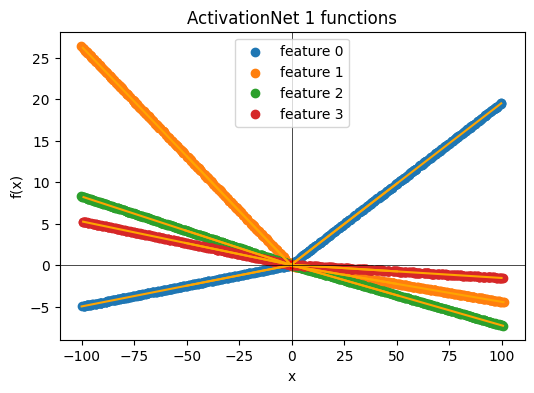

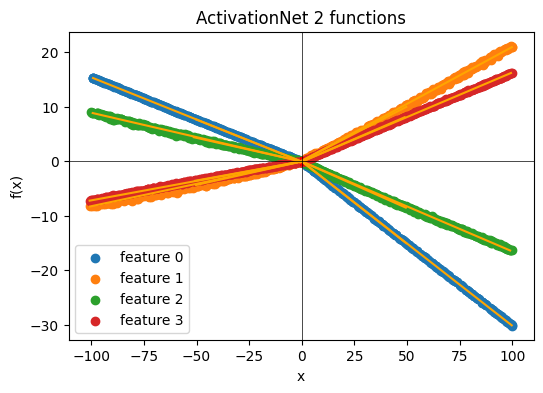

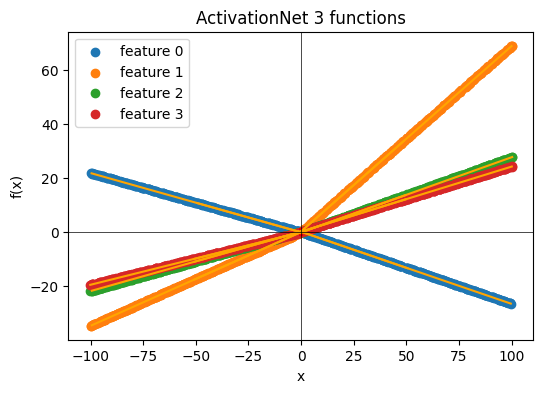

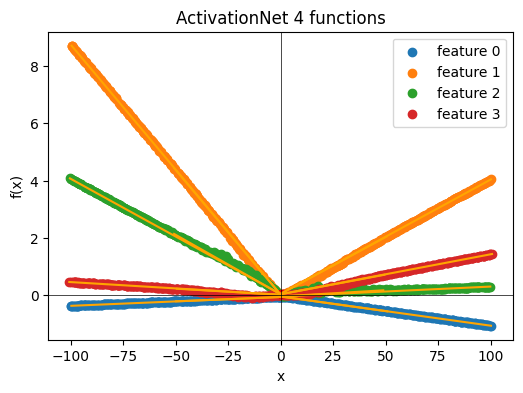

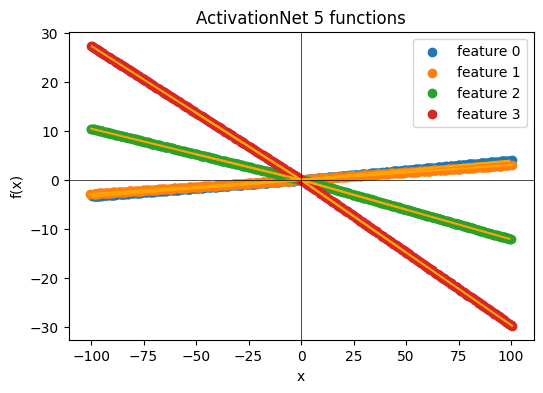

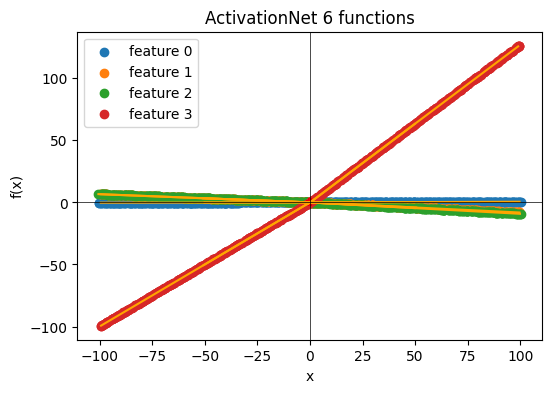

In [38]:
# (torch.rand(num_points) * 2 * x_max) - x_max for _ in range(act.num_features)
# torch.linspace(x_min, x_max, num_points) for _ in range(act.num_features)
# torch.linspace(x_min, x_max, num_points) + ((torch.rand(num_points) * 2 * 1) - 1) for _ in range(act.num_features)

def plot_chain_activations(model, x_min=-100, x_max=100, num_points=512, select_features=[0,1,2,3]):
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]

    for i, act in enumerate(activations, 1):
        # prepare input: each feature gets the same linspace
        xs = torch.stack([
            torch.linspace(x_min, x_max, num_points) + ((torch.rand(num_points) * 2 * 1) - 1) for _ in range(act.num_features)
        ], dim=1).to(device)   # [num_points, num_features]

        out, internal_out = act(xs)
        ys = out[1]
        ys = ys.detach().cpu().numpy()
        xs = xs.detach().cpu().numpy()

        int_xs, int_ys, _ = internal_out
        int_ys = int_ys.detach().cpu().numpy()
        int_xs = int_xs.detach().cpu().numpy()

        # new figure for each activation
        plt.figure(figsize=(6, 4))
        for k in select_features:
            if k < act.num_features:  # avoid index error
                plt.scatter(xs[:, k], ys[:, k], label=f"feature {k}")

                plt.scatter(int_xs[:, k], int_ys[:, k], marker="+", color="red")
                
                # Number of points to select
                select_k_points = 5
                indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                # Prepare x and y pairs for all segments
                gen_data_X = np.column_stack([int_xs[indices, k], xs[indices, k]]).T   # shape (2, k)
                gen_pred_Y = np.column_stack([int_ys[indices, k], ys[indices, k]]).T   # shape (2, k)
                # Plot all segments at once
                plt.plot(gen_data_X, gen_pred_Y, color="orange")

        plt.axhline(0, color="k", linewidth=0.5)
        plt.axvline(0, color="k", linewidth=0.5)
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.title(f"ActivationNet {i} functions")
        plt.show()

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)
model.eval()

plot_chain_activations(model, x_min=-100, x_max=100, num_points=512, select_features=[0,1,2,3])

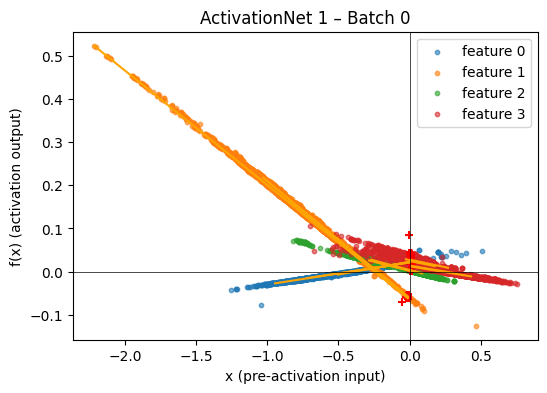

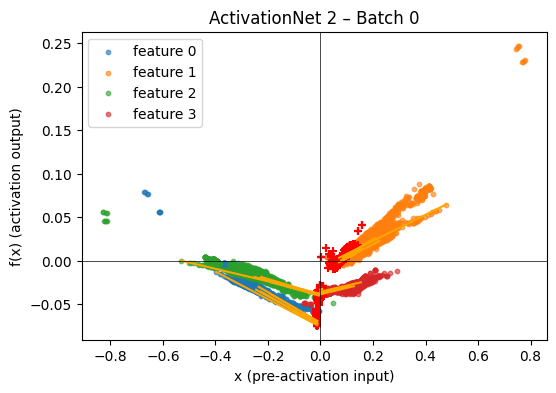

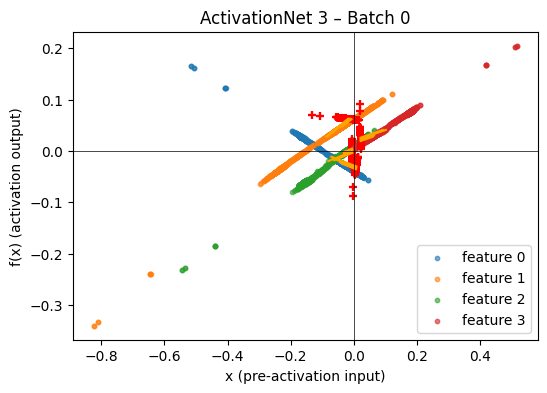

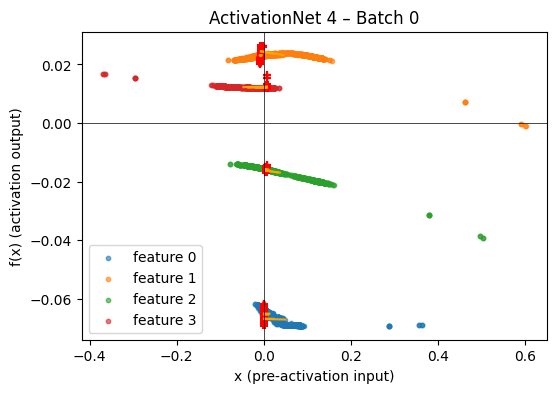

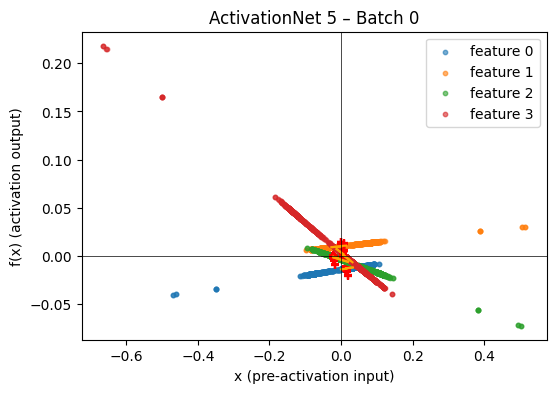

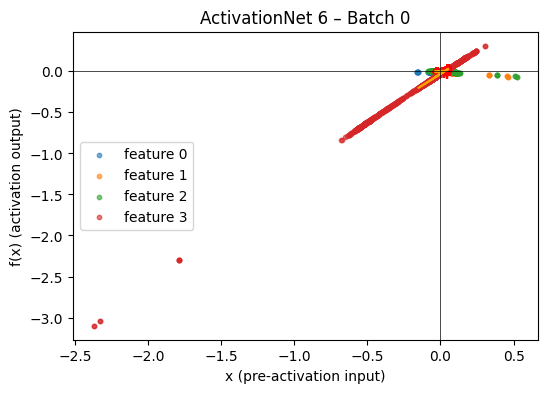

In [39]:
def plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0]):
    """
    Plot activations of ActivationNet modules using data flowing through the model on test_loader.
    Uses forward hooks to capture inputs and outputs of ActivationNet layers.
    """
    model.eval()
    device = next(model.parameters()).device

    # Collect activation modules
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]
    act_inputs, act_outputs = [], []

    # Hook to capture activations
    def hook_fn(module, inputs, outputs):
        act_inputs.append(inputs[0].detach().cpu())
        main_out, internal_out = outputs
        y = main_out[1]
        int_x, int_y, _ = internal_out
        act_outputs.append([y.detach().cpu(), int_x.detach().cpu(), int_y.detach().cpu()])

    # Register hooks
    hooks = []
    for act in activations:
        hooks.append(act.register_forward_hook(hook_fn))

    # Run model on test batches
    for batch_idx, (inputs, _, _) in enumerate(test_loader):
        if batch_idx >= num_batches:
            break

        inputs = inputs.to(device)
        with torch.no_grad():
            _ = model(inputs)  # forward pass, hooks will store activations

        # Plot each ActivationNet
        for i, (xs, act_output) in enumerate(zip(act_inputs, act_outputs), 1):
            ys, int_xs, int_ys = act_output
            xs, ys = xs.numpy(), ys.numpy()
            int_xs, int_ys = int_xs.numpy(), int_ys.numpy()

            plt.figure(figsize=(6, 4))
            for k in select_features:
                if k < xs.shape[1]:  # avoid index errors
                    plt.scatter(xs[:, k], ys[:, k], s=10, alpha=0.6, label=f"feature {k}")

                    plt.scatter(int_xs[:, k], int_ys[:, k], marker="+", color="red")
        
                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices, k], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices, k], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    plt.plot(gen_data_X, gen_pred_Y, color="orange")
            
            plt.axhline(0, color="k", linewidth=0.5)
            plt.axvline(0, color="k", linewidth=0.5)
            plt.legend()
            plt.xlabel("x (pre-activation input)")
            plt.ylabel("f(x) (activation output)")
            plt.title(f"ActivationNet {i} – Batch {batch_idx}")
            plt.show()

        # Clear after each batch to avoid accumulation
        act_inputs.clear()
        act_outputs.clear()

    # Remove hooks after plotting
    for h in hooks:
        h.remove()


if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)

plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0, 1, 2, 3])

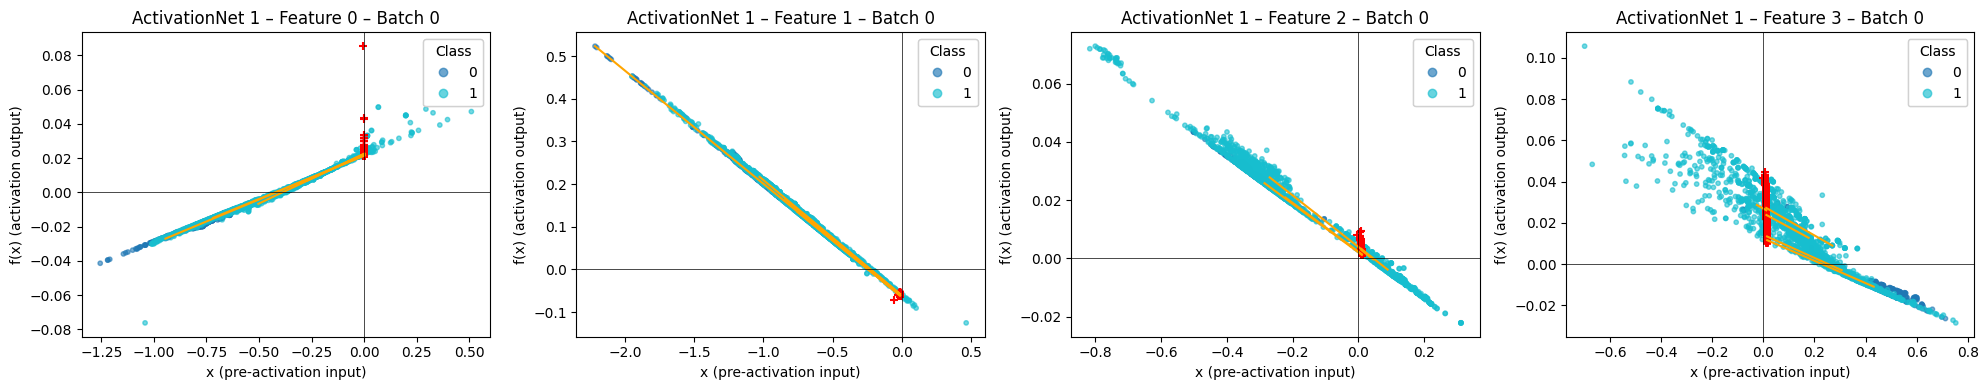

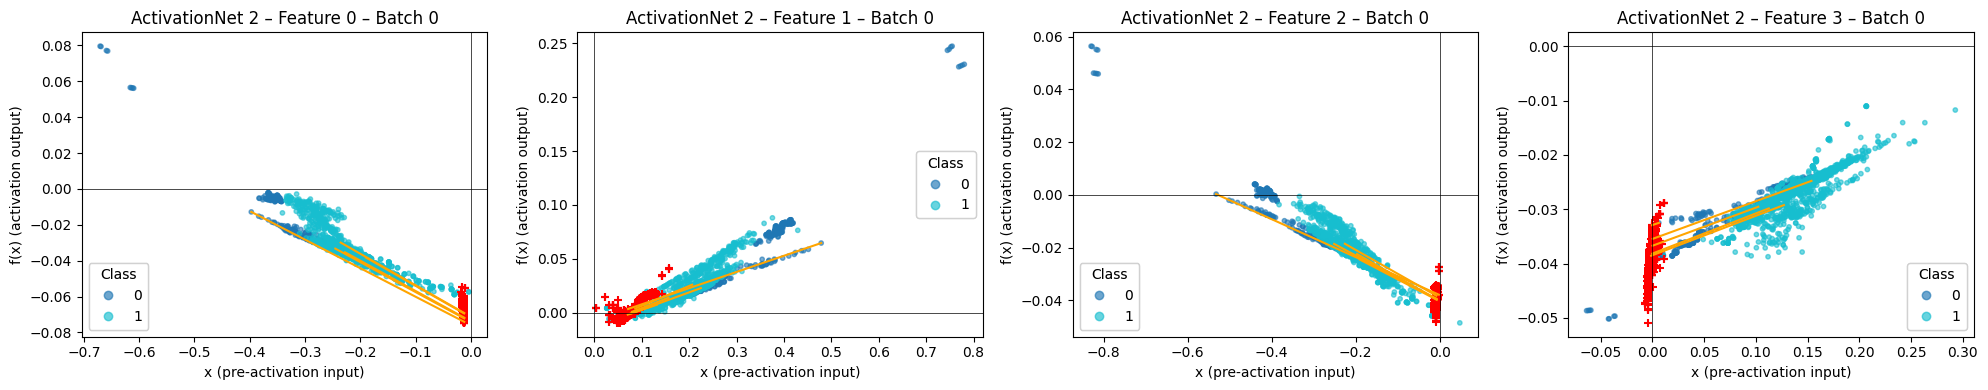

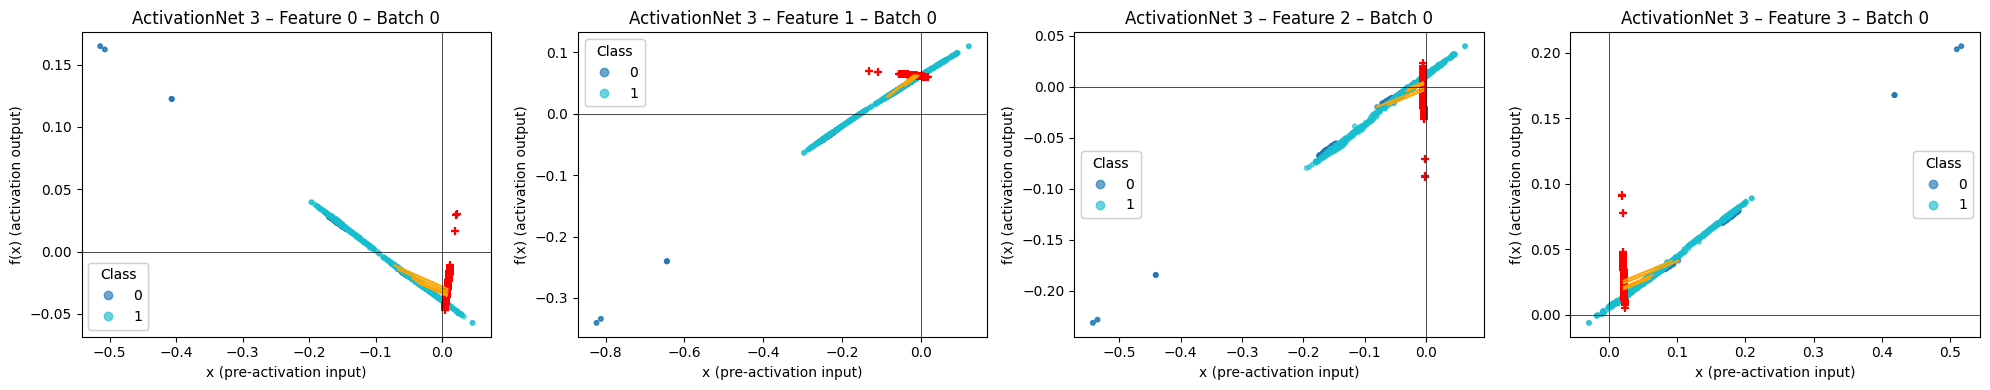

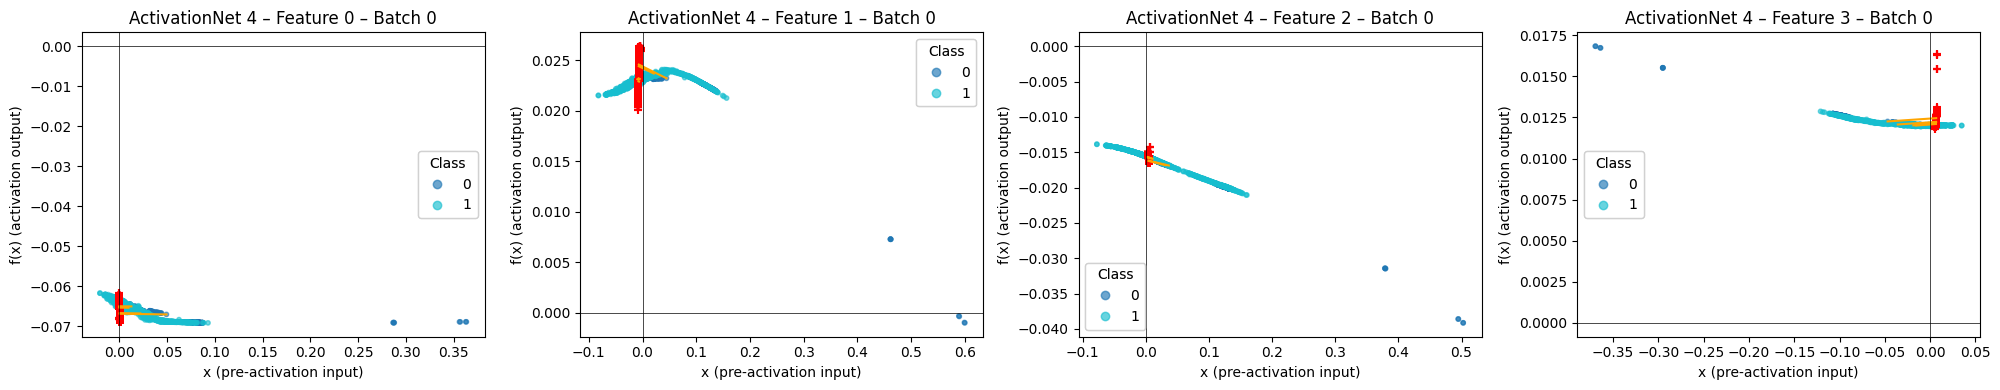

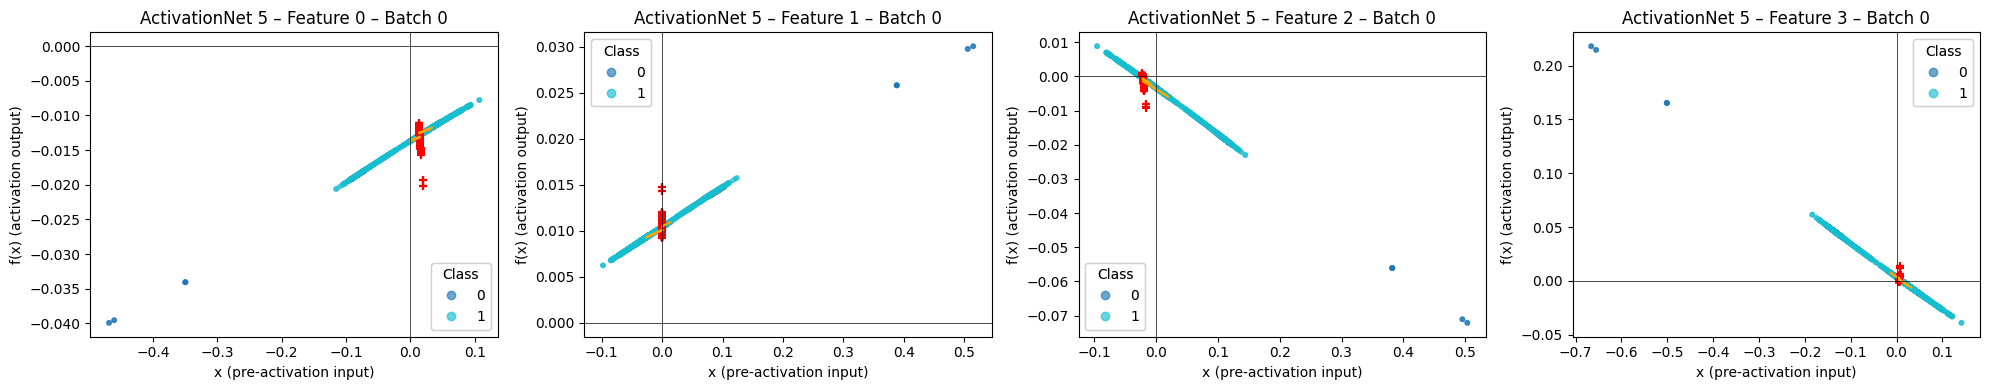

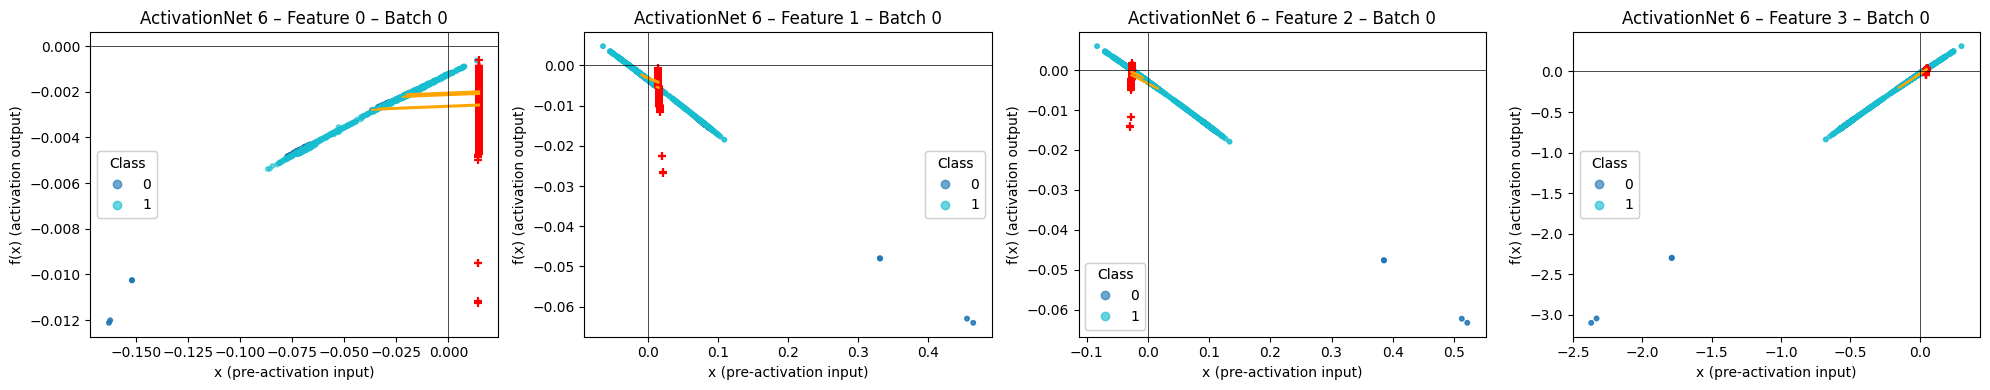

In [40]:
def plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0], color_by_class=False):
    """
    Plot activations of ActivationNet modules using data flowing through the model on test_loader.
    Each selected feature gets its own subplot instead of all being in one plot.

    Args:
        model: Trained KDD_Model instance
        test_loader: DataLoader with test dataset
        num_batches: Number of batches to visualize
        select_features: List of feature indices to plot
        color_by_class: If True, color points by class label from dataset
    """
    model.eval()
    device = next(model.parameters()).device

    # Collect activation modules
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]
    act_inputs, act_outputs = [], []

    # Hook to capture activations
    def hook_fn(module, inputs, outputs):
        act_inputs.append(inputs[0].detach().cpu())
        main_out, internal_out = outputs
        y = main_out[1]
        int_x, int_y, _ = internal_out
        act_outputs.append([y.detach().cpu(), int_x.detach().cpu(), int_y.detach().cpu()])

    # Register hooks
    hooks = [act.register_forward_hook(hook_fn) for act in activations]

    # Run model on test batches
    for batch_idx, (inputs, labels, _) in enumerate(test_loader):  # assuming dataset returns (x, y, extra)
        if batch_idx >= num_batches:
            break

        inputs = inputs.to(device)
        labels = labels.cpu().numpy() if color_by_class else None

        with torch.no_grad():
            _ = model(inputs)  # forward pass, hooks will store activations

        # Plot each ActivationNet
        for i, (xs, act_output) in enumerate(zip(act_inputs, act_outputs), 1):
            ys, int_xs, int_ys = act_output
            xs, ys = xs.numpy(), ys.numpy()
            int_xs, int_ys = int_xs.numpy(), int_ys.numpy()

            feats = [k for k in select_features if k < xs.shape[1]]
            n_feats = len(feats)
            if n_feats == 0:
                continue

            fig, axes = plt.subplots(1, n_feats, figsize=(5 * n_feats, 4), squeeze=False)

            for j, k in enumerate(feats):
                ax = axes[0, j]

                if color_by_class and labels is not None:
                    scatter = ax.scatter(xs[:, k], ys[:, k], c=labels, cmap="tab10", s=10, alpha=0.6)

                    ax.scatter(int_xs[:, k], int_ys[:, k], marker="+", color="red")

                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices, k], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices, k], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    ax.plot(gen_data_X, gen_pred_Y, color="orange")
                    
                    legend1 = ax.legend(*scatter.legend_elements(), title="Class")
                    ax.add_artist(legend1)
                else:
                    ax.scatter(xs[:, k], ys[:, k], s=10, alpha=0.6, label=f"feature {k}")

                    ax.scatter(int_xs[:, k], int_ys[:, k], marker="+", color="red")

                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices, k], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices, k], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    ax.plot(gen_data_X, gen_pred_Y, color="orange")
                    
                    ax.legend()

                ax.axhline(0, color="k", linewidth=0.5)
                ax.axvline(0, color="k", linewidth=0.5)
                ax.set_xlabel("x (pre-activation input)")
                ax.set_ylabel("f(x) (activation output)")
                ax.set_title(f"ActivationNet {i} – Feature {k} – Batch {batch_idx}")

            plt.tight_layout()
            plt.show()

        # Clear after each batch to avoid accumulation
        act_inputs.clear()
        act_outputs.clear()

    # Remove hooks after plotting
    for h in hooks:
        h.remove()

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)

plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0, 1, 2, 3], color_by_class=True)

In [16]:
class ActivationNet(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.layer = nn.Linear(num_features, 8)
        self.drop = nn.Dropout(0.8)
        self.bn = nn.BatchNorm1d(8)
        
        self.y0_head = nn.Linear(8, num_features)
        self.m_head  = nn.Linear(8, num_features)
        self.x0_head = nn.Linear(8, num_features)
        self.combine = nn.Linear(3 * num_features, 3 * num_features)

    def forward(self, x):
        h = self.layer(x)
        h = torch.tanh(h)
        h = self.bn(h)
        h = self.drop(h)
        
        y0 = self.y0_head(h)
        m  = self.m_head(h)
        x0 = self.x0_head(h)
        
        params = torch.cat([y0, m, x0], dim=-1)
        params = self.combine(params)
        
        y0, m, x0 = torch.split(params, self.num_features, dim=1)
        y = y0 + m * (x - x0)
        return y

class KDD_Model(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.layer1 = nn.Linear(input_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.activation1 = ActivationNet(512)
        self.drop1 = nn.Dropout(0.8)

        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.activation2 = ActivationNet(256)
        self.drop2 = nn.Dropout(0.8)

        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.activation3 = ActivationNet(128)
        self.drop3 = nn.Dropout(0.8)

        self.layer4 = nn.Linear(128, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.activation4 = ActivationNet(128)
        self.drop4 = nn.Dropout(0.8)

        self.layer5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.activation5 = ActivationNet(64)

        self.layer6 = nn.Linear(64, 32)
        self.bn6 = nn.BatchNorm1d(32)
        self.activation6 = ActivationNet(32)

        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.drop1(self.activation1(self.bn1(self.layer1(x))))
        x = self.drop2(self.activation2(self.bn2(self.layer2(x))))
        x = self.drop3(self.activation3(self.bn3(self.layer3(x))))
        
        res = x
        out = self.layer4(x)
        out = self.bn4(out)
        out = self.activation4(out)
        out = self.drop4(out)
        x = out + res

        x = self.activation5(self.bn5(self.layer5(x)))
        x = self.activation6(self.bn6(self.layer6(x)))
        x = self.output_layer(x)
        return x

# --- Pruning Functions Adapted for the New Model ---

def collect_activations_new(model, loader, device, layer_num):
    """
    Run data through a specific block of the new model and collect activations.
    layer_num: 1, 2, 3, 4, 5, or 6
    """
    model.eval()
    acts = []

    with torch.no_grad():
        for xb in loader:
            # Assuming loader yields (xb, yb) or similar tuple
            if isinstance(xb, (list, tuple)):
                xb = xb[0]
            xb = xb.to(device)

            # Block 1
            x = model.drop1(model.activation1(model.bn1(model.layer1(xb))))
            if layer_num == 1:
                acts.append(x.cpu())
                continue

            # Block 2
            x = model.drop2(model.activation2(model.bn2(model.layer2(x))))
            if layer_num == 2:
                acts.append(x.cpu())
                continue
            
            # Block 3
            x = model.drop3(model.activation3(model.bn3(model.layer3(x))))
            if layer_num == 3:
                acts.append(x.cpu())
                continue

            # Block 4 (with residual)
            res = x
            out = model.drop4(model.activation4(model.bn4(model.layer4(x))))
            x = out + res
            if layer_num == 4:
                acts.append(x.cpu())
                continue

            # Block 5
            x = model.activation5(model.bn5(model.layer5(x)))
            if layer_num == 5:
                acts.append(x.cpu())
                continue
            
            # Block 6
            x = model.activation6(model.bn6(model.layer6(x)))
            if layer_num == 6:
                acts.append(x.cpu())
                continue

    acts = torch.cat(acts, dim=0)
    return acts

def prune_block_new(layer, bn, activation, drop, next_layer, alive_indices):
    """
    Prunes a standard block (Linear, BN, Activation, Dropout) and the input of the next layer.
    """
    num_alive = len(alive_indices)
    
    # Prune current layer output (rows)
    new_layer = nn.Linear(layer.in_features, num_alive, bias=True)
    new_layer.weight.data = layer.weight.data[alive_indices].clone()
    new_layer.bias.data   = layer.bias.data[alive_indices].clone()

    # Prune batchnorm
    new_bn = nn.BatchNorm1d(num_alive)
    new_bn.weight.data = bn.weight.data[alive_indices].clone()
    new_bn.bias.data   = bn.bias.data[alive_indices].clone()
    new_bn.running_mean = bn.running_mean[alive_indices].clone()
    new_bn.running_var  = bn.running_var[alive_indices].clone()

    # Prune activation
    new_activation = ActivationNet(num_features=num_alive)
    new_activation.layer.weight.data = activation.layer.weight.data[:, alive_indices].clone()
    new_activation.layer.bias.data   = activation.layer.bias.data.clone()
    
    new_activation.bn = copy.deepcopy(activation.bn)
    new_activation.drop = copy.deepcopy(activation.drop)
    
    new_activation.y0_head.weight.data = activation.y0_head.weight.data[alive_indices].clone()
    new_activation.y0_head.bias.data   = activation.y0_head.bias.data[alive_indices].clone()
    
    new_activation.m_head.weight.data = activation.m_head.weight.data[alive_indices].clone()
    new_activation.m_head.bias.data   = activation.m_head.bias.data[alive_indices].clone()

    new_activation.x0_head.weight.data = activation.x0_head.weight.data[alive_indices].clone()
    new_activation.x0_head.bias.data   = activation.x0_head.bias.data[alive_indices].clone()

    # Prune combine layer (both input and output) using more robust indexing
    idx_3 = torch.cat([alive_indices, alive_indices + activation.num_features, alive_indices + 2 * activation.num_features])
    new_activation.combine.weight.data = activation.combine.weight.data[idx_3][:, idx_3].clone()
    new_activation.combine.bias.data   = activation.combine.bias.data[idx_3].clone()
    
    new_drop = drop
    
    # Prune next layer input (cols)
    new_next_layer = nn.Linear(num_alive, next_layer.out_features, bias=True)
    new_next_layer.weight.data = next_layer.weight.data[:, alive_indices].clone()
    new_next_layer.bias.data   = next_layer.bias.data.clone()

    return new_layer, new_bn, new_activation, new_drop, new_next_layer

def prune_residual_block_4(layer, bn, activation, drop, next_layer, alive_indices):
    """
    Special pruning function for the residual block (Block 4).
    The input dimension of `layer` is assumed to be already pruned correctly.
    This function prunes the output dimension to match.
    """
    num_alive = len(alive_indices)
    
    # Create the new layer with matching input and output sizes
    new_layer = nn.Linear(num_alive, num_alive, bias=True)

    # --- THE FIX IS HERE ---
    # The weight matrix's input dimension (columns) is already size `num_alive`.
    # We only need to select the output rows based on `alive_indices`.
    new_layer.weight.data = layer.weight.data[alive_indices, :].clone()
    new_layer.bias.data   = layer.bias.data[alive_indices].clone()

    # Prune batchnorm
    new_bn = nn.BatchNorm1d(num_alive)
    new_bn.weight.data = bn.weight.data[alive_indices].clone()
    new_bn.bias.data   = bn.bias.data[alive_indices].clone()
    new_bn.running_mean = bn.running_mean[alive_indices].clone()
    new_bn.running_var  = bn.running_var[alive_indices].clone()

    # Prune activation
    new_activation = ActivationNet(num_features=num_alive)
    new_activation.layer.weight.data = activation.layer.weight.data[:, alive_indices].clone()
    new_activation.layer.bias.data   = activation.layer.bias.data.clone()
    
    new_activation.bn = copy.deepcopy(activation.bn)
    new_activation.drop = copy.deepcopy(activation.drop)
    
    new_activation.y0_head.weight.data = activation.y0_head.weight.data[alive_indices].clone()
    new_activation.y0_head.bias.data   = activation.y0_head.bias.data[alive_indices].clone()
    new_activation.m_head.weight.data  = activation.m_head.weight.data[alive_indices].clone()
    new_activation.m_head.bias.data    = activation.m_head.bias.data[alive_indices].clone()
    new_activation.x0_head.weight.data = activation.x0_head.weight.data[alive_indices].clone()
    new_activation.x0_head.bias.data   = activation.x0_head.bias.data[alive_indices].clone()

    # Prune combine layer using more robust indexing
    idx_3 = torch.cat([alive_indices, alive_indices + activation.num_features, alive_indices + 2 * activation.num_features])
    # Select rows first, then select columns from the result
    new_activation.combine.weight.data = activation.combine.weight.data[idx_3][:, idx_3].clone()
    new_activation.combine.bias.data   = activation.combine.bias.data[idx_3].clone()

    new_drop = drop
    
    # Prune next layer input (layer 5)
    new_next_layer = nn.Linear(num_alive, next_layer.out_features, bias=True)
    new_next_layer.weight.data = next_layer.weight.data[:, alive_indices].clone()
    new_next_layer.bias.data   = next_layer.bias.data.clone()

    return new_layer, new_bn, new_activation, new_drop, new_next_layer

def prune_model_new(model, train_loader, device, threshold=1e-5):
    """Prunes the new KDD_Model layer by layer."""
    p_model = copy.deepcopy(model)
    
    # ---- Block 1 ----
    print("Pruning Block 1...")
    acts1 = collect_activations_new(p_model, train_loader, device, layer_num=1)
    mask1 = (acts1.abs().mean(dim=0) >= threshold)
    idx1 = torch.where(mask1)[0]
    print(f"  Keeping {len(idx1)} / {p_model.layer1.out_features} neurons.")
    
    p_model.layer1, p_model.bn1, p_model.activation1, p_model.drop1, p_model.layer2 = prune_block_new(
        p_model.layer1, p_model.bn1, p_model.activation1, p_model.drop1, p_model.layer2, idx1
    )

    # ---- Block 2 ----
    print("Pruning Block 2...")
    acts2 = collect_activations_new(p_model, train_loader, device, layer_num=2)
    mask2 = (acts2.abs().mean(dim=0) >= threshold)
    idx2 = torch.where(mask2)[0]
    print(f"  Keeping {len(idx2)} / {p_model.layer2.out_features} neurons.")

    p_model.layer2, p_model.bn2, p_model.activation2, p_model.drop2, p_model.layer3 = prune_block_new(
        p_model.layer2, p_model.bn2, p_model.activation2, p_model.drop2, p_model.layer3, idx2
    )

    # ---- Block 3 ----
    print("Pruning Block 3...")
    acts3 = collect_activations_new(p_model, train_loader, device, layer_num=3)
    mask3 = (acts3.abs().mean(dim=0) >= threshold)
    idx3 = torch.where(mask3)[0]
    print(f"  Keeping {len(idx3)} / {p_model.layer3.out_features} neurons.")

    p_model.layer3, p_model.bn3, p_model.activation3, p_model.drop3, p_model.layer4 = prune_block_new(
        p_model.layer3, p_model.bn3, p_model.activation3, p_model.drop3, p_model.layer4, idx3
    )
    
    # ---- Block 4 (Residual) ----
    print("Pruning Block 4 (Residual)...")
    print(f"  Forcing block to keep {len(idx3)} neurons to match residual connection.")
    # We re-use idx3 to ensure the dimensions for the residual connection match.
    p_model.layer4, p_model.bn4, p_model.activation4, p_model.drop4, p_model.layer5 = prune_residual_block_4(
        p_model.layer4, p_model.bn4, p_model.activation4, p_model.drop4, p_model.layer5, idx3
    )

    # ---- Block 5 ----
    print("Pruning Block 5...")
    acts5 = collect_activations_new(p_model, train_loader, device, layer_num=5)
    mask5 = (acts5.abs().mean(dim=0) >= threshold)
    idx5 = torch.where(mask5)[0]
    print(f"  Keeping {len(idx5)} / {p_model.layer5.out_features} neurons.")

    # Block 5 has no dropout, so we pass a placeholder and ignore its return
    p_model.layer5, p_model.bn5, p_model.activation5, _, p_model.layer6 = prune_block_new(
        p_model.layer5, p_model.bn5, p_model.activation5, nn.Identity(), p_model.layer6, idx5
    )

    # ---- Block 6 ----
    print("Pruning Block 6...")
    acts6 = collect_activations_new(p_model, train_loader, device, layer_num=6)
    mask6 = (acts6.abs().mean(dim=0) >= threshold)
    idx6 = torch.where(mask6)[0]
    print(f"  Keeping {len(idx6)} / {p_model.layer6.out_features} neurons.")

    p_model.layer6, p_model.bn6, p_model.activation6, _, p_model.output_layer = prune_block_new(
        p_model.layer6, p_model.bn6, p_model.activation6, nn.Identity(), p_model.output_layer, idx6
    )

    return p_model

model = KDD_Model(input_features)
model.load_state_dict(torch.load(BEST_MODEL_PATH)) # In a real scenario
model = model.to("cpu")
model.eval()

print("--- Original Model ---")
print(model)

# Prune the model
p_model = prune_model_new(model, train_loader, device="cpu", threshold=0.005)
p_model = p_model.to(device)
model = model.to(device)
model.eval()
p_model.eval()

print("\n--- Pruned Model ---")
print(p_model)

--- Original Model ---
KDD_Model(
  (layer1): Linear(in_features=43, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ActivationNet(
    (layer): Linear(in_features=512, out_features=8, bias=True)
    (drop): Dropout(p=0.8, inplace=False)
    (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (y0_head): Linear(in_features=8, out_features=512, bias=True)
    (m_head): Linear(in_features=8, out_features=512, bias=True)
    (x0_head): Linear(in_features=8, out_features=512, bias=True)
    (combine): Linear(in_features=1536, out_features=1536, bias=True)
  )
  (drop1): Dropout(p=0.8, inplace=False)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): ActivationNet(
    (layer): Linear(in_features=256, out_features=8, bias=True)
    (drop): Dropout(p=

In [17]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# usage
total_params_m, trainable_params_m = count_parameters(model)
print(f"Total parameters of model: {total_params_m:,}")
print(f"Trainable parameters of model: {trainable_params_m:,}")

# usage
total_params_p, trainable_params_p = count_parameters(p_model)
print(f"Total parameters of p_model: {total_params_p:,}")
print(f"Trainable parameters of p_model: {trainable_params_p:,}")

print(f"Total reduction: {((total_params_m - total_params_p) / total_params_m) * 100}")

Total parameters of model: 3,548,689
Trainable parameters of model: 3,548,689
Total parameters of p_model: 3,515,825
Trainable parameters of p_model: 3,515,825
Total reduction: 0.9260884794356451


In [18]:
# Evaluation Function

@torch.no_grad()
def evaluate_model_threshold(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_count = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc=f"Testing", leave=True)

    for inputs, labels, _ in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device).view(-1).long()
        outputs = model(inputs)

        # logits -> probs
        probs = torch.sigmoid(outputs.view(-1))
        preds = (probs >= THRESH).long()

        # per-sample loss (no weights on test unless you have a test weight vector)
        losses = loss_fn(outputs.view(-1), labels.float()).mean()

        batch_size = labels.size(0)
        total_loss += losses.item() * batch_size
        total_count += batch_size

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(loss=total_loss / total_count)

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Accuracy via thresholded preds
    acc = (all_preds == all_labels).mean()

    # Macro P/R/F1 (over classes 0 and 1)
    p, r, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    avg_loss = total_loss / total_count
    return avg_loss, acc, p, r, f1

In [19]:
test_loss, test_acc, test_p, test_r, test_f1 = evaluate_model_threshold(
        model, test_loader, loss_fn, device
    )
print(
    f"Test Loss: {test_loss:.4f}, Acc(th={THRESH}): {test_acc:.4f}, "
    f"P: {test_p:.4f}, R: {test_r:.4f}, F1: {test_f1:.4f}"
)

test_loss, test_acc, test_p, test_r, test_f1 = evaluate_model_threshold(
        p_model, test_loader, loss_fn, device
    )
print(
    f"Test Loss: {test_loss:.4f}, Acc(th={THRESH}): {test_acc:.4f}, "
    f"P: {test_p:.4f}, R: {test_r:.4f}, F1: {test_f1:.4f}"
)

Testing: 100%|███████████████████████████████████████████████████████████████| 41/41 [00:05<00:00,  7.48it/s, loss=0.49]


Test Loss: 0.4904, Acc(th=0.5): 0.8625, P: 0.8609, R: 0.8618, F1: 0.8613


Testing: 100%|██████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 63.09it/s, loss=0.498]

Test Loss: 0.4976, Acc(th=0.5): 0.8502, P: 0.8560, R: 0.8427, F1: 0.8463
